# Python Notebook for showcaing data analysis pipeline and reproducing the figures in [**Amygdala GABA Neurons: Gatekeepers of Stress and Reproduction**](https://www.biorxiv.org/content/10.1101/2025.01.06.631361v1.full).

Last Update: 28 January 2025 by Saeed Farjami (University of Exeter)

# **Preparation**

In [ ]:
# Check connection with the server
!python --version

Python 3.11.11


### Installing Required Packages

In [ ]:
!pip install shapely
!pip install  scikit_posthocs

### Mounting Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


### Installing and Importing Packages and Modules

In [ ]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import gridspec
from matplotlib.cm import ScalarMappable

from scipy.signal import correlate, periodogram
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import pdist, squareform
from scipy.stats import mannwhitneyu, kstest, kruskal, combine_pvalues

from sklearn.preprocessing import scale, minmax_scale
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score

from itertools import product

from matplotlib.patches import Ellipse, Polygon
from shapely.geometry import Polygon as ShapelyPolygon

from scikit_posthocs import posthoc_dunn

# from scipy.cluster.hierarchy import ClusterWarning
# from warnings import simplefilter
# simplefilter("ignore", ClusterWarning)

# import warnings
# warnings.filterwarnings("ignore", category=FutureWarning)

print("Imports done!")

Imports done!


These two sections below are optional. They are only required for consistency of the style of the figures.

In [ ]:
# Set the default theme for seaborn plots
sns.set_theme(
        context='notebook',
        style='whitegrid',
        palette='deep',
        font='DejaVu Sans',
        font_scale=1.5,
        rc={
            'lines.linewidth': 2,
            'lines.markersize': 8,
            'xtick.labelsize': 15,
            'ytick.labelsize': 15
        }
    )

In [ ]:
# Customise matplotlib plot settings for consistency
rc_params = {
    'axes.grid': False,
    'font.family': 'DejaVu Sans',
    'font.size': 15,
    'lines.linewidth': 2,
    'lines.markersize': 8,
    'xtick.major.size': 3,
    'ytick.major.size': 3,
    'xtick.labelsize': 15,
    'ytick.labelsize': 15,
    'xtick.bottom': True,
    'xtick.top': False,
    'ytick.left': True,
    'ytick.right': False,
    'axes.edgecolor': 'grey'
}

for param, value in rc_params.items():
    plt.rcParams[param] = value

### Useful Functions

Several functions have been defined here. to avoid repeating the code; however, in parts, I have repeated these steps with appropriate comments for better readability.

In [ ]:
def load_data(stim_csv_fname):
    """
    Load data and strip metadata.

    Parameters:
        stim_csv_fname (str): Path to the CSV file containing stimulation data.

    Returns:
        tuple: A tuple containing:
            - cells_traces_stim_tot (pd.DataFrame): Processed data with artifacts removed.
            - n_cells (int): Number of remaining cells.
    Returns:
        tuple: A tuple containing:
            - data_stim (pd.DataFrame): Original data.
            - cells_traces_tot_old (pd.DataFrame): Processed data with metadata removed.
    """
    # Load and preprocess data
    data_stim = pd.read_csv(stim_csv_fname).T

    # Strip any leading/trailing whitespace from the index (row names)
    data_stim.index = data_stim.index.str.strip()

    # Extract fluorescence intensity data
    cells_traces_tot_old = data_stim.iloc[1:, 1:]

    return data_stim, cells_traces_tot_old

In [ ]:
def process_data(original_data, processed_data, stim_onset=1204, stim_offset=2404, stimulus_freq=0.1, kmeans_clusters=2, random_state=11111):
    """
    Process stimulation data, remove artifacts, and apply K-means clustering to sort activity traces.

    Parameters:
        original_data (pd.DataFrame): Original data.
        processed_data (pd.DataFrame): Processed data with metadata removed.
        stim_onset (int): Index of stimulation onset in the data.
        stim_offset (int): Index of stimulation offset in the data.
        stimulus_freq (float): Frequency of the stimulus [Hz]. Default is 0.1 Hz.
        kmeans_clusters (int): Number of clusters for K-means clustering. Default is 2.
        random_state (int): Random seed for reproducibility. Default is 11111.

    Returns:
        tuple: A tuple containing:
            - data_stim_tot (np.ndarray): Processed data with artifacts removed.
            - n_cells (int): Number of remaining cells.
    """
    # Load and preprocess data
    # data_stim = pd.read_csv(stim_csv_fname).T
    # data_stim.index = data_stim.index.str.strip()

    # Extract number of recorded cells from data set
    total_cells_stim, _ = processed_data.shape

    # Create time axis and calculate sampling frequency
    ts_stim_tot = np.asarray(data_stim.iloc[0, 1:], dtype=float)
    sec_per_frame = ts_stim_tot[1]  # Time between frames [s]
    fs = 1 / sec_per_frame          # Sampling frequency [Hz]

    # Convert temporal activity data to numerical format
    data_stim_artifact = np.asarray(processed_data, dtype=float)

    # Identify resonating cells based on power spectral density
    labels_removed_PSD = []
    for i in range(total_cells_stim):
        freq, Pxx_den = periodogram(data_stim_artifact[i, stim_onset:stim_offset], fs)
        Pxx_den = Pxx_den / max(Pxx_den)
        if Pxx_den[round(stimulus_freq * (stim_offset - stim_onset) / fs)] > 0.37:
            labels_removed_PSD.append(i)

    # Remove resonating cells
    labels_artifact = np.asarray([0 if _ in labels_removed_PSD else 1 for _ in range(total_cells_stim)])

    # Apply K-means clustering
    km = KMeans(n_clusters=kmeans_clusters, random_state=random_state, n_init=10, max_iter=100)
    km.fit(scale(data_stim_artifact[:, stim_onset:stim_offset], axis=0))
    labels_artifact_KM = km.labels_

    # Determine which cluster to remove
    if len(data_stim_artifact[labels_artifact_KM == 0]) < len(data_stim_artifact[labels_artifact_KM == 1]):
        cluster_removed = 0
    else:
        cluster_removed = 1

    # Update labels for removal
    for i in range(len(data_stim_artifact)):
        if labels_artifact[i] == 1 and labels_artifact_KM[i] == cluster_removed:
            labels_artifact[i] = 0

    # Identify cells to remove
    labels_removed = np.where(labels_artifact == cluster_removed)[0]
    removed_row_labels = processed_data.index[labels_removed]

    # Remove resonating cells from data
    cells_traces_stim_tot = processed_data.drop(removed_row_labels, axis=0, inplace=False)

    # Convert filtered temporal activity data from pandas DataFrame to numerical arrays
    data_stim_tot = np.asarray(cells_traces_stim_tot, dtype=float)

    # Count remaining cells
    n_cells = len(cells_traces_stim_tot)

    return data_stim_tot, n_cells

In [ ]:
# Normalise fluorescence traces using Min-Max normalisation
def min_max_norm(data):
    """
    Normalises the input data using Min-Max normalisation.

    Parameters:
        data (numpy.ndarray): Array of fluorescence trace data.

    Returns:
        numpy.ndarray: Normalised data, scaled to the range [0, 1].
    """
    return (data - np.min(data)) / np.max(data) - np.min(data)

In [ ]:
# Convert p-value to significance stars for visualisation
def pval_to_star(pvalue):
    """
    Converts a p-value into a string representing significance levels.

    Parameters:
        pvalue (float): The p-value to evaluate.

    Returns:
        str: A string with significance stars ('****', '***', '**', '*') or 'ns' (not significant).
    """
    if pvalue <= 0.0001:
        return '****'  # Highly significant
    elif pvalue <= 0.001:
        return '***'   # Very significant
    elif pvalue <= 0.01:
        return '**'    # Significant
    elif pvalue <= 0.05:
        return '*'     # Marginally significant
    else:
        return 'ns'    # Not significant

In [ ]:
# Compute a metric based on signed lagged cross-correlation (SLxCorr)
def signed_lagged_corr(x, y):
    """
    Computes the signed lagged cross-correlation between two signals and identifies the lag with the maximum absolute correlation.

    Parameters:
        x (numpy.ndarray): First input signal.
        y (numpy.ndarray): Second input signal.

    Returns:
        tuple:
            - float: Signed cross-correlation at the lag with maximum absolute correlation.
            - int: Index corresponding to the lag with maximum absolute correlation.
    """
    # Compute the full cross-correlation between x and y
    cross_corr = correlate(x, y, mode='full')

    # Compute auto-correlations for normalisation
    auto_corr_x = correlate(x, x, mode='full')
    auto_corr_y = correlate(y, y, mode='full')

    # Compute the normalised cross-correlation (SBD)
    norm_factor = np.sqrt(np.max(auto_corr_x) * np.max(auto_corr_y))
    if norm_factor == 0:
        raise ValueError("Normalisation factor is zero. Ensure signals are non-zero.")

    sbd = cross_corr / norm_factor  # Normalised cross-correlation
    abs_sbd = np.abs(sbd)           # Magnitudes of cross-correlation

    # Find the lag with the maximum absolute correlation
    max_lag_index = np.argmax(abs_sbd)
    signed_correlation = sbd[max_lag_index]

    return signed_correlation, max_lag_index

In [ ]:
# Compute the linkage matrix for hierarchical clustering
def compute_linkage(model, **kwargs):
    """
    Computes the linkage matrix for a hierarchical clustering model.

    Parameters:
        model: Fitted AgglomerativeClustering model with attributes `children_`, `labels_`, and `distances_`.
        **kwargs: Additional keyword arguments (reserved for potential future use).

    Returns:
        numpy.ndarray: Linkage matrix of shape (n_nodes, 4), where each row represents:
                       [child1, child2, distance, sample_count].
    """
    # Initialise an array to store the counts of samples under each node
    n_samples = len(model.labels_)  # Total number of samples
    counts = np.zeros(model.children_.shape[0])

    # Compute the counts for each node in the hierarchy
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # Leaf node
            else:
                current_count += counts[child_idx - n_samples]  # Internal node
        counts[i] = current_count

    # Construct the linkage matrix
    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    return linkage_matrix

In [ ]:
def fisher_combine_pvalues(pvalue_sets):
    """
    Combine p-values using Fisher's method for all permutations of selections from input sets.

    Parameters:
        pvalue_sets (list of lists): A list containing 6 lists of p-values.

    Returns:
        list: Combined p-values for all permutations.
    """
    # Validate input: ensure all items are lists of p-values
    if not all(isinstance(p_set, list) for p_set in pvalue_sets):
        raise ValueError("All elements of pvalue_sets must be lists of p-values.")

    # Generate all permutations of selecting one p-value from each set
    all_combinations = product(*pvalue_sets)

    combined_pvalues = []

    for combination in all_combinations:
        # Combine p-values using Fisher's method
        combined_stat, combined_pval = combine_pvalues(combination, method='fisher')
        combined_pvalues.append(combined_pval)

    return combined_pvalues

### Setting Files Paths up

In [ ]:
# Define paths and filenames for Fig. 1 (stimulation)

# Data file path
stim_fig1_csv_fname = 'data/G7 20240201 10hz 223sti.csv'

In [ ]:
# Define paths and filenames for Fig. 1 (stress)

# Data file path
stress_fig1_csv_fname = 'data/G28 333restraint 20240630.csv'

In [ ]:
# Define paths and filenames for Fig. 2 (stimulation)

# Data file path
stim_csv_fname = 'data/G28 20240709 10hz 223sti.csv'

In [ ]:
# Define paths and filenames for Fig. 2 (stress)

# Data file path
stress_csv_fname = 'data/G9 20231218 334restraint.csv'

In [ ]:
# Define paths and filenames for Fig. 9 (stimulation)

# Data file path
stim_fig9_csv_fname = 'data/G8 20240220 10hz 223sti.csv'

In [ ]:
# Define paths and filenames for Figs. 1 & 2

# Base directory path
base_path = 'data/'

# List of file names to construct file paths
file_names = [
    'P-values 10Hz.csv',
    'cell_percentage_hier_corr 10Hz.csv'
]

# Construct file paths dynamically
file_paths = {name.split(' ')[0]: f"{base_path}{name}" for name in file_names}

# Access file paths using dictionary keys (e.g., 'P-values')
pvalues_path = file_paths['P-values']
cell_percentage_hier_corr_path = file_paths['cell_percentage_hier_corr']

In [ ]:
# Define paths and filenames for Figs. 5 & 6

# Base directory path
base_path = 'data/'

# List of figure file names
file_names = {
    'Fig 1ABC': 'Fig 1ABC.csv',
    'Fig 1D': 'Fig 1D.csv',
    'Fig 2ABC': 'Fig 2ABC.csv',
    'Fig 2D': 'Fig 2D.csv',
    'Fig 3AB': 'Fig 3AB.csv',
    'Fig 3C': 'Fig 3C.csv',
    'Fig 4AB': 'Fig 4AB.csv',
    'Fig 4C': 'Fig 4C.csv'
}

# Construct file paths dynamically by combining the base path with file names
file_paths = {key: f"{base_path}{value}" for key, value in file_names.items()}

# Access file paths using dictionary keys (e.g., 'Fig 1ABC', 'Fig 1D')
fig1ABC = file_paths['Fig 1ABC']
fig1D = file_paths['Fig 1D']
fig2ABC = file_paths['Fig 2ABC']
fig2D = file_paths['Fig 2D']
fig3AB = file_paths['Fig 3AB']
fig3C = file_paths['Fig 3C']
fig4AB = file_paths['Fig 4AB']
fig4C = file_paths['Fig 4C']

In [ ]:
# Define paths and filenames for Figs. 5 & 6

# Base directory path
base_path = 'data/'

# List of figure file names
file_names = {
    'fig3a': 'fig3a.csv',
    'fig3a_input': 'fig3a_input.csv',
    'fig3bcd': 'fig3bcd.csv',
    'fig4a': 'fig4a.csv',
    'fig4b': 'fig4b.csv',
    'fig4_stress': 'fig4_stress.csv',
    'fig4_long_stress': 'fig4_long_stress.csv'
}

# Construct file paths dynamically by combining the base path with file names
file_paths = {key: f"{base_path}{value}" for key, value in file_names.items()}

# Access file paths using dictionary keys (e.g., 'fig3a', 'fig4a')
fig3a = file_paths['fig3a']
fig3a_input = file_paths['fig3a_input']
fig3bcd = file_paths['fig3bcd']
fig4a = file_paths['fig4a']
fig4b = file_paths['fig4b']
fig4_stress = file_paths['fig4_stress']
fig4_long_stress = file_paths['fig4_long_stress']

In [ ]:
# Global parameters

# Reading data parameters
stim_onset = 1204              # Stimulation onset (in ms)
stim_offset = 2404             # Stimulation offset (in ms)

stress_onset = 1804            # Stress onset (in ms)
stress_offset = 3604           # Stress offset (in ms)

# PSD threshold for analysis
PSD_thr = 0.37                 # PSD threshold for power spectral density

# Clustering and bootstrapping parameters
max_no_clusters = 4            # Maximum number of clusters for analysis
n_resampling = 100             # Number of resamples for bootstrapping

# Number of clusters for pre-stimulation and stimulation phases
Ks_1 = 2    # Number of clusters for pre-stimulation
Ks_2 = 2    # Number of clusters for stimulation

# Color parameters for GABA efferent and interneurons
eff_green = (63/255, 128/255, 0)        # GABA efferent color (green)
inter_green = (0, 1, 0)                 # GABA interneuron color (green)
GABA_greens = [eff_green, inter_green]  # List of green shades for GABA cells

# G7 (stim.)

This is a example stimulation trial for figure 1 from animal G7.

In [ ]:
# Load deconvoluted data and transpose the dataframe to make rows represent cells
data_fig1_stim = pd.read_csv(stim_fig1_csv_fname).T

# Strip any leading/trailing whitespace from the index (row names)
data_fig1_stim.index = data_fig1_stim.index.str.strip()

# Display the last 5 rows of the data
# Note: Each row represents a single cell, with columns being timestamp points,
# X and Y coordinates of the cell centroid, and the color, size, and recording parts columns
print(data_fig1_stim.tail(5))  # Use `tail()` to show the bottom rows if needed

           0    1          2          3          4          5          6     \
C103   accepted    0   163.1273   204.9808   364.2087   468.3113   567.8976   
C123   accepted    0   99.10083   105.4489   161.1735   306.0283   388.1881   
C132   accepted    0   10.57336   120.8523   114.5652   108.6052   102.9553   
C133   accepted    0          0   65.93188   62.74615   59.71429   229.1379   
C142   accepted    0          0          0   119.6319   113.9691   177.2393   

           7          8          9     ...       4191       4192       4193  \
C103   677.4635   748.3613   796.7478  ...   1481.325   1529.364    1579.26   
C123   453.6874   650.0859   659.4799  ...   881.6087   958.0846    917.092   
C132   185.2916   196.7083   186.4749  ...   855.0981   810.6134   768.4429   
C133   218.0662   283.8481   270.1328  ...   1234.254   1174.616   1188.296   
C142   168.8497   160.8573   153.2431  ...   1359.469   1295.119   1397.036   

           4194       4195       4196       4197  

## Data Slicing

In [ ]:
# Extracting the deconvoluted fluorescence intensity data
# Skip the first row and column, as they contain metadata or headers
cells_traces_tot_old = data_fig1_stim.iloc[1:, 1:]

# Get the dimensions of the data (total number of cells and the length of the trace for each cell)
total_cells_fig1_stim, data_fig1_stim_length_tot = cells_traces_tot_old.shape

# Display the last few rows of the deconvoluted fluorescence intensity data for verification
print(cells_traces_tot_old.tail())  # Use `head()` or `tail()` to check the data

     1          2          3          4          5          6          7     \
C103    0   163.1273   204.9808   364.2087   468.3113   567.8976   677.4635   
C123    0   99.10083   105.4489   161.1735   306.0283   388.1881   453.6874   
C132    0   10.57336   120.8523   114.5652   108.6052   102.9553   185.2916   
C133    0          0   65.93188   62.74615   59.71429   229.1379   218.0662   
C142    0          0          0   119.6319   113.9691   177.2393   168.8497   

           8          9          10    ...       4191       4192       4193  \
C103   748.3613   796.7478    760.639  ...   1481.325   1529.364    1579.26   
C123   650.0859   659.4799   631.2634  ...   881.6087   958.0846    917.092   
C132   196.7083   186.4749    176.774  ...   855.0981   810.6134   768.4429   
C133   283.8481   270.1328    368.981  ...   1234.254   1174.616   1188.296   
C142   160.8573   153.2431   262.6978  ...   1359.469   1295.119   1397.036   

           4194       4195       4196       4197  

In [ ]:
# Extract the time axis data from the first row of the deconvoluted data
# Convert it to a numpy array of floats for numerical operations
ts_fig1_stim_tot = np.asarray(data_fig1_stim.iloc[0, 1:], dtype=float)

# Calculate the time between frames (in seconds) from the second timestamp value (the first one is 0)
sec_per_frame = ts_fig1_stim_tot[1]

# Calculate the sampling frequency (in Hz), which is the reciprocal of the time between frames
fs = 1 / sec_per_frame  # Sampling frequency in Hz (frames per second)

In [ ]:
# Convert the temporal activity data from pandas DataFrame (cells_traces_tot_old) to a numpy array of floats
# This allows for easier numerical operations and ensures consistency in data type
data_fig1_stim_artifact = np.asarray(cells_traces_tot_old, dtype=float)

## Finding UCN3 Cells

### PSD

In [ ]:
# Define the stimulus frequency and initialise a list to store labels of removed cells based on PSD threshold
stimulus_freq = 0.1  # Stimulus frequency in Hz
labels_removed_PSD = []

# Loop through each cell to calculate the power spectral density (PSD)
for i in range(total_cells_fig1_stim):
    # Compute the periodogram (PSD) for the temporal data during stimulation period
    freq, Pxx_den = periodogram(
        data_fig1_stim_artifact[i, stim_onset:stim_offset], fs)

    # Normalise the PSD by its maximum value
    Pxx_den = Pxx_den / max(Pxx_den)

    # Check if the PSD value at the stimulus frequency exceeds the threshold
    # The index for the frequency is calculated as round(stimulus_freq * (stim_offset - stim_onset) / fs)
    stimulus_freq_idx = round(stimulus_freq * (stim_offset - stim_onset) / fs)
    if Pxx_den[stimulus_freq_idx] > PSD_thr:
        # Add the cell index to the list if it passes the threshold
        labels_removed_PSD.append(i)

# Print the indices of cells removed based on the PSD threshold
print("Indices of cells removed based on PSD threshold:", labels_removed_PSD)

Indices of cells removed based on PSD threshold: [22, 25, 26]


In [ ]:
# Create a binary mask for cells based on whether they meet the PSD threshold
# Cells in `labels_removed` are marked as 0 (artifact), others are marked as 1 (valid)
labels_artifact = np.asarray(
    [0 if _ in labels_removed_PSD else 1 for _ in range(total_cells_fig1_stim)]
)

# Uncomment the line below to inspect the binary mask (0 = artifact, 1 = valid)
# print(labels_artifact)

### K-means

In [ ]:
# apply scikit-learn K-means clustering to sort activity traces

# Scale the activity data for clustering
scaled_data = scale(data_fig1_stim_artifact[:, stim_onset:stim_offset], axis=0)

# Define the number of clusters
Ks = 2

# Apply K-means clustering
kmeans = KMeans(n_clusters=Ks, random_state=11111, n_init=10, max_iter=100)
labels_artifact_KM = kmeans.fit_predict(scaled_data)  # Fit the model and get labels

# Sort indices by cluster labels
i_labels_artifact = np.argsort(labels_artifact_KM)

# Output results
print(f"Sorted indices of cells by cluster ID:\n{i_labels_artifact}")

Sorted indices of cells by cluster ID:
[ 0 45 27 29 31 33 34 21 35 38 40 41 42 43 44 36 20 46 13  9 10 17 11  6
  8  5  7  3 14  2 15 16  1  4 39 37 18 32 12 28 26 25 24 22 19 30 23]


In [ ]:
# Determine which cluster to be removed based on size
size_cluster_0 = len(data_fig1_stim_artifact[labels_artifact_KM == 0])
size_cluster_1 = len(data_fig1_stim_artifact[labels_artifact_KM == 1])

if size_cluster_0 < size_cluster_1:
    cluster_removed = 0
    cluster_kept = 1
    print('Cluster #1 (smaller) is removed.')
elif size_cluster_1 != 0:
    cluster_removed = 1
    cluster_kept = 0
    print('Cluster #2 (smaller) is removed.')
else:
    print("No valid cluster for removal.")

Cluster #2 (smaller) is removed.


In [ ]:
# Update labels_artifact for traces in the removed cluster
if len(data_fig1_stim_artifact[labels_artifact_KM == cluster_removed]) != 0:
    for i in range(len(data_fig1_stim_artifact)):
        if labels_artifact[i] == 1 and labels_artifact_KM[i] == cluster_removed:
            labels_artifact[i] = 0

# Specify which cluster is removed and kept
cluster_removed = 0
cluster_kept = 1

# Identify indices of cells to be removed
labels_removed = np.where(labels_artifact == cluster_removed)[0]

# Print results (optional for debugging)
print(f"Number of (UCN) cells removed: {len(labels_removed)}")
print(f"Indices of removed cells: {labels_removed}")

Number of (UCN) cells removed: 13
Indices of removed cells: [12 18 19 22 23 24 25 26 28 30 32 37 39]


In [ ]:
# Identify row labels for removal based on `labels_removed`
removed_row_labels = cells_traces_tot_old.index[labels_removed]

# Remove resonated cells from fluorescence intensity traces
cells_traces_fig1_stim_tot = cells_traces_tot_old.drop(
    removed_row_labels, axis=0, inplace=False)

# Calculate the number of remaining cells
n_cells_fig1_stim = len(cells_traces_fig1_stim_tot)

# Optional: Print the number of remaining cells
print(f"Number of GABA cells: {n_cells_fig1_stim}")

Number of GABA cells: 34


### Data Slicing

In [ ]:
# Convert filtered temporal activity data from pandas DataFrame to numerical arrays
data_fig1_stim_tot = cells_traces_fig1_stim_tot.to_numpy(dtype=float)

# Slice data into pre-stimulation and stimulation periods
data_fig1_stim_1 = data_fig1_stim_tot[:, :stim_onset]  # Pre-stimulation

data_fig1_stim_2 = data_fig1_stim_tot[:, stim_onset:stim_offset]  # Stimulation period

# Optional: Print shapes for validation
print(f"Total data shape: {data_fig1_stim_tot.shape}")
print(f"Pre-stimulation data shape: {data_fig1_stim_1.shape}")
print(f"Stimulation data shape: {data_fig1_stim_2.shape}")

Total data shape: (34, 4200)
Pre-stimulation data shape: (34, 1204)
Stimulation data shape: (34, 1200)


In [ ]:
# Rescale baseline traces to min and max of the entire length of each trace (row-wise scaling)
normalised_data_fig1_stim_1 = minmax_scale(data_fig1_stim_1, axis=1)

# Optional: Check the first few rows to validate the transformation
print("Normalised Pre-stimulation Data (first few rows):")
print(normalised_data_fig1_stim_1[:5])

Normalised Pre-stimulation Data (first few rows):
[[0.00000000e+00 5.97838127e-02 5.69899301e-02 ... 2.00328406e-01
  1.90966469e-01 1.82041998e-01]
 [9.51529751e-10 9.51529751e-10 9.51529751e-10 ... 1.45800425e-02
  5.36232341e-02 7.53780488e-02]
 [0.00000000e+00 1.17174412e-01 1.12128684e-01 ... 2.37355708e-01
  2.27134832e-01 2.17354135e-01]
 [0.00000000e+00 8.24870575e-03 6.03542529e-02 ... 6.25703007e-01
  5.99132250e-01 5.83043338e-01]
 [0.00000000e+00 7.17982972e-02 2.39288441e-01 ... 8.49505749e-01
  8.60574750e-01 8.32647040e-01]]


In [ ]:
# Rescale stimulation traces to min and max of the entire length of each trace (row-wise scaling)
normalised_data_fig1_stim_2 = minmax_scale(data_fig1_stim_2, axis=1)

# Optional: Check the first few rows of the stimulation data
print("Normalised Stimulation Data (first few rows):")
print(normalised_data_fig1_stim_2[:5])

Normalised Stimulation Data (first few rows):
[[0.06445198 0.06138917 0.05846949 ... 0.09354629 0.08912381 0.08490801]
 [0.0329     0.03139735 0.02995959 ... 0.13025095 0.12454536 0.11908607]
 [0.43510967 0.41624471 0.50271502 ... 0.38905291 0.37217111 0.42760958]
 [0.80625883 0.82709348 0.89880095 ... 0.11961902 0.11375671 0.10814338]
 [0.77175663 0.73518196 0.73477366 ... 0.00243167 0.00231622 0.00220625]]


### SLxCorr

In [ ]:
# Precompute the baseline correlation matrix for all pairs of cells (without the diagonal)
max_corr_fig1_stim_1 = np.zeros((n_cells_fig1_stim, n_cells_fig1_stim))

# Compute the lagged correlations, avoiding the diagonal (same cell comparisons)
for first in range(n_cells_fig1_stim):
    for second in range(first + 1, n_cells_fig1_stim):  # Only compute upper triangle
        corr = signed_lagged_corr(scale(normalised_data_fig1_stim_1[first, :]),
                                  scale(normalised_data_fig1_stim_1[second, :]))[0]
        max_corr_fig1_stim_1[first, second] = corr
        max_corr_fig1_stim_1[second, first] = corr  # Matrix is symmetric

In [ ]:
# Precompute the stimulation correlation matrix for all pairs of cells (without the diagonal)
max_corr_fig1_stim_2 = np.zeros((n_cells_fig1_stim, n_cells_fig1_stim))

# Compute the lagged correlations, avoiding the diagonal (same cell comparisons)
for first in range(n_cells_fig1_stim):
    for second in range(first + 1, n_cells_fig1_stim):  # Only compute upper triangle
        corr = signed_lagged_corr(scale(normalised_data_fig1_stim_2[first, :]),
                                  scale(normalised_data_fig1_stim_2[second, :]))[0]
        max_corr_fig1_stim_2[first, second] = corr
        max_corr_fig1_stim_2[second, first] = corr  # Matrix is symmetric

## Figure S8

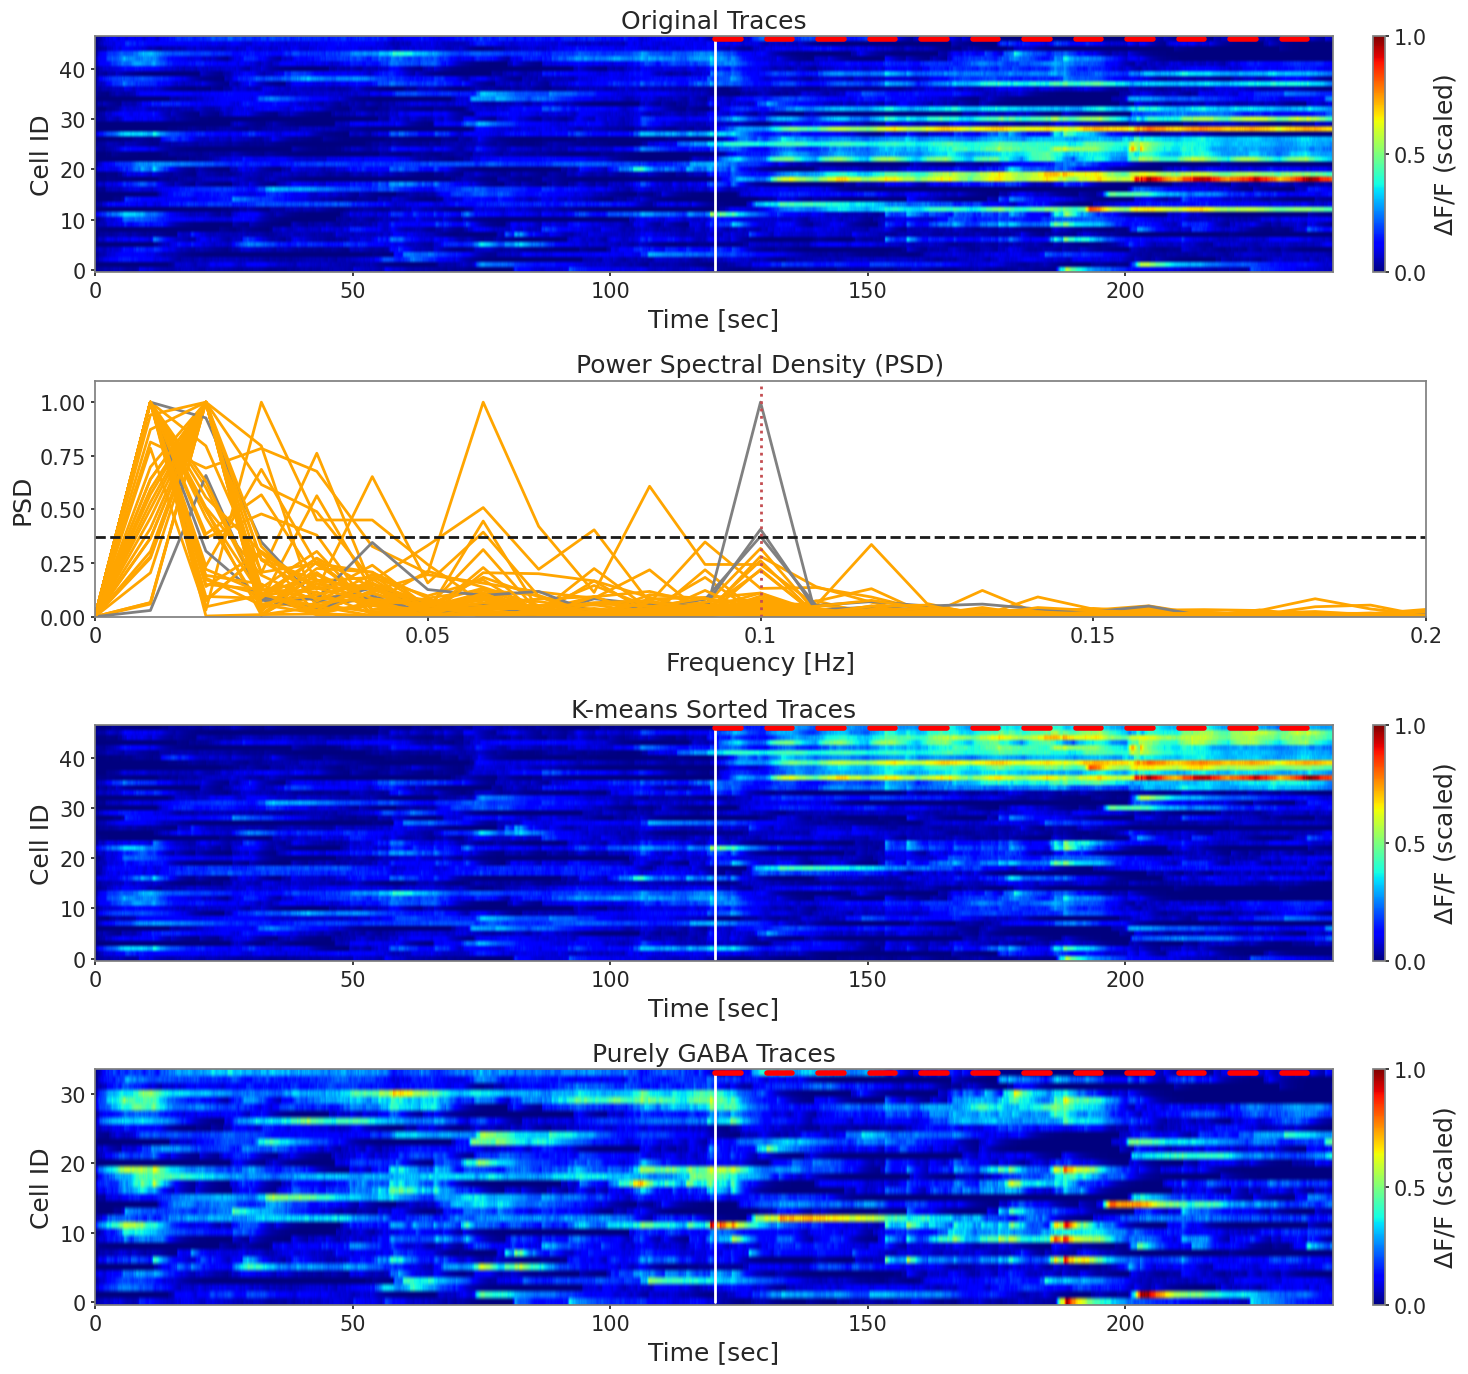

In [ ]:
# Set up the figure and subplots
plt.figure(figsize=(15, 14))

# Plot 1: Original traces
ax1 = plt.subplot(4, 1, 1)
scaled_data = min_max_norm(data_fig1_stim_artifact[:, :stim_offset])
plt.imshow(scaled_data, cmap='jet')
ax1.plot([1204, 1204], [0, total_cells_fig1_stim-1], '-w')
for i in range(1204, 2404, 100):
    ax1.plot([i, i+50], [total_cells_fig1_stim-1, total_cells_fig1_stim-1], '-', c='red', lw=4)
ax1.set_aspect('auto')
ax1.set_xlabel('Time [sec]')
ax1.set_ylabel('Cell ID')
ax1.invert_yaxis()
ax1.set_title('Original Traces')
ax1.set_xticks([0, 500, 1000, 1500, 2000])
ax1.set_xticklabels([0, 50, 100, 150, 200])

# Add colorbar
cmap = plt.get_cmap('jet')
sm = ScalarMappable(cmap=cmap)
sm.set_clim(vmin=0, vmax=1)
cb = plt.colorbar(cmap=cmap, fraction=0.04,
                  pad=0.03)  # set up proper size of the colourbar
cb.set_label('$\Delta$F/F (scaled)')
cb.set_ticks([0, 0.5, 1])


# Plot 2: Power Spectral Density (PSD)
ax2 = plt.subplot(4, 1, 2)
for i in range(total_cells_fig1_stim):
    freq, Pxx_den = periodogram(data_fig1_stim_artifact[i, stim_onset:stim_offset], fs)
    Pxx_den = Pxx_den / max(Pxx_den)  # Normalise PSD
    if Pxx_den[round(stimulus_freq * (stim_offset - stim_onset) / fs)] < PSD_thr:
        labels_removed_PSD.append(i)
        ax2.plot(freq, Pxx_den, c='orange')
    else:
        ax2.plot(freq, Pxx_den, c='gray')

# Add lines for stimulus frequency threshold
ax2.plot([0, 0.2], [0.37, 0.37], '--k')
ax2.plot([0.1, 0.1], [0, 1.1], ':r')
ax2.set_xlim([0, 0.2])
ax2.set_ylim([0, 1.1])
ax2.set_xlabel('Frequency [Hz]')
ax2.set_ylabel('PSD')
ax2.set_title('Power Spectral Density (PSD)')
ax2.set_xticks([0, 0.05, 0.1, 0.15, 0.2])
ax2.set_xticklabels([0, 0.05, 0.1, 0.15, 0.2])


# Plot 3: Traces sorted by K-means clustering
ax3 = plt.subplot(4, 1, 3)
plt.imshow(min_max_norm(data_fig1_stim_artifact[i_labels_artifact, :stim_offset]), cmap='jet')
ax3.plot([1204, 1204], [0, total_cells_fig1_stim-1], '-w')
for i in range(1204, 2404, 100):
    ax3.plot([i, i+50], [total_cells_fig1_stim-1, total_cells_fig1_stim-1], '-', c='red', lw=4)
ax3.set_aspect('auto')
ax3.set_xlabel('Time [sec]')
ax3.set_ylabel('Cell ID')
ax3.invert_yaxis()
ax3.set_title('K-means Sorted Traces')
ax3.set_xticks([0, 500, 1000, 1500, 2000])
ax3.set_xticklabels([0, 50, 100, 150, 200])

# Add colorbar
cmap = plt.get_cmap('jet')
sm = ScalarMappable(cmap=cmap)
sm.set_clim(vmin=0, vmax=1)
cb = plt.colorbar(cmap=cmap, fraction=0.04,
                  pad=0.03)  # set up proper size of the colourbar
cb.set_label('$\Delta$F/F (scaled)')
cb.set_ticks([0, 0.5, 1])


# Plot 4: Purely GABA Traces
ax4 = plt.subplot(4, 1, 4)
plt.imshow(min_max_norm(data_fig1_stim_tot[:, :stim_offset]), cmap='jet')
ax4.plot([1204, 1204], [0, n_cells_fig1_stim-1], '-w')
for i in range(1204, 2404, 100):
    ax4.plot([i, i+50], [n_cells_fig1_stim-1, n_cells_fig1_stim-1], '-', c='red', lw=4)
ax4.set_aspect('auto')
ax4.set_xlabel('Time [sec]')
ax4.set_ylabel('Cell ID')
ax4.invert_yaxis()
ax4.set_title('Purely GABA Traces')
ax4.set_xticks([0, 500, 1000, 1500, 2000])
ax4.set_xticklabels([0, 50, 100, 150, 200])

# Add colorbar
cmap = plt.get_cmap('jet')
sm = ScalarMappable(cmap=cmap)
sm.set_clim(vmin=0, vmax=1)
cb = plt.colorbar(cmap=cmap, fraction=0.04,
                  pad=0.03)  # set up proper size of the colourbar
cb.set_label('$\Delta$F/F (scaled)')
cb.set_ticks([0, 0.5, 1])

# Adjust layout and show the plot
plt.tight_layout()

# Save the figure (optional)
# plt.savefig("./gdrive/My Drive/FigS8.png", dpi=300)

plt.show()

# G28 (stress)

This is a example restraint stress trial for figure 1 from animal G28.

In [ ]:
# Load deconvoluted data and transpose the dataframe to make rows represent cells
data_fig1_stress = pd.read_csv(stress_fig1_csv_fname).T

# Strip any leading or trailing whitespace characters from the index names
data_fig1_stress.index = data_fig1_stress.index.str.strip()

# Display the last 5 rows of the dataframe to understand the structure
# You can use `tail(2)` to view the last two rows if needed
data_fig1_stress.tail(5)

0    1          2               3               4     \
C118   accepted    0   43.50841        41.66243        71.19485   
C119   accepted    0          0               0    3.051758e-05   
C120   accepted    0          0   -3.051758e-05   -3.051758e-05   
C121   accepted    0   284.4599        270.7258        257.6548   
C124   accepted    0          0   -6.103516e-05        45.02893   

                5              6          7          8          9     ...  \
C118        68.17417       65.28166   62.51187    59.8596      118.1  ...   
C119    3.051758e-05   3.051758e-05   16.29219   15.59044   184.5471  ...   
C120   -3.051758e-05       42.50839   40.71841   64.25385   109.3918  ...   
C121        245.2148       233.3755   222.1078   211.3841   201.1781  ...   
C124        43.09802       41.24994   103.4197   98.98492   118.9091  ...   

           5598       5599       5600       5601       5602       5603  \
C118   1470.904   1408.496   1370.514   1426.161   1435.159   1429.393   
C119   1415.359   1456.487   1393.753   1424.825   1363.454   1430.636   
C120   1392.933    1431.68    1445.64   1434.384   1418.948   1386.784   
C121   1027.536    1041.54   1154.067   1098.346   1219.537   1160.656   
C124   508.4524   518.7717    539.661   552.7736   529.0699   735.1755   

           5604       5605       5606       5607  
C118    1603.41    1535.38   1470.237   1407.857  
C119   1545.516   1578.892   1510.885   1445.808  
C120   1531.457   1466.969   1405.197   1346.025  
C121   1104.618   1051.285   1000.527   952.2205  
C124   703.6503   673.4768   644.5972   616.9561  

[5 rows x 5608 columns]

### Data Slicing

In [ ]:
# Extract fluorescence intensity data (excluding the first row and first column for metadata)
cells_traces_fig1_stress_tot = data_fig1_stress.iloc[1:, 1:]

# Get the number of cells and columns (time points, or other measurements) in the data
n_cells_fig1_stress, _ = cells_traces_fig1_stress_tot.shape

# Display the last 5 rows of the processed fluorescence intensity data
print(cells_traces_fig1_stress_tot.tail())

     1          2               3               4               5     \
C118    0   43.50841        41.66243        71.19485        68.17417   
C119    0          0               0    3.051758e-05    3.051758e-05   
C120    0          0   -3.051758e-05   -3.051758e-05   -3.051758e-05   
C121    0   284.4599        270.7258        257.6548        245.2148   
C124    0          0   -6.103516e-05        45.02893        43.09802   

               6          7          8          9          10    ...  \
C118       65.28166   62.51187    59.8596      118.1   202.4178  ...   
C119   3.051758e-05   16.29219   15.59044   184.5471   202.6298  ...   
C120       42.50839   40.71841   64.25385   109.3918   104.7854  ...   
C121       233.3755   222.1078   211.3841   201.1781    191.465  ...   
C124       41.24994   103.4197   98.98492   118.9091   125.1116  ...   

           5598       5599       5600       5601       5602       5603  \
C118   1470.904   1408.496   1370.514   1426.161   1435.159 

In [ ]:
# Convert temporal activity data (Pandas DataFrame) to numerical type (numpy arrays)
data_fig1_stress_tot = cells_traces_fig1_stress_tot.values.astype(float)

# Slice the data to separate the pre-stress (1) and stress (2) periods
data_fig1_stress_1 = data_fig1_stress_tot[:, :stress_onset]

data_fig1_stress_2 = data_fig1_stress_tot[:, stress_onset:stress_offset]

In [ ]:
# Rescale each trace (row-wise) to the min and max of the entire trace
normalised_data_fig1_stress_1 = minmax_scale(data_fig1_stress_1, axis=1)

In [ ]:
# Rescale each trace (row-wise) to the min and max of the entire trace (for the second segment of data)
normalised_data_fig1_stress_2 = minmax_scale(data_fig1_stress_2, axis=1)

### SLxCorr

In [ ]:
# Precompute the baseline correlation matrix for all pairs of cells (without the diagonal)
max_corr_fig1_stress_1 = np.zeros((n_cells_fig1_stress, n_cells_fig1_stress))

# Compute the lagged correlations, avoiding the diagonal (same cell comparisons)
for first in range(n_cells_fig1_stim):
    for second in range(first + 1, n_cells_fig1_stress):  # Only compute upper triangle
        corr = signed_lagged_corr(scale(normalised_data_fig1_stress_1[first, :]),
                                  scale(normalised_data_fig1_stress_1[second, :]))[0]
        max_corr_fig1_stress_1[first, second] = corr
        max_corr_fig1_stress_1[second, first] = corr  # Matrix is symmetric

In [ ]:
# Precompute the stimulation correlation matrix for all pairs of cells (without the diagonal)
max_corr_fig1_stress_2 = np.zeros((n_cells_fig1_stress, n_cells_fig1_stress))

# Compute the lagged correlations, avoiding the diagonal (same cell comparisons)
for first in range(n_cells_fig1_stim):
    for second in range(first + 1, n_cells_fig1_stress):  # Only compute upper triangle
        corr = signed_lagged_corr(scale(normalised_data_fig1_stress_2[first, :]),
                                  scale(normalised_data_fig1_stress_2[second, :]))[0]
        max_corr_fig1_stress_2[first, second] = corr
        max_corr_fig1_stress_2[second, first] = corr  # Matrix is symmetric

# Figure 1

In [ ]:
# Load p-values data
pvalues = pd.read_csv(pvalues_path)

# Display the top few rows
print("Top 5 rows of p-values:")
print(pvalues.head())

Top 5 rows of p-values:
          Xcorr           Cov Animal Intervention
0  6.600000e-08  2.640000e-05     G7  Stimulation
1  1.130000e-04  5.310000e-07     G7  Stimulation
2  2.180000e-26  8.890000e-17     G8  Stimulation
3  2.420000e-11  8.790000e-04     G8  Stimulation
4  2.540000e-01  2.540000e-01     G8  Stimulation


In [ ]:
# Assign the list of column names
categories_pvalues = pvalues.columns.tolist()

In [ ]:
# Drop NaN values from the 'Xcorr' column and convert it to a list
pvalues_corr = pvalues['Xcorr'].dropna().tolist()

# Define the ranges for grouping the correlation values
pvalues_pool_corr_stim = [
    pvalues_corr[0:2],       # First group: 0 to 2
    pvalues_corr[2:6],       # Second group: 2 to 6
    pvalues_corr[6:10],      # Third group: 6 to 10
    pvalues_corr[10:13],     # Fourth group: 10 to 13
    pvalues_corr[13:16],     # Fifth group: 13 to 16
    pvalues_corr[16:20]      # Sixth group: 16 to 20
]

# Same method applied for 'stress' related correlation groups
pvalues_pool_corr_stress = [
    pvalues_corr[20:21],     # First group: 20 to 21
    pvalues_corr[21:22],     # Second group: 21 to 22
    pvalues_corr[22:23],     # Third group: 22 to 23
    pvalues_corr[23:24],     # Fourth group: 23 to 24
    pvalues_corr[24:25],     # Fifth group: 24 to 25
    pvalues_corr[25:27]      # Sixth group: 25 to 27
]

/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:3399: UserWarning: 33.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:3399: UserWarning: 50.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:3399: UserWarning: 33.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:3399: UserWarning: 50.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


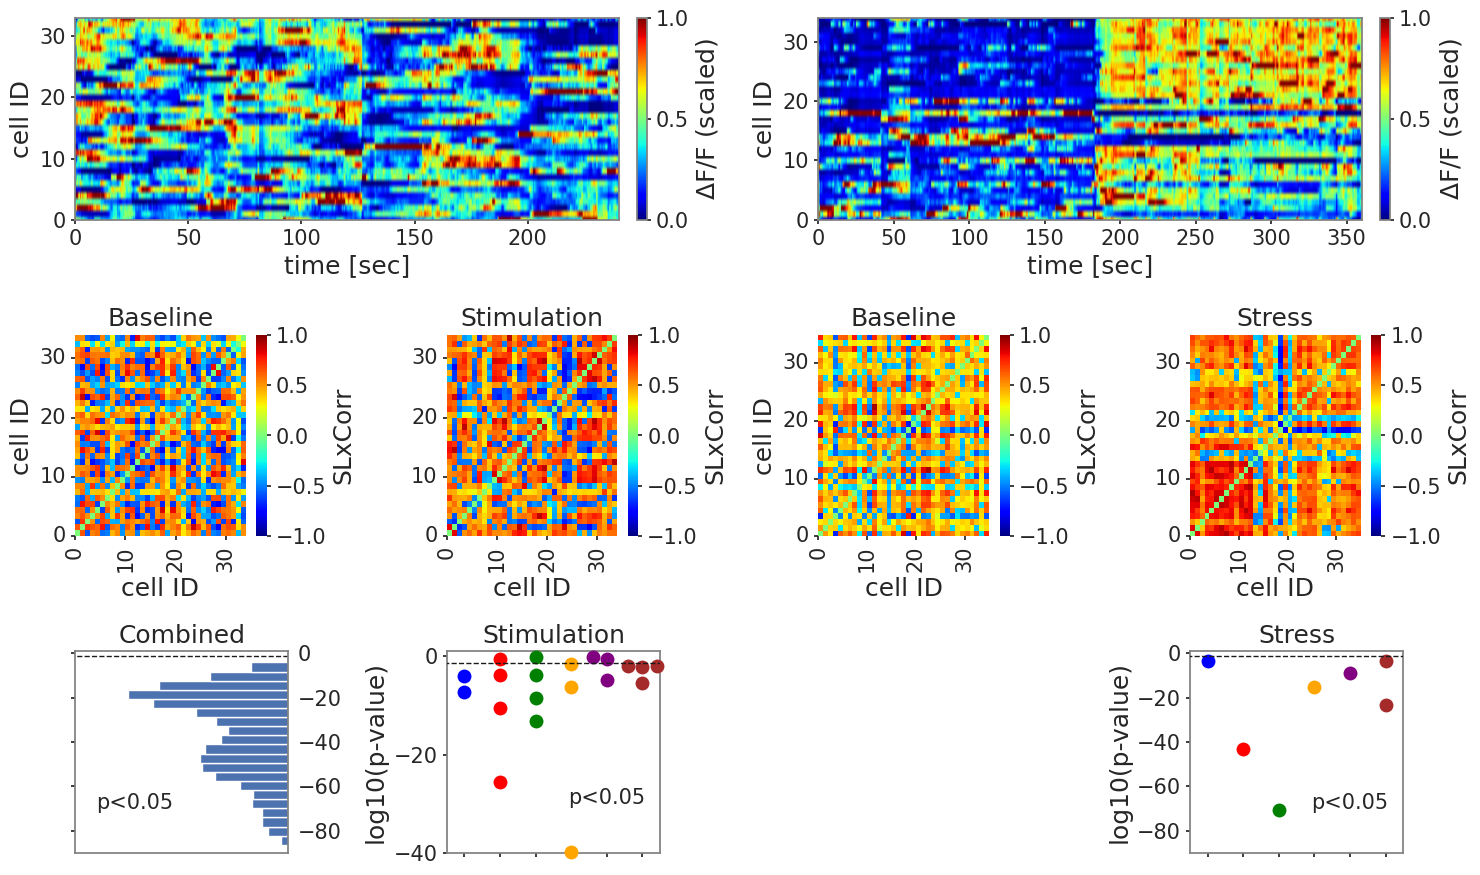

In [ ]:
# Create a figure with specific dimensions
fig = plt.figure(figsize=(15, 9))

# Set up the grid layout for subplots
gs = gridspec.GridSpec(3, 4, figure=fig)

# First subplot - Stimulus Data (Baseline)
ax = fig.add_subplot(gs[0:2])
stim_data = minmax_scale(scale(data_fig1_stim_tot[:, :stim_offset], axis=1), axis=0)
plt.imshow(stim_data, cmap='jet', interpolation='auto')

# Set axis limits and ticks for clarity
ax.set_xlim(0, stim_offset)
ax.set_ylim(0, n_cells_fig1_stim-1)
ax.set_xticks(np.arange(0, 2500, 500))
ax.set_xticklabels(np.arange(0, 250, 50))
ax.set_yticks([_ for _ in list(range(n_cells_fig1_stim)) if _ % 10 == 0])
ax.set_yticklabels([_ for _ in list(range(n_cells_fig1_stim)) if _ % 10 == 0])
ax.set_ylabel('cell ID')
ax.set_xlabel('time [sec]')
ax.set_aspect('auto')

# Add colorbar
cmap = plt.get_cmap('jet')
sm = ScalarMappable(cmap=cmap)
sm.set_clim(vmin=0, vmax=1)
cb = plt.colorbar(cmap=cmap, fraction=0.04,
                  pad=0.03)  # set up proper size of the colourbar
cb.set_label('$\Delta$F/F (scaled)')

# Second subplot - Stress Data (Stress Onset)
ax = fig.add_subplot(gs[2:4])
stress_data = minmax_scale(scale(data_fig1_stress_tot[:, :stress_offset], axis=1), axis=0)
plt.imshow(stress_data, cmap='jet')

# Set axis limits and ticks for clarity
ax.set_xlim(0, stress_offset)
ax.set_ylim(0, n_cells_fig1_stress-1)
ax.set_xticks(np.arange(0, 4000, 500))
ax.set_xticklabels(np.arange(0, 400, 50))
ax.set_yticks([_ for _ in list(range(n_cells_fig1_stress)) if _ % 10 == 0])
ax.set_yticklabels([_ for _ in list(range(n_cells_fig1_stress)) if _ % 10 == 0])
ax.set_ylabel('cell ID')
ax.set_xlabel('time [sec]')
ax.set_aspect('auto')

# Add colorbar
cmap = plt.get_cmap('jet')
sm = ScalarMappable(cmap=cmap)
sm.set_clim(vmin=0, vmax=1)
cb = plt.colorbar(cmap=cmap, fraction=0.04,
                  pad=0.03)  # set up proper size of the colourbar
cb.set_label('$\Delta$F/F (scaled)')

# Third subplot - Heatmap for Max Correlation (Baseline)
ax = fig.add_subplot(gs[4])
sns.heatmap(max_corr_fig1_stim_1, cbar_kws={'label': 'SLxCorr'}, cmap='jet', vmin=-1, vmax=1)
ax.set_title('Baseline')
ax.set(xlabel='cell ID', ylabel='cell ID')
ax.set_xticks([_ for _ in list(range(n_cells_fig1_stress)) if _ % 10 == 0])
ax.set_xticklabels([_ for _ in list(range(n_cells_fig1_stress)) if _ % 10 == 0])
ax.set_yticks([_ for _ in list(range(n_cells_fig1_stress)) if _ % 10 == 0])
ax.set_yticklabels([_ for _ in list(range(n_cells_fig1_stress)) if _ % 10 == 0])
ax.invert_yaxis()

# Fourth subplot - Heatmap for Max Correlation (Stimulation)
ax = fig.add_subplot(gs[5])
sns.heatmap(max_corr_fig1_stim_2, cbar_kws={'label': 'SLxCorr'}, cmap='jet', vmin=-1, vmax=1)
ax.set_title('Stimulation')
ax.set(xlabel='cell ID')
ax.set_xticks([_ for _ in list(range(n_cells_fig1_stress)) if _ % 10 == 0])
ax.set_xticklabels([_ for _ in list(range(n_cells_fig1_stress)) if _ % 10 == 0])
ax.set_yticks([_ for _ in list(range(n_cells_fig1_stress)) if _ % 10 == 0])
ax.set_yticklabels([_ for _ in list(range(n_cells_fig1_stress)) if _ % 10 == 0])
ax.invert_yaxis()

# Fifth subplot - Heatmap for Max Correlation (Stress)
ax = fig.add_subplot(gs[6])
sns.heatmap(max_corr_fig1_stress_1, cbar_kws={'label': 'SLxCorr'}, cmap='jet', vmin=-1, vmax=1)
ax.set_title('Baseline')
ax.set(xlabel='cell ID', ylabel='cell ID')
ax.set_xticks([_ for _ in list(range(n_cells_fig1_stress)) if _ % 10 == 0])
ax.set_xticklabels([_ for _ in list(range(n_cells_fig1_stress)) if _ % 10 == 0])
ax.set_yticks([_ for _ in list(range(n_cells_fig1_stress)) if _ % 10 == 0])
ax.set_yticklabels([_ for _ in list(range(n_cells_fig1_stress)) if _ % 10 == 0])
ax.invert_yaxis()

# Sixth subplot - Heatmap for Max Correlation (Stress)
ax = fig.add_subplot(gs[7])
sns.heatmap(max_corr_fig1_stress_2, cbar_kws={'label': 'SLxCorr'}, cmap='jet', vmin=-1, vmax=1)
ax.set_title('Stress')
ax.set(xlabel='cell ID')
ax.set_xticks([_ for _ in list(range(n_cells_fig1_stress)) if _ % 10 == 0])
ax.set_xticklabels([_ for _ in list(range(n_cells_fig1_stress)) if _ % 10 == 0])
ax.set_yticks([_ for _ in list(range(n_cells_fig1_stress)) if _ % 10 == 0])
ax.set_yticklabels([_ for _ in list(range(n_cells_fig1_stress)) if _ % 10 == 0])
ax.invert_yaxis()

# Seventh subplot - Histogram of combined p-values (log10)
ax = fig.add_subplot(gs[8])
df = fisher_combine_pvalues(pvalues_pool_corr_stim)
df = np.log10(df)
ax.hist(df, bins=20, orientation='horizontal')
ax.plot([0, 180], [np.log10(0.05), np.log10(0.05)], 'k--', lw=1)

ax.set_title('Combined')
ax.set_xticks([])
ax.set_yticks([-80, -60, -40, -20, 0])
ax.set_xlim([180, 0])
ax.set_ylim(-90, 1)
ax.tick_params(axis='y', labelright=True, labelleft=False)
ax.text(130, -70, 'p<0.05', ha='center')

# Eighth subplot - Swarm plot for stimulation p-values
colour_list = ['blue', 'red', 'green', 'orange', 'purple', 'brown']
ax = fig.add_subplot(gs[9])
for i in range(6):
    pvals = [np.log10(_) for _ in pvalues_pool_corr_stim[i]]
    df = pd.DataFrame(dict(x=np.repeat([i], len(pvals)), y=pvals))
    sns.swarmplot(x='x', y='y', data=df, color=colour_list[i], size=10, clip_on=False)

ax.plot([-1, 6], [np.log10(0.05), np.log10(0.05)], 'k--', lw=1, zorder=20)
ax.set_title('Stimulation')
ax.set_xlim(-0.5, 5.5)
ax.set_ylim(-40, 1)
ax.set_xlabel('')
ax.set_ylabel('log10(p-value)')
ax.yaxis.set_label_position("left")
ax.set_xticks([0, 1, 2, 3, 4, 5], labels=[], rotation=90)
ax.set_yticks([-40, -20, 0])
ax.tick_params(axis='y', labelright=False, labelleft=True)
ax.text(4, -30, 'p<0.05', ha='center')

# Ninth subplot - Swarm plot for stress p-values
ax = fig.add_subplot(gs[11])
for i in range(6):
    pvals = [np.log10(_) for _ in pvalues_pool_corr_stress[i]]
    df = pd.DataFrame(dict(x=np.repeat([i], len(pvals)), y=pvals))
    sns.swarmplot(x='x', y='y', data=df, color=colour_list[i], size=10)

ax.plot([-1, 6], [np.log10(0.05), np.log10(0.05)], 'k--', lw=1, zorder=20)
ax.set_title('Stress')
ax.set_xlim(-0.5, 5.5)
ax.set_ylim(-90, 1)
ax.set_xlabel('')
ax.set_ylabel('log10(p-value)')
ax.yaxis.set_label_position("left")
ax.set_xticks([0, 1, 2, 3, 4, 5], labels=[], rotation=90)
ax.set_yticks([-80, -60, -40, -20, 0])
ax.tick_params(axis='y', labelright=False, labelleft=True)
ax.text(4, -70, 'p<0.05', ha='center')

# Adjust layout for better spacing
plt.tight_layout()

# Save the figure (optional)
# plt.savefig('./gdrive/My Drive/Fig1.png', dpi=300)

# Show the plot
plt.show()

# G28 (stim.)

An example of data analysis pipline for stimulation experimental setup.

In [ ]:
# Load convoluted data and transpose the dataframe
data_stim = pd.read_csv(stim_csv_fname).T

# Strip any leading or trailing whitespace characters from the index names
data_stim.index = data_stim.index.str.strip()

# Display the last few rows to understand the structure of the data
# Use `tail(2)` if you want to see only the bottom 2 rows
data_stim.tail(5)

0    1          2              3          4              5     \
C094   accepted    0          0   6.103516e-05          0   6.103516e-05   
C096   accepted    0   643.9747       1173.457   1472.662       1574.646   
C103   accepted    0    51.0127       178.9229   170.0222       287.7782   
C105   accepted    0   200.9243        191.496   182.5101       173.9458   
C107   accepted    0          0       20.12329   116.3702       110.9654   

               6              7              8              9     ...  \
C094   6.103516e-05   6.103516e-05   6.103516e-05   6.103516e-05  ...   
C096        1541.89       1470.428       1431.547       1488.959  ...   
C103       586.1436       556.9858       529.2788       556.7461  ...   
C105       165.7835       158.0041       150.5898       143.5234  ...   
C107       105.8116       100.8972       96.21104       91.74251  ...   

           4296       4297       4298       4299       4300       4301  \
C094   704.7659   750.5431   708.8228   700.9659   952.5929    1107.16   
C096   847.2992   979.4389   931.9738    886.809   843.8329   802.9395   
C103   1755.769   1668.429   1585.433   1506.566   1431.623   1494.466   
C105   1272.222   1212.524   1155.626   1133.084   1079.914   1099.959   
C107   205.7807    373.305   449.5083   546.0685   592.2088   564.7036   

           4302       4303       4304       4305  
C094   1075.415   1578.796   1491.036   1408.154  
C096   764.0279   727.0019   691.7703   658.2461  
C103   1420.124   1349.481   1282.351   1218.561  
C105   1285.939   1225.597   1168.086   1113.274  
C107   710.1234   934.0911   890.7072   849.3382  

[5 rows x 4306 columns]

## Data Slicing

In [ ]:
# Slice the deconvoluted data to obtain fluorescence intensity values
# Remove the first row and column, as they represent metadata
cells_traces_tot_old = data_stim.iloc[1:, 1:]

# Get the shape of the sliced data (number of cells and length of data for each cell)
total_cells_stim, data_stim_length_tot = cells_traces_tot_old.shape

# Display the last few rows of the sliced data for inspection
cells_traces_tot_old.tail()

1          2              3          4              5              6     \
C094    0          0   6.103516e-05          0   6.103516e-05   6.103516e-05   
C096    0   643.9747       1173.457   1472.662       1574.646        1541.89   
C103    0    51.0127       178.9229   170.0222       287.7782       586.1436   
C105    0   200.9243        191.496   182.5101       173.9458       165.7835   
C107    0          0       20.12329   116.3702       110.9654       105.8116   

               7              8              9              10    ...  \
C094   6.103516e-05   6.103516e-05   6.103516e-05   6.103516e-05  ...   
C096       1470.428       1431.547       1488.959       1416.802  ...   
C103       556.9858       529.2788       556.7461       581.2056  ...   
C105       158.0041       150.5898       143.5234       136.7886  ...   
C107       100.8972       96.21104       91.74251       87.48152  ...   

           4296       4297       4298       4299       4300       4301  \
C094   704.7659   750.5431   708.8228   700.9659   952.5929    1107.16   
C096   847.2992   979.4389   931.9738    886.809   843.8329   802.9395   
C103   1755.769   1668.429   1585.433   1506.566   1431.623   1494.466   
C105   1272.222   1212.524   1155.626   1133.084   1079.914   1099.959   
C107   205.7807    373.305   449.5083   546.0685   592.2088   564.7036   

           4302       4303       4304       4305  
C094   1075.415   1578.796   1491.036   1408.154  
C096   764.0279   727.0019   691.7703   658.2461  
C103   1420.124   1349.481   1282.351   1218.561  
C105   1285.939   1225.597   1168.086   1113.274  
C107   710.1234   934.0911   890.7072   849.3382  

[5 rows x 4305 columns]

In [ ]:
# Create time axis from the first row of the data (excluding the first element, which is a label)
ts_stim_tot = np.asarray(data_stim.iloc[0, 1:], dtype=float)

# Calculate the time between frames from the second timestamp (in seconds)
sec_per_frame = ts_stim_tot[1]

# Calculate the sampling frequency (inverse of the time between frames)
fs = 1 / sec_per_frame  # Sampling frequency in Hz

In [ ]:
# Convert the temporal activity data from pandas DataFrame to a NumPy array for numerical operations
data_stim_artifact = np.asarray(cells_traces_tot_old, dtype=float)

## Finding UCN3 Cells

### PSD

In [ ]:
# Define the stimulus frequency and initialise a list to store labels of removed cells based on PSD threshold
stimulus_freq = 0.1  # Stimulus frequency in Hz
labels_removed_PSD = []

# Loop through each cell to calculate the power spectral density (PSD)
for i in range(total_cells_stim):
    # Compute the periodogram (PSD) for the temporal data during stimulation period
    freq, Pxx_den = periodogram(
        data_stim_artifact[i, stim_onset:stim_offset], fs)

    # Normalise the PSD by its maximum value
    Pxx_den = Pxx_den / max(Pxx_den)

    # Check if the PSD value at the stimulus frequency exceeds the threshold
    # The index for the frequency is calculated as round(stimulus_freq * (stim_offset - stim_onset) / fs)
    stimulus_freq_idx = round(stimulus_freq * (stim_offset - stim_onset) / fs)
    if Pxx_den[stimulus_freq_idx] > PSD_thr:
        # Add the cell index to the list if it passes the threshold
        labels_removed_PSD.append(i)

# Print the indices of cells removed based on the PSD threshold
print("Indices of cells removed based on PSD threshold:", labels_removed_PSD)

Indices of cells removed based on PSD threshold: [13, 18, 25, 33]


In [ ]:
# Create a binary mask indicating artifact cells
# Assign 0 if the cell label is in labels_removed, otherwise assign 1
labels_artifact = np.asarray(
    [0 if cell in labels_removed else 1 for cell in range(total_cells_stim)]
)

# Uncomment the following line to print the resulting binary mask if needed
# print(labels_artifact)

### K-means

In [ ]:
# apply scikit-learn K-means clustering to sort activity traces

# Scale the activity data for clustering
scaled_data = scale(data_stim_artifact[:, stim_onset:stim_offset], axis=0)

# Set the number of clusters for K-means
Ks = 2

# K-means relies on random number generation for initialization;
# we fix the seed with `random_state` to ensure reproducibility.
km = KMeans(
    n_clusters=Ks,         # Number of clusters
    random_state=11111,    # Seed for reproducibility
    n_init=10,             # Number of different centroid seeds to try
    max_iter=100           # Maximum number of iterations per run
).fit(scale(data_stim_artifact[:, stim_onset:stim_offset], axis=0))  # Scale data along features (cells)

# Retrieve cluster labels
labels_artifact_KM = km.labels_          # Cluster labels for each cell

# Sort the indices of cells by their cluster labels
i_labels_artifact = np.argsort(labels_artifact_KM)

# Uncomment the following line if needed to see the sorted labels
print("Indices Sorted by Cluster Labels:\n", i_labels_artifact)

Indices Sorted by Cluster Labels:
 [ 0 24 26 27 28 29 30 31 32 34 35 36 37 38 39 40 41 42 43 44 45 22 23 20
  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 19 21 46 33 18 25]


In [ ]:
# Determine which cluster to be removed based on size
size_cluster_0 = len(data_stim_artifact[labels_artifact_KM == 0])
size_cluster_1 = len(data_stim_artifact[labels_artifact_KM == 1])

if size_cluster_0 < size_cluster_1:
    cluster_removed = 0
    cluster_kept = 1
    print('Cluster #1 (smaller) is removed.')
elif size_cluster_1 != 0:
    cluster_removed = 1
    cluster_kept = 0
    print('Cluster #2 (smaller) is removed.')
else:
    print("No valid cluster for removal.")

Cluster #2 (smaller) is removed.


In [ ]:
# Update labels_artifact for traces in the removed cluster
if len(data_stim_artifact[labels_artifact_KM == cluster_removed]) != 0:
    for i in range(len(data_stim_artifact)):
        if labels_artifact[i] == 1 and labels_artifact_KM[i] == cluster_removed:
            labels_artifact[i] = 0

# Specify which cluster is removed and kept
cluster_removed = 0
cluster_kept = 1

# Identify indices of cells to be removed
labels_removed = np.where(labels_artifact == cluster_removed)[0]

# Print results (optional for debugging)
print(f"Number of (UCN) cells removed: {len(labels_removed)}")
print(f"Indices of removed cells: {labels_removed}")

Number of (UCN) cells removed: 14
Indices of removed cells: [12 18 19 22 23 24 25 26 28 30 32 33 37 39]


In [ ]:
# Identify row labels for removal based on `labels_removed`
removed_row_labels = cells_traces_tot_old.index[labels_removed]

# Remove resonated cells from fluorescence intensity traces
cells_traces_stim_tot = cells_traces_tot_old.drop(
    removed_row_labels, axis=0, inplace=False)

# Calculate the number of remaining cells
n_cells_stim = len(cells_traces_stim_tot)

# Optional: Print the number of remaining cells
print(f"Number of GABA cells: {n_cells_stim}")

Number of GABA cells: 33


## Minmax Scaling over each trace

In [ ]:
# Convert temporal activity data from pandas DataFrame to numpy arrays with float data type
data_stim_tot = np.asarray(cells_traces_stim_tot, dtype=float)          # Deconvoluted data

In [ ]:
# Rescale each trace to its minimum and maximum values across its entire length

# Deconvoluted data: normalised to a range [0, 1]
normalised_data_stim_tot = minmax_scale(data_stim_tot, axis=1)

## **Stimulated**

Hereafter, I only focus on the data while the stimulation is applied at 2 minutes after starting recording with 0.1 Hz (5 s on followed by 5 s off).

### Data Slicing

In [ ]:
# Slice the data during the stimulation period based on `stim_onset` and `stim_offset`

# Fluorescence intensity (deconvoluted and raw)
cells_traces_stim_2 = cells_traces_stim_tot.iloc[:, stim_onset:stim_offset]  # Deconvoluted data

# Normalised fluorescence intensity (deconvoluted and raw)
normalised_data_stim_2 = normalised_data_stim_tot[:, stim_onset:stim_offset]  # Deconvoluted normalised data

# Update the data length during stimulation
data_stim_length_2 = cells_traces_stim_2.shape[1]

# Display the first few rows of the deconvoluted fluorescence data during stimulation
cells_traces_stim_2.head()

1205       1206       1207       1208       1209       1210  \
C000   9.610781   9.109393   8.634162   8.183723   7.756784   7.352118   
C001   51.14697   48.14611   45.32131   42.66225   40.15919     37.803   
C002   161.9082   152.0339   142.7617   134.0551   125.8794   118.2023   
C003   96.05541   91.40376   86.97738   82.76535   78.75729   74.94334   
C004   525.4421   667.9557   634.5085   602.7361   641.6688   711.6713   

           1211       1212       1213       1214  ...       2395       2396  \
C000   6.968563   6.605018   6.260438   212.7549  ...    681.997   646.4177   
C001   35.58505   33.49723    31.5319   29.68188  ...   510.3558   480.4125   
C002   110.9935   104.2243   97.86794   91.89923  ...   347.8694   326.6537   
C003   71.31407   67.86057    64.5743   61.44717  ...   593.0775   645.7643   
C004   676.0351   642.1833    718.572   840.8339  ...   454.1858   488.2891   

           2397       2398       2399       2400       2401       2402  \
C000   701.6332    690.388   754.6913   838.5499   794.8033   810.6327   
C001    452.226   425.6933   437.5678   463.4797   436.2867   410.6892   
C002    306.732   288.0252   270.4593   253.9647   238.4761   223.9321   
C003   792.8328   783.1747   785.0201   747.0042   836.3228   795.8224   
C004   598.3847   568.4211   586.6035   557.2299   551.1138   658.4133   

           2403       2404  
C000   778.7357   791.5369  
C001   386.5935   363.9115  
C002    210.275   197.4509  
C003   976.7411   1058.116  
C004   728.7188   740.4006  

[5 rows x 1200 columns]

In [ ]:
# Create time axis for the stimulation period
# Slice the time axis array `ts_stim_tot` to match the stimulation window defined by `stim_onset` and `stim_offset`
ts_stim_2 = ts_stim_tot[stim_onset:stim_offset]

In [ ]:
# Convert temporal activity data from pandas DataFrame to numerical NumPy arrays
data_stim_2 = np.asarray(cells_traces_stim_2, dtype=float)

### Clustering

#### Hierarchical (cov)

In [ ]:
# Calculate pairwise covariance distance
# - `pdist` computes the pairwise distances between rows of a matrix.
# - `scale(normalised_data_stim_2, axis=1)` ensures each trace is normalized before calculating covariance.
# - The lambda function computes the covariance between two traces, subtracting it from 1 to define the distance.

dist_cov_stim_2 = pdist(
    scale(normalised_data_stim_2, axis=1),
    lambda x, y: 1 - np.cov(x, y, bias=True)[0, 1]
)

# `dist_cov_stim_2` is a condensed distance matrix representing covariance-based distances between traces.

In [ ]:
# Apply hierarchical clustering to sort activity traces
# - AgglomerativeClustering performs hierarchical clustering.
# - `n_clusters=Ks_2` specifies the number of clusters.
# - `metric='precomputed'` indicates that the distance matrix has already been computed (i.e., `dist_cov_stim_2`).
# - `linkage='average'` uses the average linkage criterion for merging clusters.
# - `compute_distances=True` ensures that the pairwise distances are computed during the clustering process.
# - `squareform(dist_cov_stim_2)` converts the condensed distance matrix back to a square form, which is required by AgglomerativeClustering.

ac = AgglomerativeClustering(
    n_clusters=Ks_2,                 # Number of clusters
    metric='precomputed',            # Use precomputed distance matrix
    linkage='average',               # Average linkage criterion
    compute_distances=True           # Compute pairwise distances
).fit(squareform(dist_cov_stim_2))   # Convert condensed distance matrix to square form

# Retrieve the cluster labels assigned to each trace
labels_hier_cov_stim_2 = ac.labels_

# `labels_hier_cov_stim_2` contains the cluster assignment for each trace.

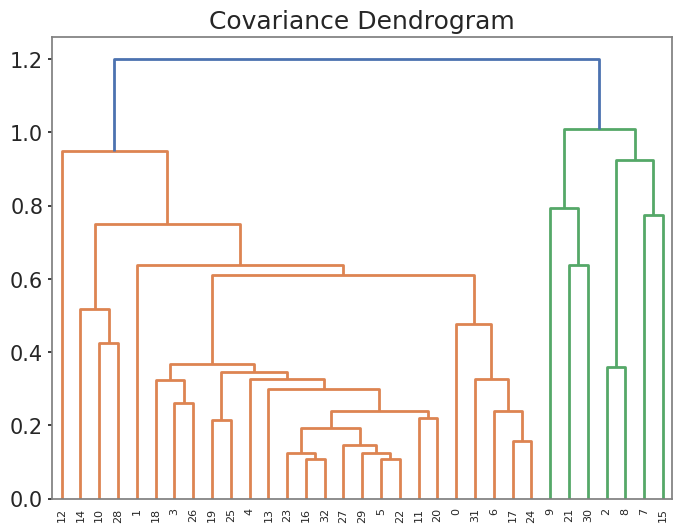

In [ ]:
# Hierarchical clustering via covariance
plt.figure(figsize=(8, 6))  # Set the size of the figure

# Compute linkage matrix from the agglomerative clustering object
# `compute_linkage` is used to extract the linkage matrix for the dendrogram
Z = compute_linkage(ac)

# Create and plot the dendrogram
dendrogram(
    Z,                                       # Linkage matrix
    orientation='top',                       # Place the branches at the top
    leaf_rotation=90,                        # Rotate the leaf labels by 90 degrees
    color_threshold=ac.distances_[-1] - 0.1  # Set the color threshold for clusters (a little below the max distance)
)

# Add a title to the plot
plt.title('Covariance Dendrogram')

# Display the plot
plt.show()

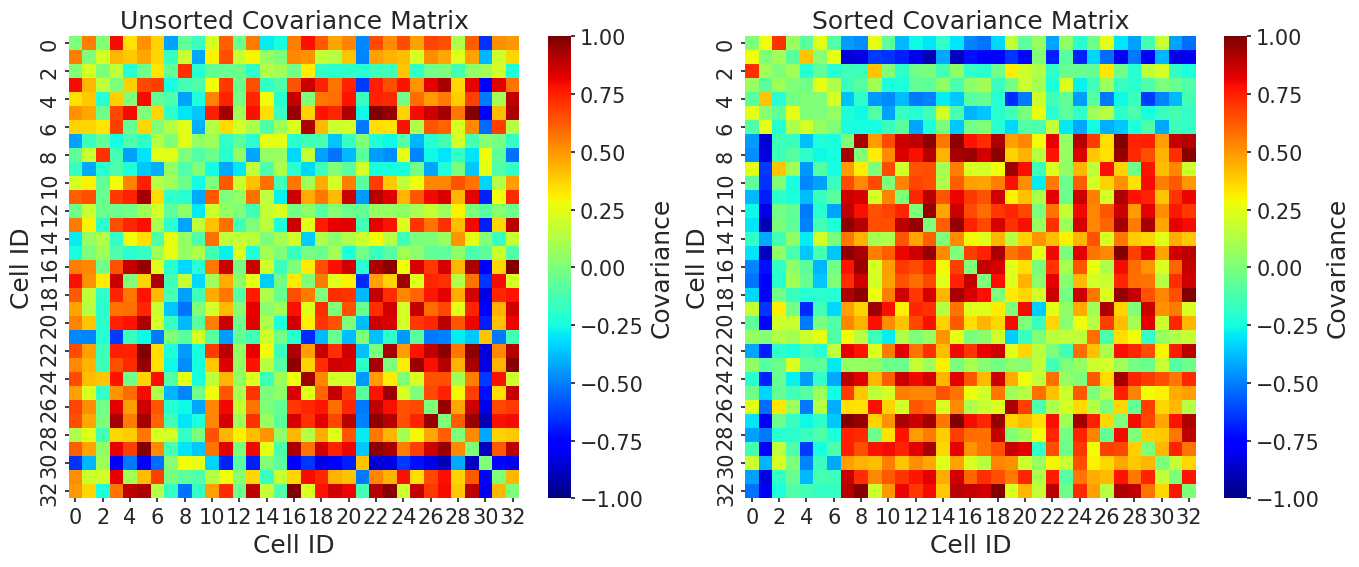

In [ ]:
# Compute covariance matrix for the stimulation data
cov_stim_2 = np.cov(scale(normalised_data_stim_2, axis=1), bias=True)

# Mask the diagonal to avoid self-covariance, setting it to zero
# The matrix 'temp' is a ones matrix with zeros on the diagonal
temp = np.ones(n_cells_stim) - np.eye(n_cells_stim)
cov_stim_2 = np.multiply(cov_stim_2, temp)

# Sort the covariance matrix based on hierarchical clustering labels
idx = np.argsort(labels_hier_cov_stim_2)

# Plotting the unsorted and sorted covariance matrices side by side
plt.figure(figsize=(16, 6))

# Plot the unsorted covariance matrix
plt.subplot(1, 2, 1)
ax1 = sns.heatmap(cov_stim_2 / np.max(abs(cov_stim_2)),
                  cbar_kws={'label': 'Covariance'},
                  cmap='jet', vmin=-1, vmax=1)
ax1.set_title('Unsorted Covariance Matrix')
ax1.set(xlabel='Cell ID', ylabel='Cell ID')

# Plot the sorted covariance matrix (sorted by hierarchical clustering labels)
plt.subplot(1, 2, 2)
ax2 = sns.heatmap(cov_stim_2[idx, :][:, idx] / np.max(abs(cov_stim_2)),
                  cbar_kws={'label': 'Covariance'},
                  cmap='jet', vmin=-1, vmax=1)
ax2.set_title('Sorted Covariance Matrix')
ax2.set(xlabel='Cell ID', ylabel='Cell ID')

# Display the plot
plt.show()

In [ ]:
# Calculate the silhouette score for hierarchical clustering
sil_score = silhouette_score(squareform(dist_cov_stim_2), labels_hier_cov_stim_2, metric="precomputed")

# Print the silhouette score
print(f'Silhouette score: {sil_score:.3f}')

Silhouette score: 0.469


#### K-means (cov)

In [ ]:
# Apply scikit-learn K-means clustering to the covariance distance matrix
# Fix the random seed for reproducibility and set the number of clusters (Ks_2)
km = KMeans(n_clusters=Ks_2, random_state=11112, n_init=10, max_iter=100)

# Fit the model on the squared form of the covariance distance matrix
km.fit(squareform(dist_cov_stim_2))

# Get the labels for the clusters assigned to each cell
labels_cov_stim_2 = km.labels_

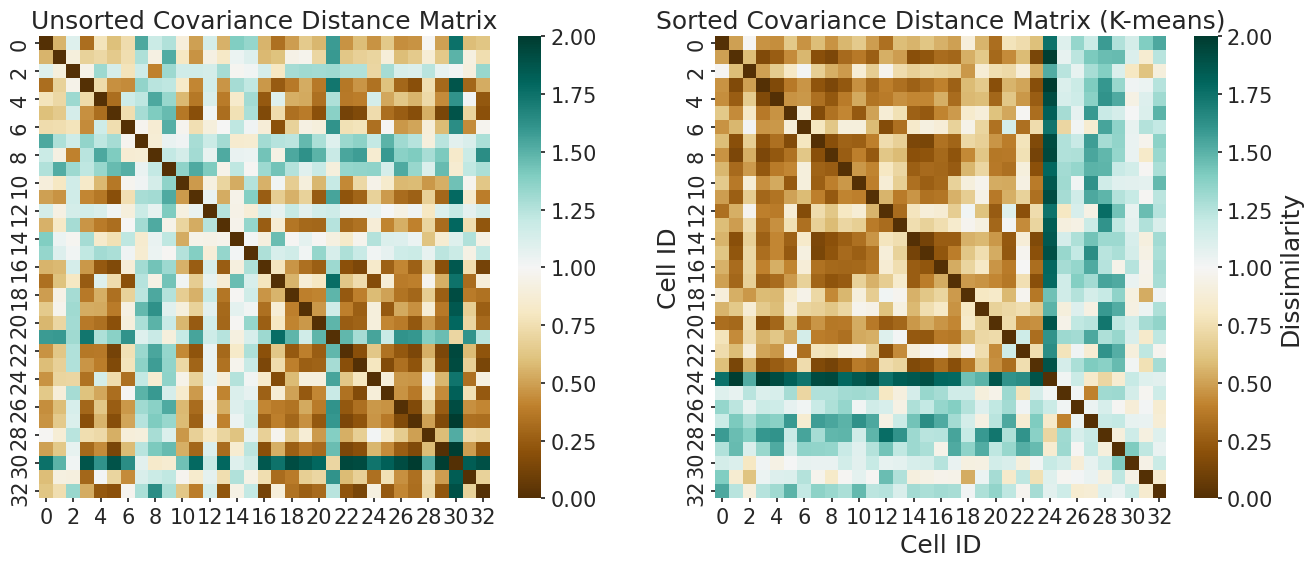

In [ ]:
# Plotting the unsorted and sorted (covariance, K-means) distance matrices
plt.figure(figsize=(16, 6))

# Subplot 1: Unsorted covariance distance matrix
plt.subplot(1, 2, 1)
sns.heatmap(2 * min_max_norm(squareform(dist_cov_stim_2)), cmap='BrBG')
plt.title('Unsorted Covariance Distance Matrix')

# Subplot 2: Sorted covariance distance matrix based on K-means labels
plt.subplot(1, 2, 2)
# Sorting the covariance distance matrix based on the K-means cluster labels
idx = np.argsort(labels_cov_stim_2)  # Sort indices by K-means labels
sorted_cov_dist = squareform(dist_cov_stim_2)[idx, :][:, idx]  # Apply sorting
ax = sns.heatmap(2 * min_max_norm(sorted_cov_dist),
                 cmap='BrBG', cbar_kws={'label': 'Dissimilarity'})
ax.set(xlabel='Cell ID', ylabel='Cell ID')
plt.title('Sorted Covariance Distance Matrix (K-means)')

# Show the plot
plt.show()

#### Hierarchical (cor)

In [ ]:
# Pairwise correlation distance calculation using signed lagged correlation
# - `pdist` computes pairwise distances for the normalized data `normalised_data_stim_2`.
# - The lambda function computes the distance as `1 - signed_lagged_corr(x, y)[0]` for each pair of activity traces.
# - The `scale(normalised_data_stim_2, axis=1)` standardises the traces by centering and scaling each trace across cells.

dist_corr_stim_2 = pdist(scale(normalised_data_stim_2, axis=1),
                         lambda x, y: 1 - signed_lagged_corr(x, y)[0])

# `dist_corr_stim_2` is a condensed distance matrix representing covariance-based distances between traces.

In [ ]:
# Apply hierarchical clustering to sort activity traces
# - AgglomerativeClustering performs hierarchical clustering.
# - `n_clusters=Ks_2` specifies the number of clusters.
# - `metric='precomputed'` indicates that the distance matrix has already been computed (i.e., `dist_cov_stim_2`).
# - `linkage='average'` uses the average linkage criterion for merging clusters.
# - `compute_distances=True` ensures that the pairwise distances are computed during the clustering process.
# - `squareform(dist_cov_stim_2)` converts the condensed distance matrix back to a square form, which is required by AgglomerativeClustering.

ac = AgglomerativeClustering(
    n_clusters=Ks_2,                 # Number of clusters
    metric='precomputed',            # Use precomputed distance matrix
    linkage='average',               # Average linkage criterion
    compute_distances=True           # Compute pairwise distances
).fit(squareform(dist_corr_stim_2))   # Convert condensed distance matrix to square form

# Retrieve the cluster labels assigned to each trace
labels_hier_stim_2 = ac.labels_

# `labels_hier_cov_stim_2` contains the cluster assignment for each trace.

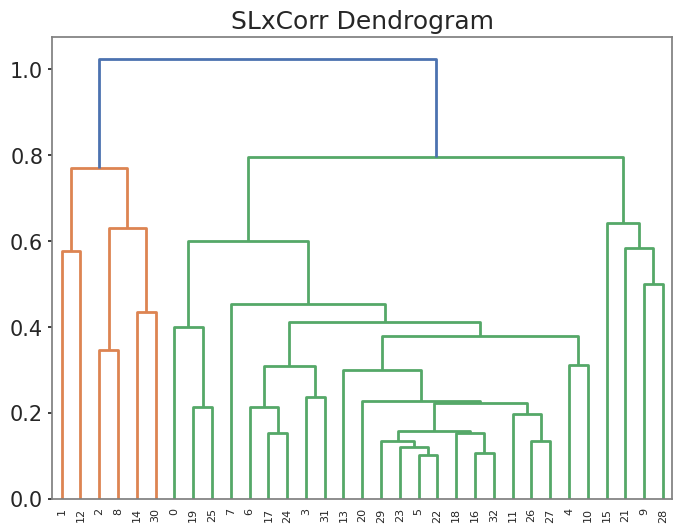

In [ ]:
# Hierarchical clustering via SLxCorr
plt.figure(figsize=(8, 6))  # Set the size of the figure

# Compute linkage matrix from the agglomerative clustering object
# `compute_linkage` is used to extract the linkage matrix for the dendrogram
Z = compute_linkage(ac)

# Create and plot the dendrogram
dendrogram(
    Z,                                       # Linkage matrix
    orientation='top',                       # Place the branches at the top
    leaf_rotation=90,                        # Rotate the leaf labels by 90 degrees
    color_threshold=ac.distances_[-1] - 0.1  # Set the color threshold for clusters (a little below the max distance)
)

# Add a title to the plot
plt.title('SLxCorr Dendrogram')

# Display the plot
plt.show()

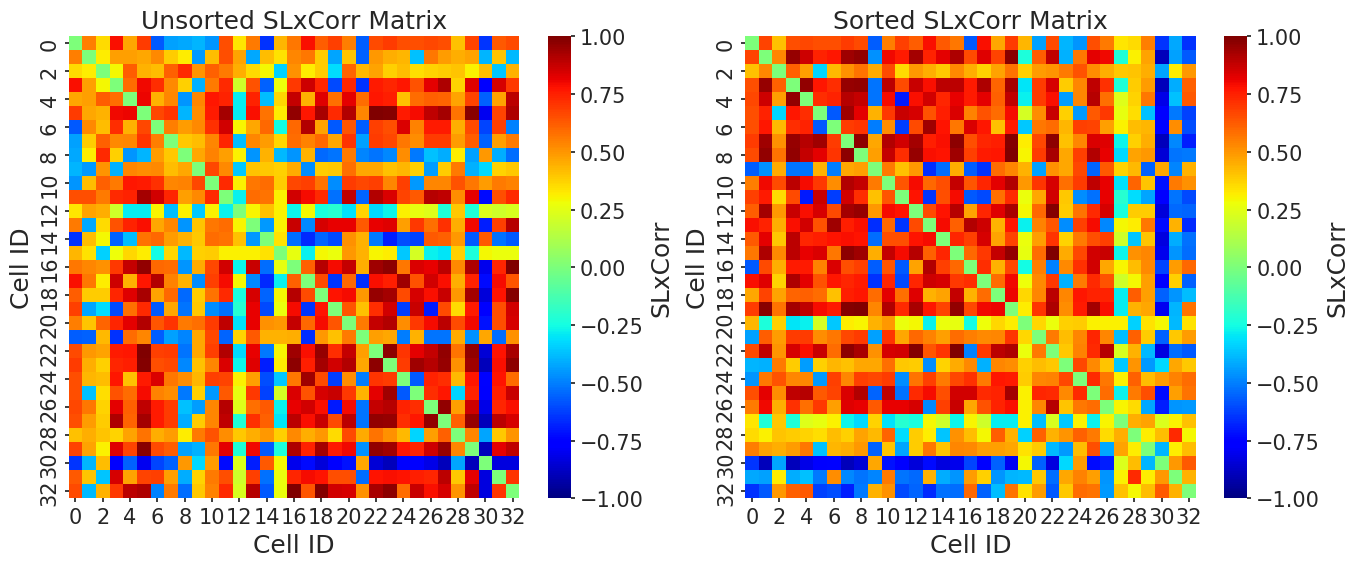

In [ ]:
# Compute SLxCorr matrix for the stimulation data
max_corr_stim_2 = np.zeros((n_cells_stim, n_cells_stim))

# Compute the lagged correlations, avoiding the diagonal (same cell comparisons)
for first in range(n_cells_stim):
    for second in range(first + 1, n_cells_stim):  # Only compute upper triangle
        corr = signed_lagged_corr(scale(normalised_data_stim_2[first, :]),
                                  scale(normalised_data_stim_2[second, :]))[0]
        max_corr_stim_2[first, second] = corr
        max_corr_stim_2[second, first] = corr  # Matrix is symmetric

# Sort the covariance matrix based on hierarchical clustering labels
idx = np.argsort(labels_hier_stim_2)

# Plotting the unsorted and sorted SLxCorr matrices side by side
plt.figure(figsize=(16, 6))

# Plot the unsorted SLxCorr matrix
plt.subplot(1, 2, 1)
ax1 = sns.heatmap(max_corr_stim_2 / np.max(abs(max_corr_stim_2)),
                  cbar_kws={'label': 'SLxCorr'},
                  cmap='jet', vmin=-1, vmax=1)
ax1.set_title('Unsorted SLxCorr Matrix')
ax1.set(xlabel='Cell ID', ylabel='Cell ID')

# Plot the sorted SLxCorr matrix (sorted by hierarchical clustering labels)
plt.subplot(1, 2, 2)
ax2 = sns.heatmap(max_corr_stim_2[idx, :][:, idx] / np.max(abs(max_corr_stim_2)),
                  cbar_kws={'label': 'SLxCorr'},
                  cmap='jet', vmin=-1, vmax=1)
ax2.set_title('Sorted SLxCorr Matrix')
ax2.set(xlabel='Cell ID', ylabel='Cell ID')

# Display the plot
plt.show()

In [ ]:
# Calculate the silhouette score for hierarchical clustering
sil_score = silhouette_score(squareform(dist_corr_stim_2), labels_hier_stim_2, metric="precomputed")

# Print the silhouette score
print(f'Silhouette score: {sil_score:.3f}')

Silhouette score: 0.444


#### K-means (corr)

In [ ]:
# Apply scikit-learn K-means clustering to the SLxCorr distance matrix
# Fix the random seed for reproducibility and set the number of clusters (Ks_2)
km = KMeans(n_clusters=Ks_2, random_state=11112, n_init=10, max_iter=100)

# Fit the model on the squared form of the SLxCorr distance matrix
km.fit(squareform(dist_corr_stim_2))

# Get the labels for the clusters assigned to each cell
labels_corr_stim_2 = km.labels_

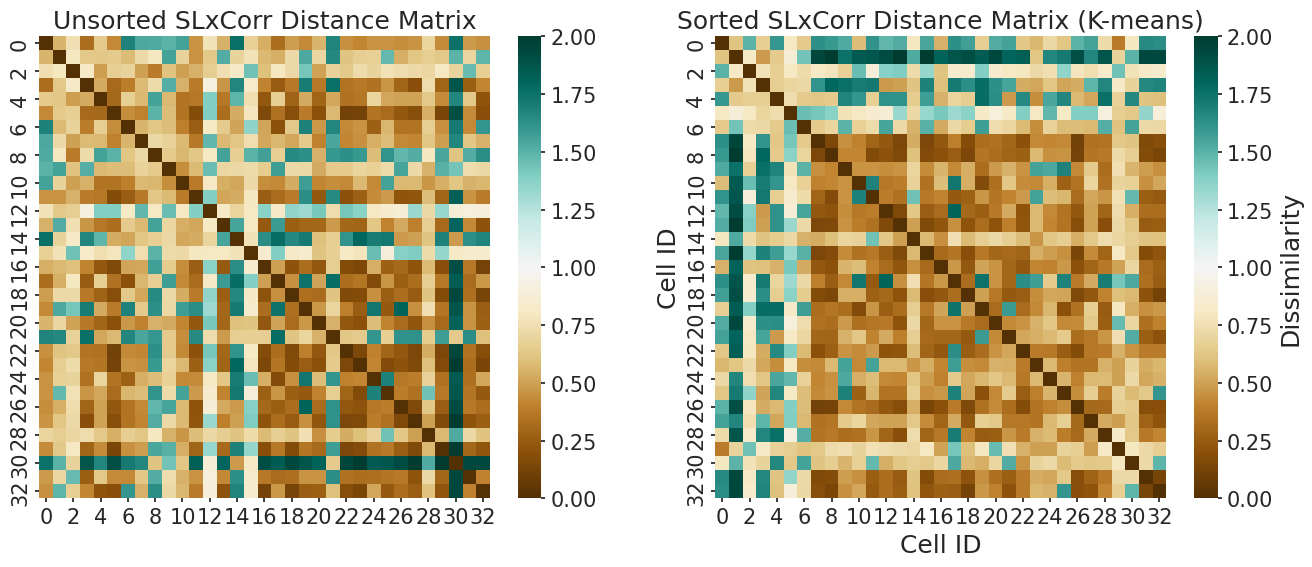

In [ ]:
# Plotting the unsorted and sorted (SLxCorr, K-means) distance matrices
plt.figure(figsize=(16, 6))

# Subplot 1: Unsorted SLxCorr distance matrix
plt.subplot(1, 2, 1)
sns.heatmap(2 * min_max_norm(squareform(dist_corr_stim_2)), cmap='BrBG')
plt.title('Unsorted SLxCorr Distance Matrix')

# Subplot 2: Sorted SLxCorr distance matrix based on K-means labels
plt.subplot(1, 2, 2)
# Sorting the SLxCorr distance matrix based on the K-means cluster labels
idx = np.argsort(labels_corr_stim_2)  # Sort indices by K-means labels
sorted_cov_dist = squareform(dist_corr_stim_2)[idx, :][:, idx]  # Apply sorting
ax = sns.heatmap(2 * min_max_norm(sorted_cov_dist),
                 cmap='BrBG', cbar_kws={'label': 'Dissimilarity'})
ax.set(xlabel='Cell ID', ylabel='Cell ID')
plt.title('Sorted SLxCorr Distance Matrix (K-means)')

# Show the plot
plt.show()

# G9 (stress)

An example of data analysis pipline for restraint stress experimental setup.

In [ ]:
# Load the stress data, transposing it for easier processing
data_stress = pd.read_csv(stress_csv_fname).T

# Strip any leading or trailing whitespace from the index labels (cell IDs)
data_stress.index = data_stress.index.str.strip()

# Display the last few rows of the dataset
# (To view the bottom rows, use `tail(n)` for n bottom rows)
data_stress.tail()

0    1          2          3          4          5          6     \
C109   accepted    0   95.10193   124.8623   165.0189    158.134   206.9987   
C111   accepted    0    80.1488   116.3439     153.48   197.7316   189.1638   
C112   accepted    0   35.65594   83.49625   79.75183   143.3132   136.8863   
C114   accepted    0   78.29032   112.5898   106.9316   244.0014   231.7393   
C117   accepted    0    205.761   281.3857   449.4968   579.1699    553.998   

           7          8          9     ...       6435       6436       6437  \
C109   259.3236   288.9745   295.3506  ...   1584.121   1543.994   1566.582   
C111   218.9006   280.8517   315.9242  ...   962.8788   1009.117   981.3885   
C112   130.7477   124.8842   182.0726  ...   1289.253   1416.734     1353.2   
C114   364.0249   378.1245    405.894  ...   906.4796    931.878   998.7589   
C117   630.3789   739.1033   859.9053  ...   2573.038   2617.881   2542.832   

           6438       6439       6440       6441       6442       6443  \
C109   1566.807   1648.355   1579.582   1513.679   1450.525   1390.006   
C111   938.8648   916.3129   1065.268    1019.11   974.9519   932.7072   
C112   1292.516   1234.552   1179.189   1126.308   1075.798   1027.554   
C114   1015.428   1154.258   1096.252    1041.16   988.8375   939.1442   
C117   2569.154   2552.073   2543.887   2653.753   2538.416   2428.092   

           6444  
C109   1332.012  
C111   892.2928  
C112   981.4733  
C114   891.9481  
C117   2322.563  

[5 rows x 6445 columns]

## Data Slicing

In [ ]:
# Slice the deconvoluted data for fluorescence intensity, excluding the first row and column
cells_traces_stress_tot = data_stress.iloc[1:, 1:]

# Get the number of cells and the total length of the stress data
n_cells_stress, data_stress_length_tot = cells_traces_stress_tot.shape

# Display the last few rows of the fluorescence intensity data
cells_traces_stress_tot.tail()

1          2          3          4          5          6          7     \
C109    0   95.10193   124.8623   165.0189    158.134   206.9987   259.3236   
C111    0    80.1488   116.3439     153.48   197.7316   189.1638   218.9006   
C112    0   35.65594   83.49625   79.75183   143.3132   136.8863   130.7477   
C114    0   78.29032   112.5898   106.9316   244.0014   231.7393   364.0249   
C117    0    205.761   281.3857   449.4968   579.1699    553.998   630.3789   

           8          9          10    ...       6435       6436       6437  \
C109   288.9745   295.3506    442.175  ...   1584.121   1543.994   1566.582   
C111   280.8517   315.9242   323.5248  ...   962.8788   1009.117   981.3885   
C112   124.8842   182.0726   173.9075  ...   1289.253   1416.734     1353.2   
C114   378.1245    405.894   385.4961  ...   906.4796    931.878   998.7589   
C117   739.1033   859.9053    997.552  ...   2573.038   2617.881   2542.832   

           6438       6439       6440       6441       6442       6443  \
C109   1566.807   1648.355   1579.582   1513.679   1450.525   1390.006   
C111   938.8648   916.3129   1065.268    1019.11   974.9519   932.7072   
C112   1292.516   1234.552   1179.189   1126.308   1075.798   1027.554   
C114   1015.428   1154.258   1096.252    1041.16   988.8375   939.1442   
C117   2569.154   2552.073   2543.887   2653.753   2538.416   2428.092   

           6444  
C109   1332.012  
C111   892.2928  
C112   981.4733  
C114   891.9481  
C117   2322.563  

[5 rows x 6444 columns]

In [ ]:
# Create time axis from the first row, excluding the first column
ts_stress_tot = np.asarray(data_stress.iloc[0, 1:], dtype=float)

# Calculate time between frames (in seconds) based on the second timestamp
sec_per_frame = ts_stress_tot[1]

# Compute sampling frequency (in Hz) as the inverse of time per frame
fs = 1 / sec_per_frame

## Minmax Scaling over each trace

In [ ]:
# Convert temporal activity data from pandas DataFrame to numpy arrays (float type)
data_stress_tot = np.asarray(cells_traces_stress_tot, dtype=float)

In [ ]:
# Rescale fluorescence intensity traces to the range [0, 1] for each trace
normalised_data_stress_tot = minmax_scale(data_stress_tot, axis=1)

## **Stressed**

Hereafter, I only focus on the data while the stimulation is applied at 2 minutes after starting recording with 0.1 Hz (5 s on followed by 5 s off).

### Data Slicing

In [ ]:
# Slice data during stimulation (stress)
# Fluorescence intensity
cells_traces_stress_2 = cells_traces_stress_tot.iloc[:, stress_onset:stress_offset]

# Normalise the sliced traces
normalised_data_stress_2 = normalised_data_stress_tot[:, stress_onset:stress_offset]

# Get the number of time points during stimulation
data_stress_length_2 = cells_traces_stress_2.shape[1]

# Preview the sliced data
cells_traces_stress_2.head()

1805          1806           1807           1808  \
C001       564.7203       540.077        516.509       534.2924   
C002       980.4408      937.2857       896.0302       856.5905   
C003   5.601141e-05   5.36047e-05   5.130141e-05   4.909709e-05   
C004       1184.398       1164.48       1222.307       1190.472   
C006       194.5789      185.3417        176.543        168.162   

               1809           1810          1811           1812  \
C001       510.9768       488.6786      502.2167       523.7151   
C002        906.611       866.7056      828.5567       854.4611   
C003   4.698748e-05   4.496851e-05   4.30363e-05   4.118712e-05   
C004       1240.487        1224.88      1239.839       1254.031   
C006        160.179       152.5748      145.3317       138.4324   

               1813           1814  ...           3595           3596  \
C001       541.6691       540.3986  ...       902.8068       909.7328   
C002       869.4901       914.1444  ...       127.7488       122.1258   
C003   3.941738e-05   3.772369e-05  ...        288.625       276.2233   
C004       1234.069        1179.39  ...       549.6006       695.2413   
C006       131.8607       125.6009  ...   0.0005982646   0.0005698634   

               3597           3598           3599           3600       3601  \
C001       937.0206       945.0977       966.5388       924.3607   884.0233   
C002       116.7503       111.6114       106.6987       102.0023   97.51255   
C003       330.7137       316.5036        337.491       322.9896   309.1114   
C004       664.4363       634.9963       606.8607       579.9717   554.2741   
C006   0.0005428104   0.0005170418   0.0004924964   0.0004691163   605.5109   

           3602       3603       3604  
C001   915.3652   875.4203   837.2185  
C002   93.22044   89.11725   85.19466  
C003   301.1467    288.207   284.8316  
C004   529.7151   506.2443   483.8135  
C006   624.0441   775.2006   1094.609  

[5 rows x 1800 columns]

In [ ]:
# Create time axis for the stress period
ts_stress_2 = ts_stress_tot[stress_onset:stress_offset]

In [ ]:
# Convert temporal activity data from pandas DataFrame to NumPy arrays for numerical processing
data_stress_2 = np.asarray(cells_traces_stress_2.iloc[:, :], dtype=float)

### Clustering

#### Hierarchical (cor)

In [ ]:
# Pairwise correlation distance calculation using signed lagged correlation
# - `pdist` computes pairwise distances for the normalized data `normalised_data_stim_2`.
# - The lambda function computes the distance as `1 - signed_lagged_corr(x, y)[0]` for each pair of activity traces.
# - The `scale(normalised_data_stim_2, axis=1)` standardises the traces by centering and scaling each trace across cells.

dist_corr_stress_2 = pdist(scale(normalised_data_stress_2, axis=1),
                         lambda x, y: 1 - signed_lagged_corr(x, y)[0])

# `dist_corr_stim_2` is a condensed distance matrix representing covariance-based distances between traces.

In [ ]:
# Apply hierarchical clustering to sort activity traces
# - AgglomerativeClustering performs hierarchical clustering.
# - `n_clusters=Ks_2` specifies the number of clusters.
# - `metric='precomputed'` indicates that the distance matrix has already been computed (i.e., `dist_cov_stim_2`).
# - `linkage='average'` uses the average linkage criterion for merging clusters.
# - `compute_distances=True` ensures that the pairwise distances are computed during the clustering process.
# - `squareform(dist_cov_stim_2)` converts the condensed distance matrix back to a square form, which is required by AgglomerativeClustering.

ac = AgglomerativeClustering(
    n_clusters=Ks_2,                 # Number of clusters
    metric='precomputed',            # Use precomputed distance matrix
    linkage='average',               # Average linkage criterion
    compute_distances=True           # Compute pairwise distances
).fit(squareform(dist_corr_stress_2))   # Convert condensed distance matrix to square form

# Retrieve the cluster labels assigned to each trace
labels_hier_stress_2 = ac.labels_

# `labels_hier_cov_stim_2` contains the cluster assignment for each trace.

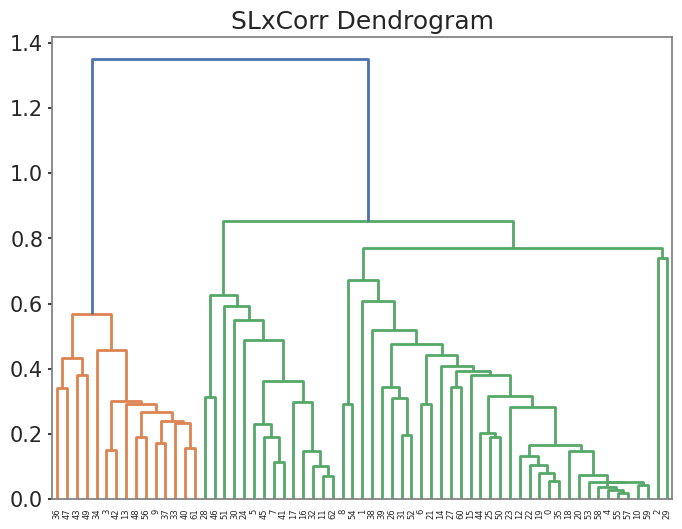

In [ ]:
# Hierarchical clustering via SLxCorr
plt.figure(figsize=(8, 6))  # Set the size of the figure

# Compute linkage matrix from the agglomerative clustering object
# `compute_linkage` is used to extract the linkage matrix for the dendrogram
Z = compute_linkage(ac)

# Create and plot the dendrogram
dendrogram(
    Z,                                       # Linkage matrix
    orientation='top',                       # Place the branches at the top
    leaf_rotation=90,                        # Rotate the leaf labels by 90 degrees
    color_threshold=ac.distances_[-1] - 0.1  # Set the color threshold for clusters (a little below the max distance)
)

# Add a title to the plot
plt.title('SLxCorr Dendrogram')

# Display the plot
plt.show()

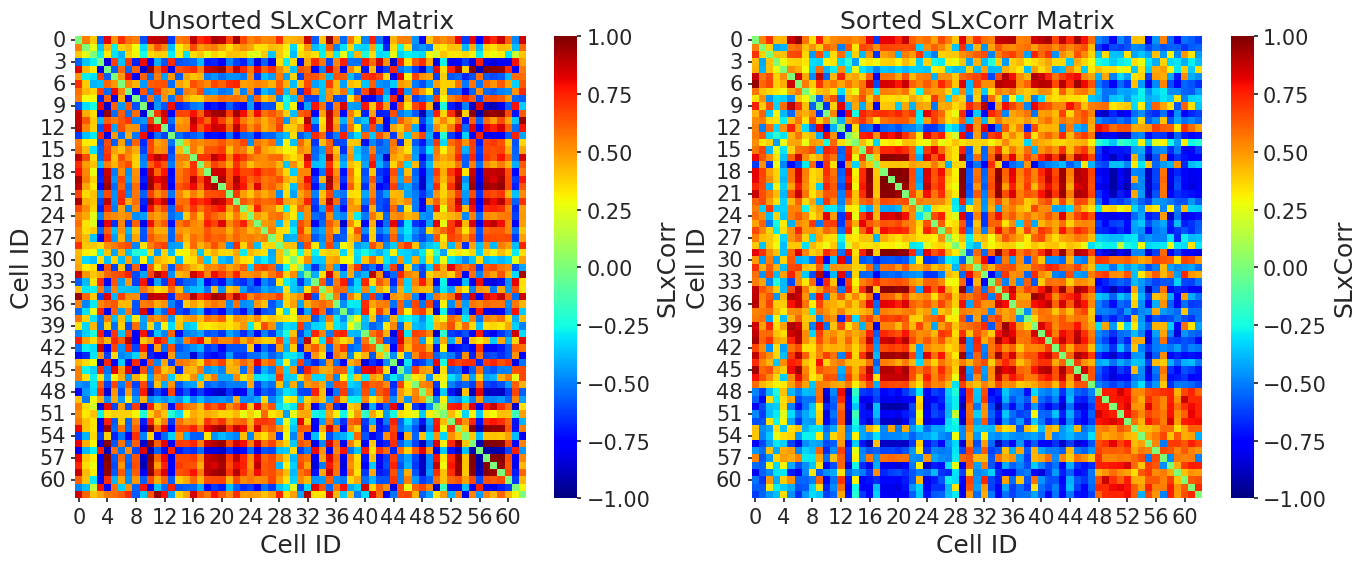

In [ ]:
# Compute SLxCorr matrix for the stimulation data
max_corr_stress_2 = np.zeros((n_cells_stress, n_cells_stress))

# Compute the lagged correlations, avoiding the diagonal (same cell comparisons)
for first in range(n_cells_stress):
    for second in range(first + 1, n_cells_stress):  # Only compute upper triangle
        corr = signed_lagged_corr(scale(normalised_data_stress_2[first, :]),
                                  scale(normalised_data_stress_2[second, :]))[0]
        max_corr_stress_2[first, second] = corr
        max_corr_stress_2[second, first] = corr  # Matrix is symmetric

# Sort the covariance matrix based on hierarchical clustering labels
idx = np.argsort(labels_hier_stress_2)

# Plotting the unsorted and sorted SLxCorr matrices side by side
plt.figure(figsize=(16, 6))

# Plot the unsorted SLxCorr matrix
plt.subplot(1, 2, 1)
ax1 = sns.heatmap(max_corr_stress_2 / np.max(abs(max_corr_stress_2)),
                  cbar_kws={'label': 'SLxCorr'},
                  cmap='jet', vmin=-1, vmax=1)
ax1.set_title('Unsorted SLxCorr Matrix')
ax1.set(xlabel='Cell ID', ylabel='Cell ID')

# Plot the sorted SLxCorr matrix (sorted by hierarchical clustering labels)
plt.subplot(1, 2, 2)
ax2 = sns.heatmap(max_corr_stress_2[idx, :][:, idx] / np.max(abs(max_corr_stress_2)),
                  cbar_kws={'label': 'SLxCorr'},
                  cmap='jet', vmin=-1, vmax=1)
ax2.set_title('Sorted SLxCorr Matrix')
ax2.set(xlabel='Cell ID', ylabel='Cell ID')

# Display the plot
plt.show()

In [ ]:
# Calculate the silhouette score for hierarchical clustering
sil_score = silhouette_score(squareform(dist_corr_stress_2), labels_hier_stress_2, metric="precomputed")

# Print the silhouette score
print(f'Silhouette score: {sil_score:.3f}')

Silhouette score: 0.532


#### K-means (corr)

In [ ]:
# Apply scikit-learn K-means clustering to the SLxCorr distance matrix
# Fix the random seed for reproducibility and set the number of clusters (Ks_2)
km = KMeans(n_clusters=Ks_2, random_state=11112, n_init=10, max_iter=100)

# Fit the model on the squared form of the SLxCorr distance matrix
km.fit(squareform(dist_corr_stress_2))

# Get the labels for the clusters assigned to each cell
labels_corr_stress_2 = km.labels_

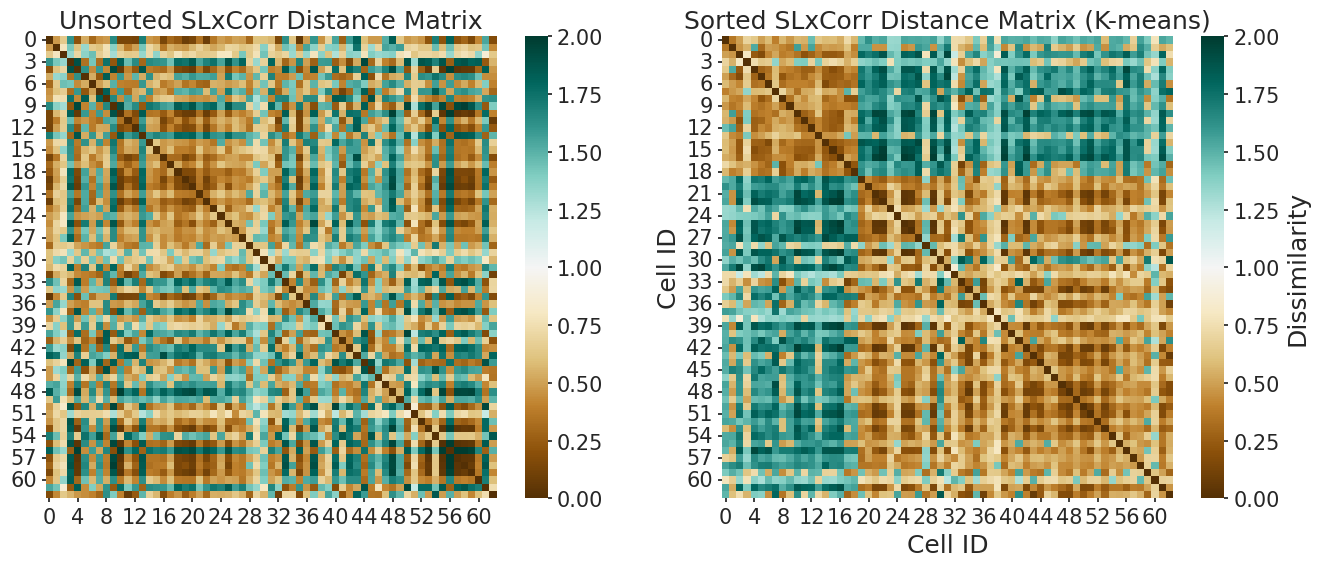

In [ ]:
# Plotting the unsorted and sorted (SLxCorr, K-means) distance matrices
plt.figure(figsize=(16, 6))

# Subplot 1: Unsorted SLxCorr distance matrix
plt.subplot(1, 2, 1)
sns.heatmap(2 * min_max_norm(squareform(dist_corr_stress_2)), cmap='BrBG')
plt.title('Unsorted SLxCorr Distance Matrix')

# Subplot 2: Sorted SLxCorr distance matrix based on K-means labels
plt.subplot(1, 2, 2)
# Sorting the SLxCorr distance matrix based on the K-means cluster labels
idx = np.argsort(labels_corr_stress_2)  # Sort indices by K-means labels
sorted_cov_dist = squareform(dist_corr_stress_2)[idx, :][:, idx]  # Apply sorting
ax = sns.heatmap(2 * min_max_norm(sorted_cov_dist),
                 cmap='BrBG', cbar_kws={'label': 'Dissimilarity'})
ax.set(xlabel='Cell ID', ylabel='Cell ID')
plt.title('Sorted SLxCorr Distance Matrix (K-means)')

# Show the plot
plt.show()

#### Hierarchical (cov)

In [ ]:
# Calculate pairwise covariance distance
# - `pdist` computes the pairwise distances between rows of a matrix.
# - `scale(normalised_data_stim_2, axis=1)` ensures each trace is normalized before calculating covariance.
# - The lambda function computes the covariance between two traces, subtracting it from 1 to define the distance.

dist_cov_stress_2 = pdist(
    scale(normalised_data_stress_2, axis=1),
    lambda x, y: 1 - np.cov(x, y, bias=True)[0, 1]
)

# `dist_cov_stim_2` is a condensed distance matrix representing covariance-based distances between traces.

In [ ]:
# Apply hierarchical clustering to sort activity traces
# - AgglomerativeClustering performs hierarchical clustering.
# - `n_clusters=Ks_2` specifies the number of clusters.
# - `metric='precomputed'` indicates that the distance matrix has already been computed (i.e., `dist_cov_stim_2`).
# - `linkage='average'` uses the average linkage criterion for merging clusters.
# - `compute_distances=True` ensures that the pairwise distances are computed during the clustering process.
# - `squareform(dist_cov_stim_2)` converts the condensed distance matrix back to a square form, which is required by AgglomerativeClustering.

ac = AgglomerativeClustering(
    n_clusters=Ks_2,                 # Number of clusters
    metric='precomputed',            # Use precomputed distance matrix
    linkage='average',               # Average linkage criterion
    compute_distances=True           # Compute pairwise distances
).fit(squareform(dist_cov_stress_2))   # Convert condensed distance matrix to square form

# Retrieve the cluster labels assigned to each trace
labels_hier_cov_stress_2 = ac.labels_

# `labels_hier_cov_stim_2` contains the cluster assignment for each trace.

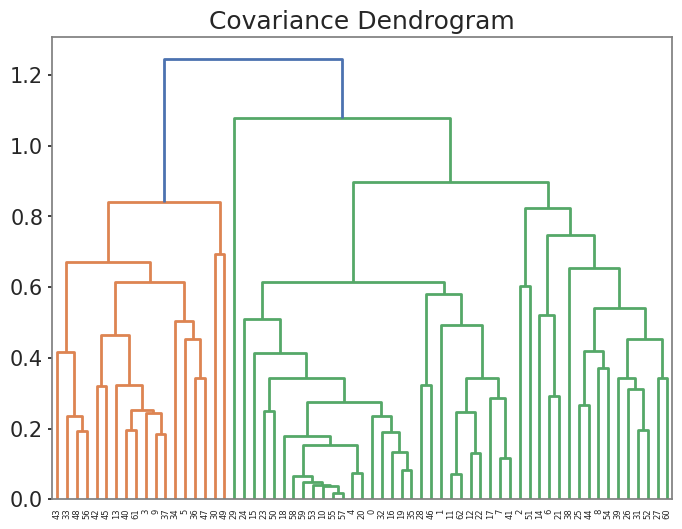

In [ ]:
# Hierarchical clustering via covariance
plt.figure(figsize=(8, 6))  # Set the size of the figure

# Compute linkage matrix from the agglomerative clustering object
# `compute_linkage` is used to extract the linkage matrix for the dendrogram
Z = compute_linkage(ac)

# Create and plot the dendrogram
dendrogram(
    Z,                                       # Linkage matrix
    orientation='top',                       # Place the branches at the top
    leaf_rotation=90,                        # Rotate the leaf labels by 90 degrees
    color_threshold=ac.distances_[-1] - 0.1  # Set the color threshold for clusters (a little below the max distance)
)

# Add a title to the plot
plt.title('Covariance Dendrogram')

# Display the plot
plt.show()

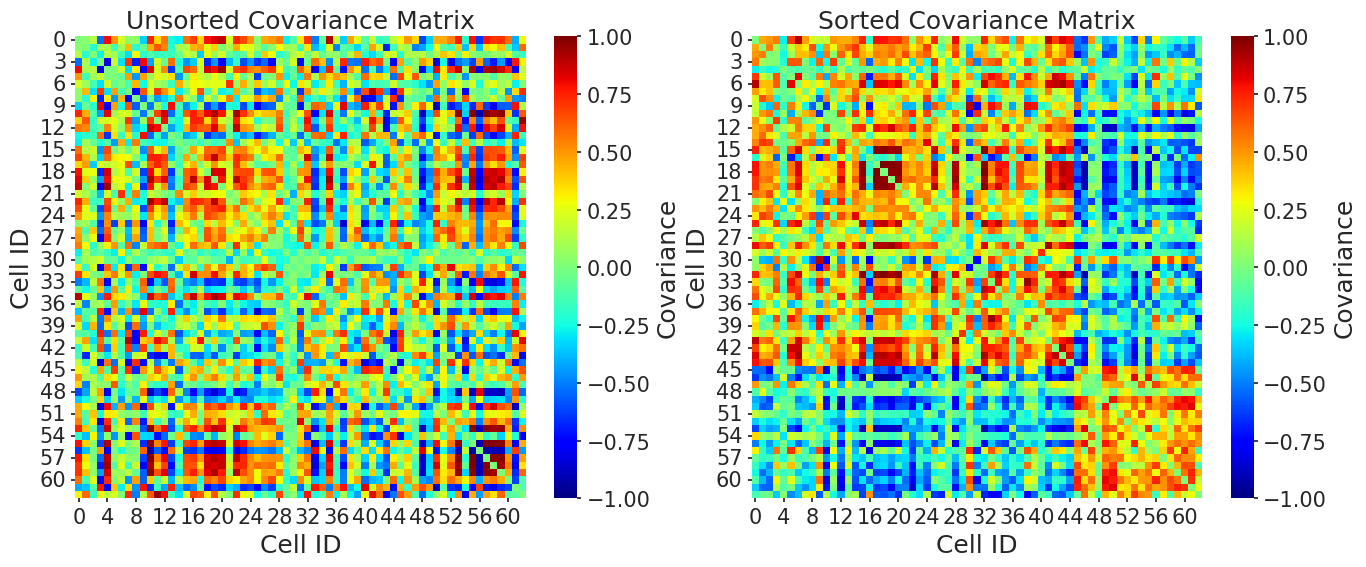

In [ ]:
# Compute covariance matrix for the stimulation data
cov_stress_2 = np.cov(scale(normalised_data_stress_2, axis=1), bias=True)

# Mask the diagonal to avoid self-covariance, setting it to zero
# The matrix 'temp' is a ones matrix with zeros on the diagonal
temp = np.ones(n_cells_stress) - np.eye(n_cells_stress)
cov_stress_2 = np.multiply(cov_stress_2, temp)

# Sort the covariance matrix based on hierarchical clustering labels
idx = np.argsort(labels_hier_cov_stress_2)

# Plotting the unsorted and sorted covariance matrices side by side
plt.figure(figsize=(16, 6))

# Plot the unsorted covariance matrix
plt.subplot(1, 2, 1)
ax1 = sns.heatmap(cov_stress_2 / np.max(abs(cov_stress_2)),
                  cbar_kws={'label': 'Covariance'},
                  cmap='jet', vmin=-1, vmax=1)
ax1.set_title('Unsorted Covariance Matrix')
ax1.set(xlabel='Cell ID', ylabel='Cell ID')

# Plot the sorted covariance matrix (sorted by hierarchical clustering labels)
plt.subplot(1, 2, 2)
ax2 = sns.heatmap(cov_stress_2[idx, :][:, idx] / np.max(abs(cov_stress_2)),
                  cbar_kws={'label': 'Covariance'},
                  cmap='jet', vmin=-1, vmax=1)
ax2.set_title('Sorted Covariance Matrix')
ax2.set(xlabel='Cell ID', ylabel='Cell ID')

# Display the plot
plt.show()

In [ ]:
# Calculate the silhouette score for hierarchical clustering
sil_score = silhouette_score(squareform(dist_cov_stress_2), labels_hier_cov_stress_2, metric="precomputed")

# Print the silhouette score
print(f'Silhouette score: {sil_score:.3f}')

Silhouette score: 0.431


#### K-means (cov)

In [ ]:
# Apply scikit-learn K-means clustering to the covariance distance matrix
# Fix the random seed for reproducibility and set the number of clusters (Ks_2)
km = KMeans(n_clusters=Ks_2, random_state=11112, n_init=10, max_iter=100)

# Fit the model on the squared form of the covariance distance matrix
km.fit(squareform(dist_cov_stress_2))

# Get the labels for the clusters assigned to each cell
labels_cov_stress_2 = km.labels_

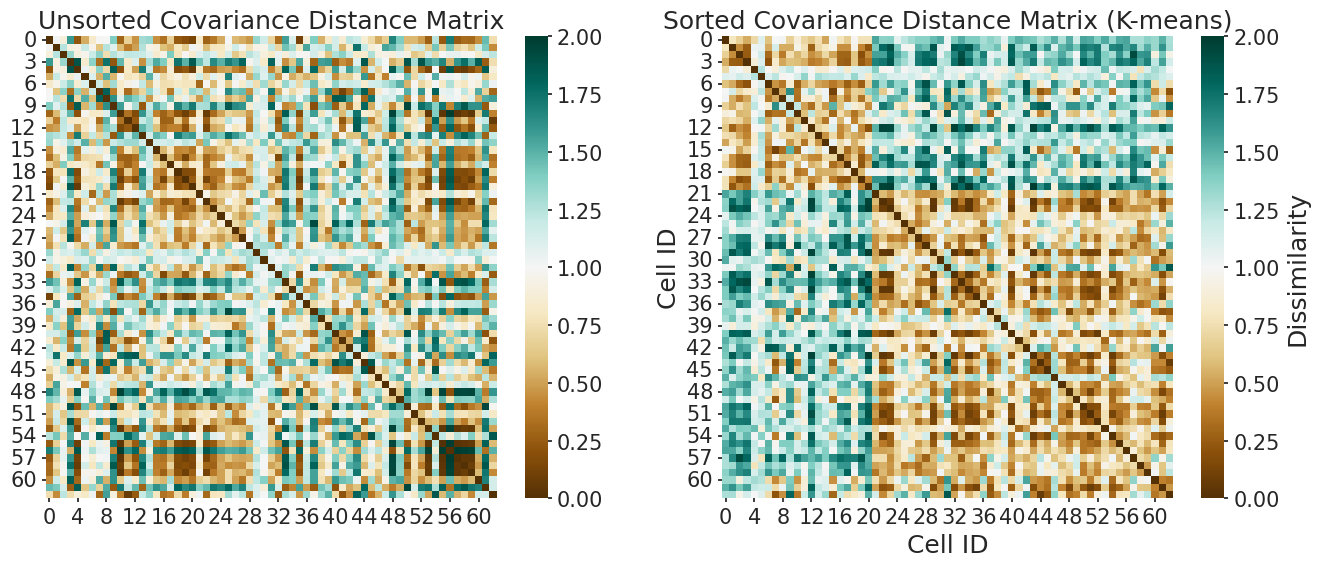

In [ ]:
# Plotting the unsorted and sorted (covariance, K-means) distance matrices
plt.figure(figsize=(16, 6))

# Subplot 1: Unsorted covariance distance matrix
plt.subplot(1, 2, 1)
sns.heatmap(2 * min_max_norm(squareform(dist_cov_stress_2)), cmap='BrBG')
plt.title('Unsorted Covariance Distance Matrix')

# Subplot 2: Sorted covariance distance matrix based on K-means labels
plt.subplot(1, 2, 2)
# Sorting the covariance distance matrix based on the K-means cluster labels
idx = np.argsort(labels_cov_stress_2)  # Sort indices by K-means labels
sorted_cov_dist = squareform(dist_cov_stress_2)[idx, :][:, idx]  # Apply sorting
ax = sns.heatmap(2 * min_max_norm(sorted_cov_dist),
                 cmap='BrBG', cbar_kws={'label': 'Dissimilarity'})
ax.set(xlabel='Cell ID', ylabel='Cell ID')
plt.title('Sorted Covariance Distance Matrix (K-means)')

# Show the plot
plt.show()

## Figure 2

In [ ]:
# Load cell percentage hierarchical data
cell_percentage_hier = pd.read_csv(cell_percentage_hier_corr_path)

# Each row represents a trial, and each column represents a category
# Display the top few rows to check the data structure
cell_percentage_hier.head()

Total # of Cells (All Animals)  # of GABA Cells (All Animals)  \
0                            60.0                           52.0   
1                            47.0                           34.0   
2                             NaN                            NaN   
3                             NaN                            NaN   
4                             NaN                            NaN   

   # of Removed Cells (All Animals)  All Animals (#1)  All Animals (#2)  \
0                               8.0         42.307692         57.692308   
1                              13.0         35.294118         64.705882   
2                               NaN               NaN               NaN   
3                               NaN               NaN               NaN   
4                               NaN               NaN               NaN   

   # of GABA Cells (Stimulation)  # of Removed Cells (Stimulation)  \
0                           52.0                               8.0   
1                           34.0                              13.0   
2                            NaN                               NaN   
3                            NaN                               NaN   
4                            NaN                               NaN   

   Stimulation (#1)  Stimulation (#2)  # of GABA Cells (Stress)  ...  \
0         42.307692         57.692308                       NaN  ...   
1         35.294118         64.705882                       NaN  ...   
2               NaN               NaN                       NaN  ...   
3               NaN               NaN                       NaN  ...   
4               NaN               NaN                       NaN  ...   

   # of GABA Cells (G29)  # of Removed Cells (G29)  G29 (#1)  G29 (#2)  \
0                    NaN                       NaN       NaN       NaN   
1                    NaN                       NaN       NaN       NaN   
2                    NaN                       NaN       NaN       NaN   
3                    NaN                       NaN       NaN       NaN   
4                    NaN                       NaN       NaN       NaN   

   # of GABA Cells (G37)  # of Removed Cells (G37)  G37 (#1)  G37 (#2)  \
0                    NaN                       NaN       NaN       NaN   
1                    NaN                       NaN       NaN       NaN   
2                    NaN                       NaN       NaN       NaN   
3                    NaN                       NaN       NaN       NaN   
4                    NaN                       NaN       NaN       NaN   

   All Animals (#1).1  All Animals (#2).1  
0                22.0                30.0  
1                12.0                22.0  
2                 NaN                 NaN  
3                 NaN                 NaN  
4                 NaN                 NaN  

[5 rows x 39 columns]

In [ ]:
# Extract the list of categories for the number of cells in clusters using hierarchical method
categories_percent_hier = cell_percentage_hier.columns.tolist()

# Extract the total number of GABA cells from the column '# of GABA Cells (All Animals)'
no_GABA_cells = cell_percentage_hier['# of GABA Cells (All Animals)']

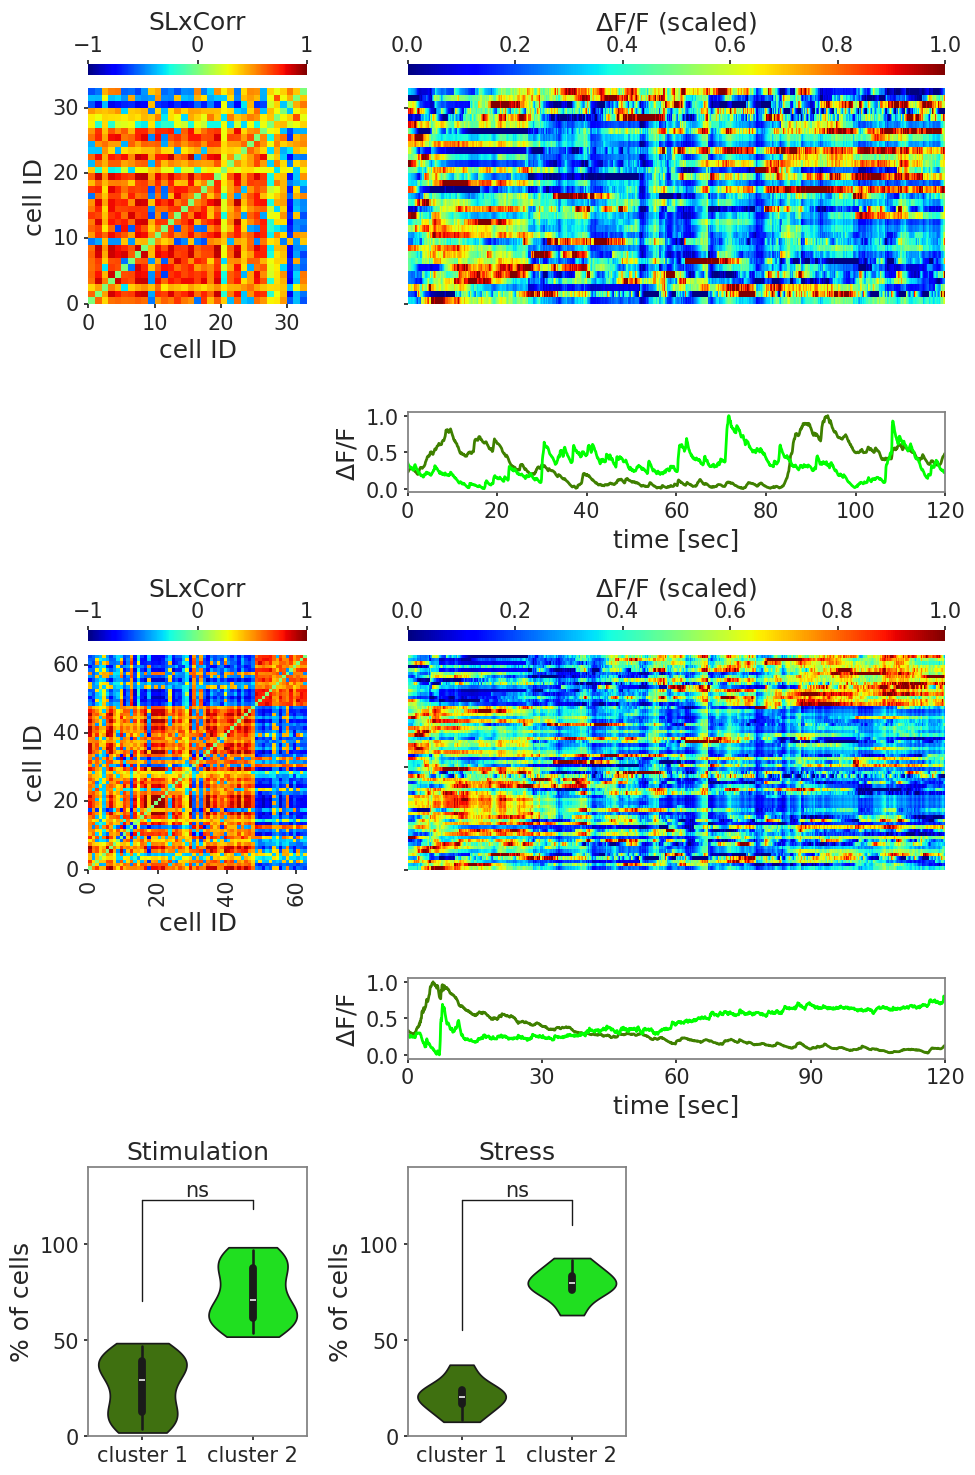

In [ ]:
# Set up figure dimensions and grid
fig = plt.figure(figsize=(10, 15))        # Define figure size
gs = gridspec.GridSpec(8, 3, figure=fig)  # Set up a 8x3 grid for subplots

# Sort the data based on hierarchical clustering labels
idx = np.argsort(labels_hier_stim_2)

# Plot 1: Heatmap of pairwise correlations (stimulus condition 2)
ax = fig.add_subplot(gs[0:2, 0])  # First subplot (Top-left)
ax = sns.heatmap(max_corr_stim_2[idx, :][:, idx],  # Sorted correlation matrix
                 cbar_kws={'label': 'SLxCorr', 'location': 'top'},  # Colorbar settings
                 cmap='jet', vmin=-1, vmax=1)  # Set colormap and value range
ax.set(xlabel='cell ID', ylabel='cell ID')  # Axis labels
ax.set_xticks([_ for _ in list(range(n_cells_stim)) if _ % 10 == 0])  # Display every 10th cell on x-axis
ax.set_xticklabels([_ for _ in list(range(n_cells_stim)) if _ % 10 == 0])  # X-axis tick labels
ax.set_yticks([_ for _ in list(range(n_cells_stim)) if _ % 10 == 0])  # Display every 10th cell on y-axis
ax.set_yticklabels([_ for _ in list(range(n_cells_stim)) if _ % 10 == 0])  # Y-axis tick labels
ax.invert_yaxis()  # Invert the y-axis to show the first cell at the top


# Plot 2: Heatmap of normalised fluorescence data (stimulus condition 2)
ax = plt.subplot(gs[0:2, 1:3])  # Second subplot (Top-right)
# Normalise and scale the data
ax = sns.heatmap(minmax_scale(scale(data_stress_2[idx, :], axis=1), axis=0),
            cbar_kws={'label':'$\Delta$F/F (scaled)', 'location':'top', 'aspect':50},  # Colorbar settings
            cmap='jet', vmin=0, vmax=1)  # Set colormap for fluorescence
ax.set_aspect('auto')  # Adjust axis aspect
ax.set_xlabel('')  # No label for the x-axis
ax.set_xticks([])  # No ticks on the x-axis
ax.set_yticks(range(0,40,30), labels=[])  # No labels for the y-axis ticks
ax.invert_yaxis()  # Invert the y-axis to show the first cell at the top


# Plot 3: Average traces of cells for hierarchical clustering (stimulus condition 2)
ax = plt.subplot(gs[2, 1:3])  # Third subplot (Bottom-left)
for Ki in range(0, Ks_2):  # Loop through clusters
    js = np.where(labels_hier_stim_2 == Ki)  # Get indices of cells in cluster Ki
    avg = np.mean(np.squeeze(data_stim_2[js, :]), axis=0)  # Calculate average trace for cluster Ki
    avg = minmax_scale(avg)  # Normalise the trace

    ax.plot(avg, c=GABA_greens[Ki])  # Plot the average trace in the corresponding cluster color
ax.set_xlim(0, 120)  # Set x-axis limits (time range)
ax.set_xlabel('time [sec]')  # X-axis label for time
ax.set_xticks(range(0,1400,200), labels=range(0,140,20), rotation=0)  # Set x-axis ticks
ax.set_ylabel('$\Delta$F/F')  # Y-axis label for fluorescence change
ax.set_yticks([0, 0.5, 1])  # Y-axis ticks for fluorescence levels


# Sort the data based on hierarchical clustering labels
idx = np.argsort(labels_hier_stress_2)

# Plot 4: Violin plot for cell percentage in clusters (stress condition 2)
ax = fig.add_subplot(gs[3:5, 0])  # Fourth subplot (Middle-left)
ax = sns.heatmap(max_corr_stress_2[idx, :][:, idx],  # Sorted correlation matrix
                 cbar_kws={'label': 'SLxCorr', 'location': 'top'},  # Colorbar settings
                 cmap='jet', vmin=-1, vmax=1)  # Set colormap and value range
ax.set(xlabel='cell ID', ylabel='cell ID')  # Axis labels
ax.set_xticks([_ for _ in list(range(n_cells_stress)) if _ % 20 == 0])  # Display every 20th cell on x-axis
ax.set_xticklabels([_ for _ in list(range(n_cells_stress)) if _ % 20 == 0])  # X-axis tick labels
ax.set_yticks([_ for _ in list(range(n_cells_stress)) if _ % 20 == 0])  # Display every 20th cell on y-axis
ax.set_yticklabels([_ for _ in list(range(n_cells_stress)) if _ % 20 == 0])  # Y-axis tick labels
ax.invert_yaxis()  # Invert the y-axis to show the first cell at the top


# Plot 5: Heatmap of normalized fluorescence data (stress condition 2)
ax = plt.subplot(gs[3:5, 1:3])  # Fifth subplot (Middle-right)
# Normalise and scale the data
ax = sns.heatmap(minmax_scale(scale(data_stress_2[idx, :], axis=1), axis=0),
            cbar_kws={'label':'$\Delta$F/F (scaled)', 'location':'top', 'aspect':50},  # Colorbar settings
            cmap='jet', vmin=0, vmax=1)  # Set colormap for fluorescence
ax.set_aspect('auto')  # Adjust axis aspect
ax.set_xlabel('')  # No label for the x-axis
ax.set_xticks([])  # No ticks on the x-axis
ax.set_yticks(range(0,40,30), labels=[])  # No labels for the y-axis ticks
ax.invert_yaxis()  # Invert the y-axis to show the first cell at the top


# Plot 6: Average traces of cells for hierarchical clustering (stress condition 2)
ax = plt.subplot(gs[5, 1:3])  # Sixth subplot (Bottom-center)
for Ki in range(0, Ks_2):  # Loop through clusters
    js = np.where(labels_hier_stress_2 == Ki)  # Get indices of cells in cluster Ki
    avg = np.mean(np.squeeze(data_stress_2[js, :]), axis=0)  # Calculate average trace for cluster Ki
    avg = minmax_scale(avg)  # Normalize the trace

    ax.plot(avg, c=GABA_greens[Ki])  # Plot the average trace in the corresponding cluster color
ax.set_xlim(0, 120)  # Set x-axis limits (time range)
ax.set_xlabel('time [sec]')  # X-axis label for time
ax.set_xticks(range(0,1500,300), labels=range(0,150,30), rotation=0)  # Set x-axis ticks
ax.set_ylabel('$\Delta$F/F')  # Y-axis label for fluorescence change
ax.set_yticks([0, 0.5, 1])  # Y-axis ticks for fluorescence levels


# Plot 7: Violin plot for cell percentage in clusters (stress condition)
ax = plt.subplot(gs[6:8, 0])  # Seventh subplot (Bottom-left)
perc1 = cell_percentage_hier[categories_percent_hier[7]]  # Get cell percentages for cluster 1
df = pd.DataFrame(dict(x=np.repeat([0], len(perc1)), y=perc1))  # Create dataframe for violin plot
sns.violinplot(x="x", y="y", data=df, order=np.arange(2), inner='box', linecolor='k', color=eff_green, cut=0.2)  # Violin plot for cluster 1

perc2 = cell_percentage_hier[categories_percent_hier[8]]  # Get cell percentages for cluster 2
df = pd.DataFrame(dict(x=np.repeat([1], len(perc2)), y=perc2))  # Create dataframe for violin plot
sns.violinplot(x="x", y="y", data=df, order=np.arange(2), inner='box', linecolor='k', color=inter_green, cut=0.2)

ax.set_title(categories_percent_hier[7][:-5])  # Title for the plot
ax.set_ylim(0, 140)  # Y-axis limits
ax.set_xlabel('')  # No label for the x-axis
ax.set_ylabel('% of cells')  # Y-axis label
ax.set_xticks(range(2), labels=['cluster 1', 'cluster 2'])  # X-axis labels for clusters
ax.set_yticks(range(0, 150, 50), labels=range(0, 150, 50))  # Y-axis ticks for percentage  # Violin plot for cluster 2

# Statistical tests (Mann-Whitney U and Kolmogorov-Smirnov)
ax.plot([0, 1], [123, 123], 'k-', lw=1)  # Plot separator line
ax.plot([0, 0], [70, 123], 'k-', lw=1)  # Plot separator line
ax.plot([1, 1], [118, 123], 'k-', lw=1)  # Plot separator line
# Mann-Whitney U test between clusters
MW_p_value, _ = mannwhitneyu(perc1, perc2)
# Kolmogorov-Smirnov test between clusters
_, KS_p_value = kstest(perc1, perc2)
ax.annotate(pval_to_star(KS_p_value), (1/2, 125), ha='center')  # Annotate p-value for Kolmogorov-Smirnov test


# Plot 8: Violin plot for cell percentage in clusters (stress condition)
ax = plt.subplot(gs[6:8, 1])  # Seventh subplot (Bottom-left)
perc1 = cell_percentage_hier[categories_percent_hier[11]]  # Get cell percentages for cluster 1
df = pd.DataFrame(dict(x=np.repeat([0], len(perc1)), y=perc1))  # Create dataframe for violin plot
sns.violinplot(x="x", y="y", data=df, order=np.arange(2), inner='box', linecolor='k', color=eff_green, cut=0.2)  # Violin plot for cluster 1

perc2 = cell_percentage_hier[categories_percent_hier[12]]  # Get cell percentages for cluster 2
df = pd.DataFrame(dict(x=np.repeat([1], len(perc2)), y=perc2))  # Create dataframe for violin plot
sns.violinplot(x="x", y="y", data=df, order=np.arange(2), inner='box', linecolor='k', color=inter_green, cut=0.2)  # Violin plot for cluster 2

ax.set_title(categories_percent_hier[11][:-5])  # Title for the plot
ax.set_ylim(0, 140)  # Y-axis limits
ax.set_xlabel('')  # No label for the x-axis
ax.set_ylabel('% of cells')  # Y-axis label
ax.set_xticks(range(2), labels=['cluster 1', 'cluster 2'])  # X-axis labels for clusters
ax.set_yticks(range(0, 150, 50), labels=range(0, 150, 50))  # Y-axis ticks for percentage

# Statistical tests (Mann-Whitney U and Kolmogorov-Smirnov)
ax.plot([0, 1], [123, 123], 'k-', lw=1)  # Plot separator line
ax.plot([0, 0], [55, 123], 'k-', lw=1)  # Plot separator line
ax.plot([1, 1], [110, 123], 'k-', lw=1)  # Plot separator line
# Mann-Whitney U test between clusters
MW_p_value, _ = mannwhitneyu(perc1, perc2)
# Kolmogorov-Smirnov test between clusters
_, KS_p_value = kstest(perc1, perc2)
ax.annotate(pval_to_star(KS_p_value), (1/2, 125), ha='center')  # Annotate p-value for Kolmogorov-Smirnov test

# Adjust layout for better spacing
plt.tight_layout()

# Save the figure as PNG file
# fig.savefig("./gdrive/My Drive/Fig2.png", dpi=300)

# Display the figure
plt.show()

# Figure 5

In [ ]:
# Load data for Figure 1ABC
data_fig1ABC = pd.read_csv(fig1ABC)

# Display the last few rows of the data for review
data_fig1ABC.tail()

figure 1A  figure 1B  figure 1C
19   2.225786   7.206738   5.486985
20   5.967368   5.063653   4.475822
21   3.853439   3.195945   2.877331
22   2.949325   6.126363   5.019492
23   3.547576   5.255799   4.883924

In [ ]:
# Load data for Figure 1D
data_fig1D = pd.read_csv(fig1D)

# Display the first few rows of the data for review
data_fig1D.head()

ConFoff (before)  ConFoff (after)  No Stimulation (before)  \
0              18.3             22.5                    16.67   
1              12.0             22.5                    15.00   
2              15.0             27.5                    16.67   
3              15.0             20.0                      NaN   
4              17.5             25.0                      NaN   

   No Stimulation (after)  Control Virus (before)  Control Virus (after)  
0                   16.77                   20.00                  18.33  
1                   18.33                   18.33                  20.00  
2                   15.00                   15.00                  15.00  
3                     NaN                   18.33                  15.00  
4                     NaN                     NaN                    NaN

In [ ]:
# Load data for Figure 4A and 4B
data_fig4AB = pd.read_csv(fig4AB)

# Display the last few rows of the data for review
data_fig4AB.tail()

figure 4A  figure 4B
19   5.088653   9.935425
20   6.601108   7.140816
21   4.109327   3.619972
22   2.125386   9.459524
23  10.095380   5.757709

In [ ]:
# Load data for Figure 4A
data_fig4C = pd.read_csv(fig4C)

# Display the last few rows of the data for review
data_fig4C.head()

ConFon (before)  ConFon (after)  No Stimulation (before)  \
0        20.000000       13.750000                    15.00   
1        16.666667       16.666667                    11.25   
2        18.333333       15.000000                    20.00   
3        15.000000       20.000000                      NaN   
4        17.500000       17.500000                      NaN   

   No Stimulation (after)  
0                    17.5  
1                    12.5  
2                    17.5  
3                     NaN  
4                     NaN

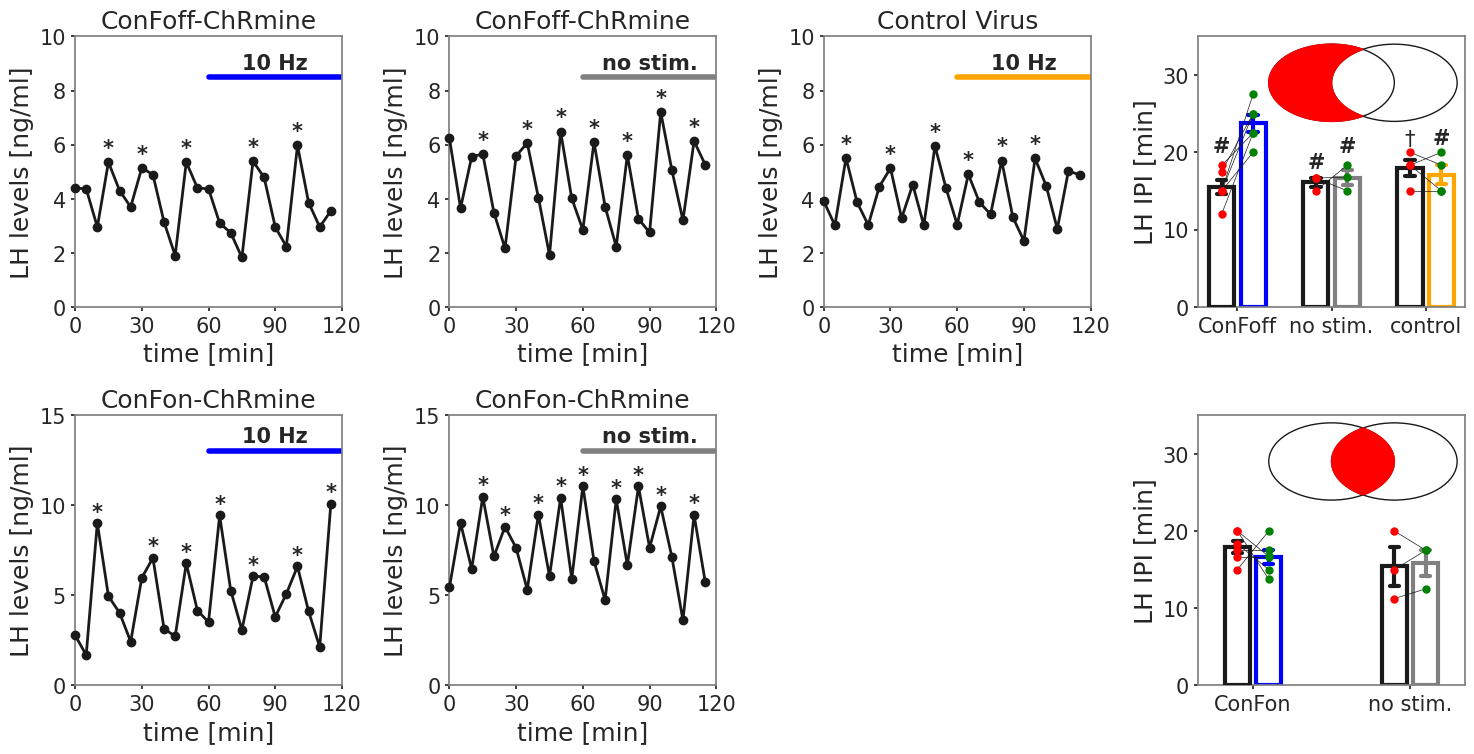

In [ ]:
# Create a figure with a specific size
fig = plt.figure(figsize=(15, 11))

# Plot 1: LH level for ConFoff-ChRmine with 10 Hz stimulation
ax = plt.subplot(3, 4, 1)  # Create a subplot at position (3 rows, 4 columns, 1st plot)
ax.plot(data_fig1ABC['figure 1A'], 'k', marker='.', ms=12, clip_on=False, zorder=10)  # Plot the data
ax.plot([12, 24], [8.5, 8.5], lw=4, c='blue')  # Plot a reference line

# Add star annotations for specific points
stars_x = [3, 6, 10, 16, 20]
stars_y = [data_fig1ABC.iloc[i, 0] + 0.3 for i in stars_x]
for i in range(len(stars_x)):
    ax.text(stars_x[i], stars_y[i], '*', weight='bold', ha='center')

# Add text and formatting for the axes and title
ax.text(18, 8.8, '10 Hz', weight='bold', ha='center')
ax.set_ylim(0, 10)
ax.set_xlim(0, 24)
ax.set_xticks(range(0, 30, 6), labels=range(0, 150, 30))
ax.set_xlabel('time [min]')
ax.set_ylabel('LH levels [ng/ml]')
ax.set_title('ConFoff-ChRmine')


# Plot 2: LH level for ConFoff-ChRmine with no stimulation
ax = plt.subplot(3, 4, 2)
ax.plot(data_fig1ABC['figure 1B'], 'k', marker='.', ms=12, clip_on=False, zorder=10)
ax.plot([12, 24], [8.5, 8.5], lw=4, c='gray')

stars_x = [3, 7, 10, 13, 16, 19, 22]
stars_y = [data_fig1ABC.iloc[i, 1] + 0.3 for i in stars_x]
for i in range(len(stars_x)):
    ax.text(stars_x[i], stars_y[i], '*', weight='bold', ha='center')

ax.text(18, 8.8, 'no stim.', weight='bold', ha='center')
ax.set_ylim(0, 10)
ax.set_xlim(0, 24)
ax.set_xticks(range(0, 30, 6), labels=range(0, 150, 30))
ax.set_xlabel('time [min]')
ax.set_ylabel('LH levels [ng/ml]')
ax.set_title('ConFoff-ChRmine')


# Plot 3: LH level for control virus with 10 Hz stimulation
ax = plt.subplot(3, 4, 3)
ax.plot(data_fig1ABC['figure 1C'], 'k', marker='.', ms=12, clip_on=False, zorder=10)
ax.plot([12, 24], [8.5, 8.5], lw=4, c='orange')

stars_x = [2, 6, 10, 13, 16, 19]
stars_y = [data_fig1ABC.iloc[i, 2] + 0.3 for i in stars_x]
for i in range(len(stars_x)):
    ax.text(stars_x[i], stars_y[i], '*', weight='bold', ha='center')

ax.text(18, 8.8, '10 Hz', weight='bold', ha='center')
ax.set_ylim(0, 10)
ax.set_xlim(0, 24)
ax.set_xticks(range(0, 30, 6), labels=range(0, 150, 30))
ax.set_xlabel('time [min]')
ax.set_ylabel('LH levels [ng/ml]')
ax.set_title('Control Virus')

# Plot 4: LH inter-pulse interval (IPI) for the three experimental setups above
ax = plt.subplot(3, 4, 4)

# Plot bars for 'ConFoff (before)' and 'ConFoff (after)'
bar = data_fig1D['ConFoff (before)']
df = pd.DataFrame(dict(x=np.repeat([0], len(bar)), y=bar))
sns.barplot(x='x', y='y', data=df, color='k', fill=False,
            order=range(0, 8), errorbar='se', capsize=0.3, zorder=5)
ax.text(0, 20, '#', weight='bold', ha='center')

bar = data_fig1D['ConFoff (after)']
df = pd.DataFrame(dict(x=np.repeat([1], len(bar)), y=bar))
sns.barplot(x='x', y='y', data=df, color='blue', fill=False,
            order=range(0, 8), errorbar='se', capsize=0.3)

# Plot bars for 'No Stimulation (before)' and 'No Stimulation (after)'
bar = data_fig1D['No Stimulation (before)']
df = pd.DataFrame(dict(x=np.repeat([3], len(bar)), y=bar))
sns.barplot(x='x', y='y', data=df, color='k', fill=False,
            order=range(0, 8), errorbar='se', capsize=0.3)
ax.text(3, 18, '#', weight='bold', ha='center')

bar = data_fig1D['No Stimulation (after)']
df = pd.DataFrame(dict(x=np.repeat([4], len(bar)), y=bar))
sns.barplot(x='x', y='y', data=df, color='gray', fill=False,
            order=range(0, 8), errorbar='se', capsize=0.3)
ax.text(4, 20, '#', weight='bold', ha='center')

# Plot bars for 'Control Virus (before)' and 'Control Virus (after)'
bar = data_fig1D['Control Virus (before)']
df = pd.DataFrame(dict(x=np.repeat([6], len(bar)), y=bar))
sns.barplot(x='x', y='y', data=df, color='k', fill=False,
            order=range(0, 8), errorbar='se', capsize=0.3)
ax.text(6, 21, '$\dagger$', weight='bold', ha='center')

bar = data_fig1D['Control Virus (after)']
df = pd.DataFrame(dict(x=np.repeat([7], len(bar)), y=bar))
sns.barplot(x='x', y='y', data=df, color='orange', fill=False,
            order=range(0, 8), errorbar='se', capsize=0.3)
ax.text(7, 21, '#', weight='bold', ha='center')

# Add connecting lines and scatter points
for i in range(6):
    ax.plot((0, 1), (data_fig1D.iloc[i, 0], data_fig1D.iloc[i, 1]), lw=0.5, c='k')
    ax.plot((3, 4), (data_fig1D.iloc[i, 2], data_fig1D.iloc[i, 3]), lw=0.5, c='k')
    ax.plot((6, 7), (data_fig1D.iloc[i, 4], data_fig1D.iloc[i, 5]), lw=0.5, c='k')

ax.scatter([0]*6, data_fig1D['ConFoff (before)'], s=25, c='red', zorder=5)
ax.scatter([1]*6, data_fig1D['ConFoff (after)'], s=25, c='green', zorder=5)
ax.scatter([3]*6, data_fig1D['No Stimulation (before)'], s=25, c='red', zorder=5)
ax.scatter([4]*6, data_fig1D['No Stimulation (after)'],s=25, c='green', zorder=5)
ax.scatter([6]*6, data_fig1D['Control Virus (before)'],s=25, c='red', zorder=5)
ax.scatter([7]*6, data_fig1D['Control Virus (after)'],s=25, c='green', zorder=5)


###### Adding Ven diagram
# Parameters for ellipses
ellipse1_center = (3.5, 29)
ellipse2_center = (5.5, 29)
width, height = 4, 10  # width and height for both ellipses

# Function to generate ellipse vertices
def ellipse_vertices(center, width, height, num_points=100):
    theta = np.linspace(0, 2 * np.pi, num_points)
    x = center[0] + (width / 2) * np.cos(theta)
    y = center[1] + (height / 2) * np.sin(theta)
    return np.vstack((x, y)).T

# Create shapely polygons for each ellipse
ellipse1_vertices = ellipse_vertices(ellipse1_center, width, height)
ellipse2_vertices = ellipse_vertices(ellipse2_center, width, height)
shapely_ellipse1 = ShapelyPolygon(ellipse1_vertices)
shapely_ellipse2 = ShapelyPolygon(ellipse2_vertices)

# Calculate non-overlapping region for the first ellipse
non_overlap_ellipse1 = shapely_ellipse1.difference(shapely_ellipse2)

# Add the original ellipses using matplotlib patches
ellipse1_patch = Ellipse(ellipse1_center, width, height, ec='k', fc='none', lw=1)
ellipse2_patch = Ellipse(ellipse2_center, width, height, ec='k', fc='none', lw=1)
ax.add_patch(ellipse1_patch)
ax.add_patch(ellipse2_patch)

# Plot the non-overlapping region of ellipse1
if not non_overlap_ellipse1.is_empty:
    for geom in getattr(non_overlap_ellipse1, "geoms", [non_overlap_ellipse1]):
        x, y = geom.exterior.xy
        ax.fill(x, y, color='red', alpha=1, label='Non-overlapping part of Ellipse 1')

ax.set_xlabel('')
ax.set_ylabel('LH IPI [min]')
ax.set_xlim(-0.75, 7.75)
ax.set_ylim(0, 35)
ax.set_xticks([0.5, 3.5, 6.5], labels=['ConFoff', 'no stim.', 'control'])


# Plot 5: LH level for ConFon-ChRmine with 10 Hz stimulation
ax = plt.subplot(3, 4, 5)
ax.plot(data_fig4AB['figure 4A'], 'k', marker='.', ms=12, clip_on=False, zorder=10)
ax.plot([12, 24], [13, 13], lw=4, c='blue')

stars_x = [2, 7, 10, 13, 16, 20, 23]
stars_y = [data_fig4AB.iloc[i, 0]+0.3 for i in stars_x]
stars_text = ['*'] * len(stars_x)
for i in range(len(stars_x)):
	ax.text(stars_x[i], stars_y[i], stars_text[i], weight='bold', ha='center')

ax.text(18, 13.5, '10 Hz', weight='bold', ha='center')
ax.set_ylim(0, 15)
ax.set_xlim(0, 24)
ax.set_xticks(range(0, 30, 6), labels=range(0, 150, 30))
ax.set_yticks(range(0, 20, 5), labels=range(0, 20, 5))
ax.set_xlabel('time [min]')
ax.set_ylabel('LH levels [ng/ml]')
ax.set_title('ConFon-ChRmine')


# Plot 6: LH level for ConFon-ChRmine with no stimulation
ax = plt.subplot(3, 4, 6)
ax.plot(data_fig4AB['figure 4B'], 'k', marker='.', ms=12, clip_on=False, zorder=10)
ax.plot([12, 24], [13, 13], lw=4, c='gray')

stars_x = [3, 5, 8, 10, 12, 15, 17, 19, 22]
stars_y = [data_fig4AB.iloc[i, 1]+0.3 for i in stars_x]
stars_text = ['*'] * len(stars_x)
for i in range(len(stars_x)):
	ax.text(stars_x[i], stars_y[i], stars_text[i], weight='bold', ha='center')

ax.text(18, 13.5, 'no stim.', weight='bold', ha='center')
ax.set_ylim(0, 15)
ax.set_xlim(0, 24)
ax.set_xticks(range(0, 30, 6), labels=range(0, 150, 30))
ax.set_yticks(range(0, 20, 5), labels=range(0, 20, 5))
ax.set_xlabel('time [min]')
ax.set_ylabel('LH levels [ng/ml]')
ax.set_title('ConFon-ChRmine')


# Plot 7: LH IPI for two experimental setups above
ax = plt.subplot(3, 4, 8)

# Plot bars for 'ConFon (before)' and 'ConFon (after)'
bar = data_fig4C['ConFon (before)']
df = pd.DataFrame(dict(x=np.repeat([0], len(bar)), y=bar))
sns.barplot(x='x', y='y', data=df, color='k', fill=False,
            order=range(0, 8), errorbar='se', capsize=0.3, zorder=5)

bar = data_fig4C['ConFon (after)']
df = pd.DataFrame(dict(x=np.repeat([1], len(bar)), y=bar))
sns.barplot(x='x', y='y', data=df, color='blue', fill=False,
            order=range(0, 8), errorbar='se', capsize=0.3)

bar = data_fig4C['No Stimulation (before)']
df = pd.DataFrame(dict(x=np.repeat([5], len(bar)), y=bar))
sns.barplot(x='x', y='y', data=df, color='k', fill=False,
            order=range(0, 8), errorbar='se', capsize=0.3)

# Plot bars for 'No Stimulation (before)' and 'No Stimulation (after)'
bar = data_fig4C['No Stimulation (after)']
df = pd.DataFrame(dict(x=np.repeat([6], len(bar)), y=bar))
sns.barplot(x='x', y='y', data=df, color='gray', fill=False,
            order=range(0, 8), errorbar='se', capsize=0.3)

# Add connecting lines and scatter points
for i in range(6):
    ax.plot((0, 1), (data_fig4C.iloc[i, 0], data_fig4C.iloc[i, 1]), lw=0.5, c='k')
    ax.plot((5, 6), (data_fig4C.iloc[i, 2], data_fig4C.iloc[i, 3]), lw=0.5, c='k')

ax.scatter([0]*6, data_fig4C['ConFon (before)'], s=25, c='red', zorder=5)
ax.scatter([1]*6, data_fig4C['ConFon (after)'], s=25, c='green', zorder=5)
ax.scatter([5]*6, data_fig4C['No Stimulation (before)'], s=25, c='red', zorder=5)
ax.scatter([6]*6, data_fig4C['No Stimulation (after)'], s=25, c='green', zorder=5)

###### Adding Ven diagram
# Parameters for ellipses
ellipse1_center = (3, 29)
ellipse2_center = (5, 29)
width, height = 4, 10  # width and height for both ellipses

# Function to generate ellipse vertices
def ellipse_vertices(center, width, height, num_points=100):
    theta = np.linspace(0, 2 * np.pi, num_points)
    x = center[0] + (width / 2) * np.cos(theta)
    y = center[1] + (height / 2) * np.sin(theta)
    return np.vstack((x, y)).T

# Create shapely polygons for each ellipse
ellipse1_vertices = ellipse_vertices(ellipse1_center, width, height)
ellipse2_vertices = ellipse_vertices(ellipse2_center, width, height)
shapely_ellipse1 = ShapelyPolygon(ellipse1_vertices)
shapely_ellipse2 = ShapelyPolygon(ellipse2_vertices)

# Calculate non-overlapping region for the first ellipse
non_overlap_ellipse1 = shapely_ellipse1.intersection(shapely_ellipse2)

# Add the original ellipses using matplotlib patches
ellipse1_patch = Ellipse(ellipse1_center, width, height, ec='k', fc='none', lw=1)
ellipse2_patch = Ellipse(ellipse2_center, width, height, ec='k', fc='none', lw=1)
ax.add_patch(ellipse1_patch)
ax.add_patch(ellipse2_patch)

# Plot the non-overlapping region of ellipse1
if not non_overlap_ellipse1.is_empty:
    for geom in getattr(non_overlap_ellipse1, "geoms", [non_overlap_ellipse1]):
        x, y = geom.exterior.xy
        ax.fill(x, y, color='red', alpha=1)

ax.set_xlabel('')
ax.set_ylabel('LH IPI [min]')
ax.set_xlim(-1.25, 7.25)
ax.set_ylim(0, 35)
ax.set_xticks([0.5, 5.5], labels=['ConFon', 'no stim.'])

# Adjust layout for better spacing
plt.tight_layout()

# Save the figure as PNG file
# fig.savefig("./gdrive/My Drive/Fig5.png", dpi=300)

# Display the figure
plt.show()

# Figure 6

In [ ]:
# Load the data
data_fig2ABC = pd.read_csv(fig2ABC)

# Display the last few rows of the dataset
data_fig2ABC.tail()

figure 2A  figure 2B  figure 2C
19   0.899110   3.272071   5.710933
20   0.863978   0.439857   4.369912
21   0.697069   0.315029   3.104687
22   0.729031   4.512274   3.622922
23   0.918972   4.180184   6.314151

In [ ]:
# Load the data
data_fig2D = pd.read_csv(fig2D)

# Display the last few rows of the dataset
data_fig2D.head()

ChR (before)  ChR (after)  No Stimulation (before)  No Stimulation (after)  \
0          22.5         32.5                     22.5                    20.0   
1          15.0         30.0                     15.0                    22.5   
2          12.5         60.0                     35.0                    15.0   
3          22.5         50.0                     20.0                    22.5   
4          20.0         75.0                      NaN                     NaN   

   Control Virus (before)  Control Virus (after)  
0                    15.0                  16.67  
1                    17.5                  20.00  
2                    15.0                  18.33  
3                     NaN                    NaN  
4                     NaN                    NaN

In [ ]:
# Load the data
data_fig3AB = pd.read_csv(fig3AB)

# Display the last few rows of the dataset
data_fig3AB.tail()

figure 3A  figure 3B
19   6.743067   5.948853
20   4.415524   3.015954
21   8.358616   7.350813
22   4.922814   7.384871
23   3.401556   4.814085

In [ ]:
# Load the data
data_fig3C = pd.read_csv(fig3C)

# Display the last few rows of the dataset
data_fig3C.head()

ConFoff + CoffFon (before)  ConFoff + CoffFon (after)  \
0                   15.000000                  15.000000   
1                   17.500000                  16.666667   
2                   16.666667                  15.000000   
3                   22.500000                  20.000000   
4                   15.000000                  20.000000   

   No Stimulation (before)  No Stimulation (after)  
0                    11.67                    17.5  
1                    17.50                    17.5  
2                    20.00                    15.0  
3                      NaN                     NaN  
4                      NaN                     NaN

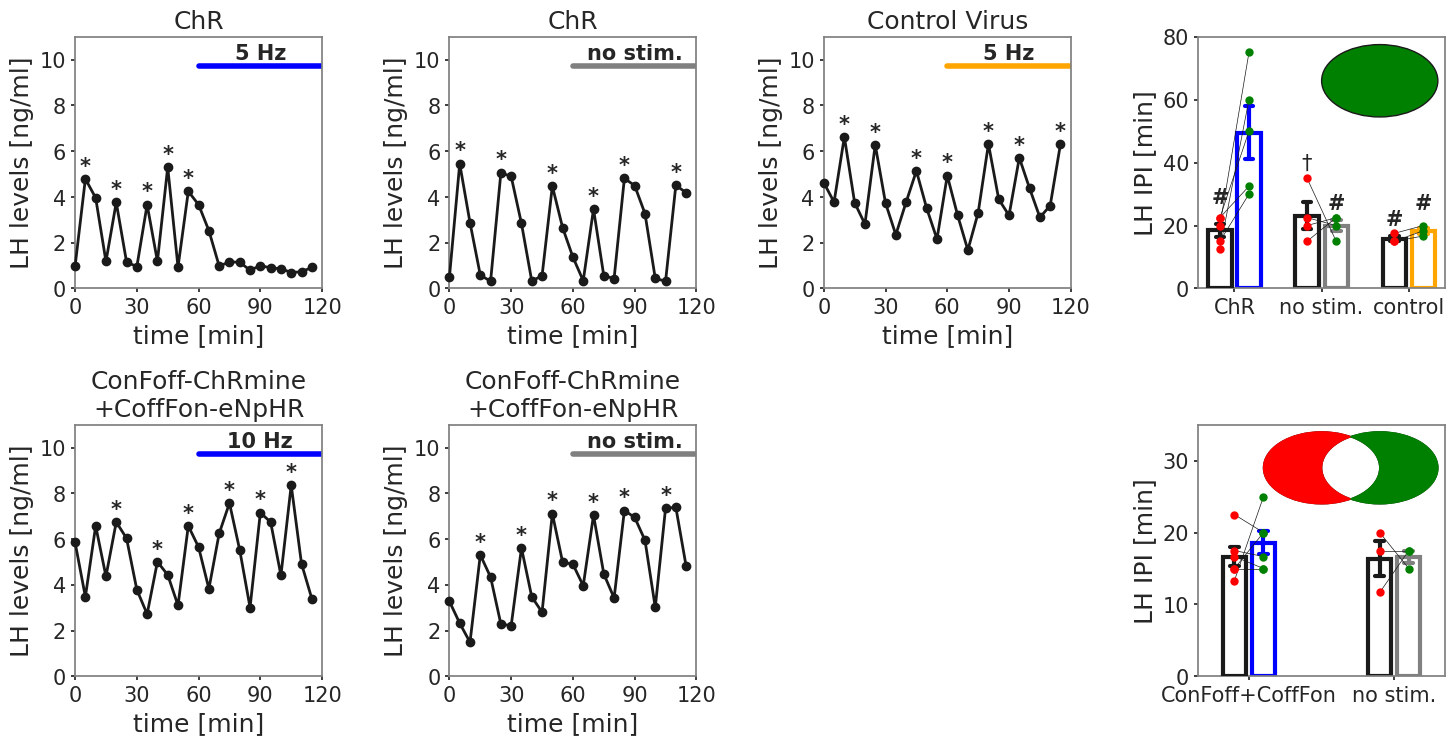

In [ ]:
# Create a figure with a specific size
fig = plt.figure(figsize=(15, 11))

# Plot 1: LH level for ChR with 5 Hz stimulation
ax = plt.subplot(3, 4, 1)
ax.plot(data_fig2ABC['figure 2A'], 'k', marker='.', ms=12, clip_on=False, zorder=10)
ax.plot([12, 24], [9.7, 9.7], lw=4, c='blue')

stars_x = [1, 4, 7, 9, 11]
stars_y = [data_fig2ABC.iloc[i, 0]+0.3 for i in stars_x]
stars_text = ['*'] * len(stars_x)
for i in range(len(stars_x)):
	ax.text(stars_x[i], stars_y[i], stars_text[i], weight='bold', ha='center')

ax.text(18, 10, '5 Hz', weight='bold', ha='center')
ax.set_ylim(0, 11)
ax.set_xlim(0, 24)
ax.set_xticks(range(0, 30, 6), labels=range(0, 150, 30))
ax.set_xlabel('time [min]')
ax.set_ylabel('LH levels [ng/ml]')
ax.set_title('ChR')


# Plot 2: LH level for ChR with no stimulation
ax = plt.subplot(3, 4, 2)
ax.plot(data_fig2ABC['figure 2B'], 'k', marker='.', ms=12, clip_on=False, zorder=10)
ax.plot([12, 24], [9.7, 9.7], lw=4, c='gray')

stars_x = [1, 5, 10, 14, 17, 22]
stars_y = [data_fig2ABC.iloc[i, 1]+0.3 for i in stars_x]
stars_text = ['*'] * len(stars_x)
for i in range(len(stars_x)):
	ax.text(stars_x[i], stars_y[i], stars_text[i], weight='bold', ha='center')

ax.text(18, 10, 'no stim.', weight='bold', ha='center')
ax.set_ylim(0, 11)
ax.set_xlim(0, 24)
ax.set_xticks(range(0, 30, 6), labels=range(0, 150, 30))
ax.set_xlabel('time [min]')
ax.set_ylabel('LH levels [ng/ml]')
ax.set_title('ChR')


# Plot 3: LH level for control virus with 5 Hz stimulation
ax = plt.subplot(3, 4, 3)
ax.plot(data_fig2ABC['figure 2C'], 'k', marker='.', ms=12, clip_on=False, zorder=10)
ax.plot([12, 24], [9.7, 9.7], lw=4, c='orange')

stars_x = [2, 5, 9, 12, 16, 19, 23]
stars_y = [data_fig2ABC.iloc[i, 2]+0.3 for i in stars_x]
stars_text = ['*'] * len(stars_x)
for i in range(len(stars_x)):
	ax.text(stars_x[i], stars_y[i], stars_text[i], weight='bold', ha='center')

ax.text(18, 10, '5 Hz', weight='bold', ha='center')
ax.set_ylim(0, 11)
ax.set_xlim(0, 24)
ax.set_xticks(range(0, 30, 6), labels=range(0, 150, 30))
ax.set_xlabel('time [min]')
ax.set_ylabel('LH levels [ng/ml]')
ax.set_title('Control Virus')

# Plot 4: LH inter-pulse interval (IPI) for the three experimental setups above
ax = plt.subplot(3, 4, 4)

# Plot bars for 'ChR (before)' and 'ChR (after)'
bar = data_fig2D['ChR (before)']
df = pd.DataFrame(dict(x=np.repeat([0], len(bar)), y=bar))
sns.barplot(x='x', y='y', data=df, color='k', fill=False,
            order=range(0, 8), errorbar='se', capsize=0.3, zorder=5)
ax.text(0, 27, '#', weight='bold', ha='center')

bar = data_fig2D['ChR (after)']
df = pd.DataFrame(dict(x=np.repeat([1], len(bar)), y=bar))
sns.barplot(x='x', y='y', data=df, color='blue', fill=False,
            order=range(0, 8), errorbar='se', capsize=0.3)

# Plot bars for 'No Stimulation (before)' and 'No Stimulation (after)'
bar = data_fig2D['No Stimulation (before)']
df = pd.DataFrame(dict(x=np.repeat([3], len(bar)), y=bar))
sns.barplot(x='x', y='y', data=df, color='k', fill=False,
            order=range(0, 8), errorbar='se', capsize=0.3)
ax.text(3, 38, '$\dagger$', weight='bold', ha='center')

bar = data_fig2D['No Stimulation (after)']
df = pd.DataFrame(dict(x=np.repeat([4], len(bar)), y=bar))
sns.barplot(x='x', y='y', data=df, color='gray', fill=False,
            order=range(0, 8), errorbar='se', capsize=0.3)
ax.text(4, 25, '#', weight='bold', ha='center')

# Plot bars for 'Control Virus (before)' and 'Control Virus (after)'
bar = data_fig2D['Control Virus (before)']
df = pd.DataFrame(dict(x=np.repeat([6], len(bar)), y=bar))
sns.barplot(x='x', y='y', data=df, color='k', fill=False,
            order=range(0, 8), errorbar='se', capsize=0.3)
ax.text(6, 20, '#', weight='bold', ha='center')

bar = data_fig2D['Control Virus (after)']
df = pd.DataFrame(dict(x=np.repeat([7], len(bar)), y=bar))
sns.barplot(x='x', y='y', data=df, color='orange', fill=False,
            order=range(0, 8), errorbar='se', capsize=0.3)
ax.text(7, 25, '#', weight='bold', ha='center')

# Add connecting lines and scatter points
for i in range(5):
    ax.plot((0, 1), (data_fig2D.iloc[i, 0], data_fig2D.iloc[i, 1]), lw=0.5, c='k')
    ax.plot((3, 4), (data_fig2D.iloc[i, 2], data_fig2D.iloc[i, 3]), lw=0.5, c='k')
    ax.plot((6, 7), (data_fig2D.iloc[i, 4], data_fig2D.iloc[i, 5]), lw=0.5, c='k')

ax.scatter([0]*5, data_fig2D['ChR (before)'], s=25, c='red', zorder=5)
ax.scatter([1]*5, data_fig2D['ChR (after)'], s=25, c='green', zorder=5)
ax.scatter([3]*5, data_fig2D['No Stimulation (before)'], s=25, c='red', zorder=5)
ax.scatter([4]*5, data_fig2D['No Stimulation (after)'], s=25, c='green', zorder=5)
ax.scatter([6]*5, data_fig2D['Control Virus (before)'], s=25, c='red', zorder=5)
ax.scatter([7]*5, data_fig2D['Control Virus (after)'], s=25, c='green', zorder=5)

e1 = Ellipse((5.5, 66), 4, 23, angle=0, lw=1, ec='k', facecolor='green', zorder=2)
ax.add_patch(e1)

ax.set_xlabel('')
ax.set_ylabel('LH IPI [min]')
ax.set_xlim(-0.75, 7.75)
ax.set_ylim(0, 80)
ax.set_xticks([0.5, 3.5, 6.5], labels=['ChR', 'no stim.', 'control'])
ax.set_yticks(range(0, 90, 20), labels=range(0, 90, 20))


# Plot 5: LH level for ConFoff-ChRmine\n+CoffFon-eNpHR with 10 Hz stimulation
ax = plt.subplot(3, 4, 5)
ax.plot(data_fig3AB['figure 3A'], 'k', marker='.', ms=12, clip_on=False, zorder=10)
ax.plot([12, 24], [9.7, 9.7], lw=4, c='blue')

stars_x = [4, 8, 11, 15, 18, 21]
stars_y = [data_fig3AB.iloc[i, 0]+0.3 for i in stars_x]
stars_text = ['*'] * len(stars_x)
for i in range(len(stars_x)):
	ax.text(stars_x[i], stars_y[i], stars_text[i], weight='bold', ha='center')

ax.text(18, 10, '10 Hz', weight='bold', ha='center')
ax.set_ylim(0, 11)
ax.set_xlim(0, 24)
ax.set_xticks(range(0, 30, 6), labels=range(0, 150, 30))
ax.set_xlabel('time [min]')
ax.set_ylabel('LH levels [ng/ml]')
ax.set_title('ConFoff-ChRmine\n+CoffFon-eNpHR')


# Plot 6: LH level for ConFoff-ChRmine\n+CoffFon-eNpHR with no stimulation
ax = plt.subplot(3, 4, 6)
ax.plot(data_fig3AB['figure 3B'], 'k', marker='.', ms=12, clip_on=False, zorder=10)
ax.plot([12, 24], [9.7, 9.7], lw=4, c='gray')

stars_x = [3, 7, 10, 14, 17, 21]
stars_y = [data_fig3AB.iloc[i, 1]+0.3 for i in stars_x]
stars_text = ['*'] * len(stars_x)
for i in range(len(stars_x)):
	ax.text(stars_x[i], stars_y[i], stars_text[i], weight='bold', ha='center')

ax.text(18, 10, 'no stim.', weight='bold', ha='center')
ax.set_ylim(0, 11)
ax.set_xlim(0, 24)
ax.set_xticks(range(0, 30, 6), labels=range(0, 150, 30))
ax.set_xlabel('time [min]')
ax.set_ylabel('LH levels [ng/ml]')
ax.set_title('ConFoff-ChRmine\n+CoffFon-eNpHR')


# Plot 4: LH inter-pulse interval (IPI) for the three experimental setups above
ax = plt.subplot(3, 4, 8)

# Plot bars for 'ConFoff + CoffFon (before)' and 'ConFoff + CoffFon (after)'
bar = data_fig3C['ConFoff + CoffFon (before)']
df = pd.DataFrame(dict(x=np.repeat([0], len(bar)), y=bar))
sns.barplot(x='x', y='y', data=df, color='k', fill=False,
            order=range(0, 8), errorbar='se', capsize=0.3, zorder=5)

bar = data_fig3C['ConFoff + CoffFon (after)']
df = pd.DataFrame(dict(x=np.repeat([1], len(bar)), y=bar))
sns.barplot(x='x', y='y', data=df, color='blue', fill=False,
            order=range(0, 8), errorbar='se', capsize=0.3)

# Plot bars for 'No Stimulation (before)' and 'No Stimulation (after)'
bar = data_fig3C['No Stimulation (before)']
df = pd.DataFrame(dict(x=np.repeat([5], len(bar)), y=bar))
sns.barplot(x='x', y='y', data=df, color='k', fill=False,
            order=range(0, 8), errorbar='se', capsize=0.3)

bar = data_fig3C['No Stimulation (after)']
df = pd.DataFrame(dict(x=np.repeat([6], len(bar)), y=bar))
sns.barplot(x='x', y='y', data=df, color='gray', fill=False,
            order=range(0, 8), errorbar='se', capsize=0.3)

# Add connecting lines and scatter points
for i in range(6):
    ax.plot((0, 1), (data_fig3C.iloc[i, 0], data_fig3C.iloc[i, 1]), lw=0.5, c='k')
    ax.plot((5, 6), (data_fig3C.iloc[i, 2], data_fig3C.iloc[i, 3]), lw=0.5, c='k')

ax.scatter([0]*6, data_fig3C['ConFoff + CoffFon (before)'], s=25, c='red', zorder=5)
ax.scatter([1]*6, data_fig3C['ConFoff + CoffFon (after)'], s=25, c='green', zorder=5)
ax.scatter([5]*6, data_fig3C['No Stimulation (before)'], s=25, c='red', zorder=5)
ax.scatter([6]*6, data_fig3C['No Stimulation (after)'], s=25, c='green', zorder=5)


###### Adding Ven diagram
# Parameters for ellipses
ellipse1_center = (3, 29)
ellipse2_center = (5, 29)
width, height = 4, 10  # width and height for both ellipses

# Function to generate ellipse vertices
def ellipse_vertices(center, width, height, num_points=100):
    theta = np.linspace(0, 2 * np.pi, num_points)
    x = center[0] + (width / 2) * np.cos(theta)
    y = center[1] + (height / 2) * np.sin(theta)
    return np.vstack((x, y)).T

# Create shapely polygons for each ellipse
ellipse1_vertices = ellipse_vertices(ellipse1_center, width, height)
ellipse2_vertices = ellipse_vertices(ellipse2_center, width, height)
shapely_ellipse1 = ShapelyPolygon(ellipse1_vertices)
shapely_ellipse2 = ShapelyPolygon(ellipse2_vertices)

# Calculate non-overlapping region for the first ellipse
non_overlap_ellipse1 = shapely_ellipse1.difference(shapely_ellipse2)
non_overlap_ellipse2 = shapely_ellipse2.difference(shapely_ellipse1)

# Add the original ellipses using matplotlib patches
ellipse1_patch = Ellipse(ellipse1_center, width, height, ec='k', fc='none', lw=1)
ellipse2_patch = Ellipse(ellipse2_center, width, height, ec='k', fc='none', lw=1)
ax.add_patch(ellipse1_patch)
ax.add_patch(ellipse2_patch)

# Plot the non-overlapping region of ellipse1
if not non_overlap_ellipse1.is_empty:
    for geom in getattr(non_overlap_ellipse1, "geoms", [non_overlap_ellipse1]):
        x, y = geom.exterior.xy
        ax.fill(x, y, color='red', alpha=1)

# Plot the non-overlapping region of ellipse2
if not non_overlap_ellipse2.is_empty:
    for geom in getattr(non_overlap_ellipse2, "geoms", [non_overlap_ellipse2]):
        x, y = geom.exterior.xy
        ax.fill(x, y, color='green', alpha=1)

ax.set_xlabel('')
ax.set_ylabel('LH IPI [min]')
ax.set_xlim(-1.25, 7.25)
ax.set_ylim(0, 35)
ax.set_xticks([0.5, 5.5], labels=['ConFoff+CoffFon', 'no stim.'])

# Adjust layout for better spacing
plt.tight_layout()

# Save the figure as PNG file
# fig.savefig("./gdrive/My Drive/Fig6.png", dpi=300)

# Display the figure
plt.show()

# Figure S1

In [ ]:
# Load the p-values data
pvalues = pd.read_csv(pvalues_path)

# Display the top few rows of the dataset
pvalues.head()

Xcorr           Cov Animal Intervention
0  6.600000e-08  2.640000e-05     G7  Stimulation
1  1.130000e-04  5.310000e-07     G7  Stimulation
2  2.180000e-26  8.890000e-17     G8  Stimulation
3  2.420000e-11  8.790000e-04     G8  Stimulation
4  2.540000e-01  2.540000e-01     G8  Stimulation

In [ ]:
# Extract the column names (categories) from the p-values dataframe
categories_pvalues = pvalues.columns.tolist()

In [ ]:
# Drop NaN values from the 'Xcorr' column and convert it to a list
pvalues_corr = list(pvalues['Cov'].dropna())

# Define the ranges for grouping the correlation values
pvalues_pool_corr_stim = [
    pvalues_corr[0:2],       # First group: 0 to 2
    pvalues_corr[2:6],       # Second group: 2 to 6
    pvalues_corr[6:10],      # Third group: 6 to 10
    pvalues_corr[10:13],     # Fourth group: 10 to 13
    pvalues_corr[13:16],     # Fifth group: 13 to 16
    pvalues_corr[16:20]      # Sixth group: 16 to 20
]

# Same method applied for 'stress' related correlation groups
pvalues_pool_corr_stress = [
    pvalues_corr[20:21],     # First group: 20 to 21
    pvalues_corr[21:22],     # Second group: 21 to 22
    pvalues_corr[22:23],     # Third group: 22 to 23
    pvalues_corr[23:24],     # Fourth group: 23 to 24
    pvalues_corr[24:25],     # Fifth group: 24 to 25
    pvalues_corr[25:27]      # Sixth group: 25 to 27
]

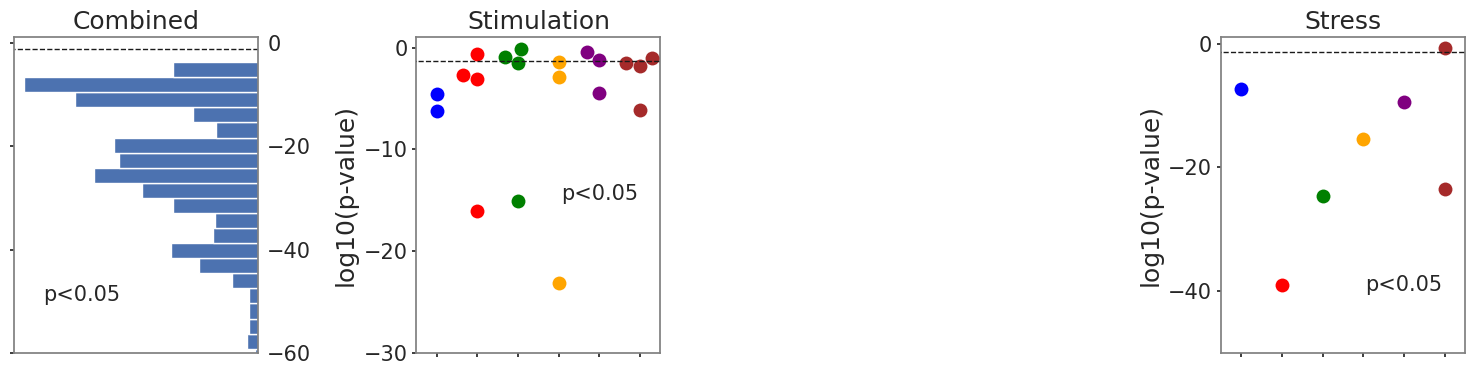

In [ ]:
# Set up figure dimensions and grid
fig = plt.figure(figsize=(15, 4))  # Figure size
gs = gridspec.GridSpec(1, 4, figure=fig)  # GridSpec for 1 row and 4 columns

# Plot 1: Combined p-values histogram (for stimulation)
ax = fig.add_subplot(gs[0])  # Create subplot at the first position in the grid
df = fisher_combine_pvalues(pvalues_pool_corr_stim)  # Combine p-values for stimulation
df = np.log10(df)  # Log-transform the p-values
ax.hist(df, bins=20, orientation='horizontal')  # Create a horizontal histogram
ax.plot([0, 180], [np.log10(0.05), np.log10(0.05)], 'k--', lw=1)  # Add a dashed line for p < 0.05 threshold

# Labeling the plot
ax.set_title('Combined')  # Set plot title
ax.set_xticks([])  # Remove x-axis ticks
ax.set_yticks([-60, -40, -20, 0])  # Set y-axis ticks
ax.set_xlim([180, 0])  # Set x-axis limit (reversed)
ax.set_ylim(-60, 1)  # Set y-axis limit
ax.tick_params(axis='y', labelright=True, labelleft=False)  # Remove left y-axis ticks and add right ticks
ax.text(130, -50, 'p<0.05', ha='center')  # Add text for p < 0.05

# Define colors for stimulation and stress categories
colour_list = ['blue', 'red', 'green', 'orange', 'purple', 'brown']

# Plot 2: Stimulation conditions with swarm plots
ax = fig.add_subplot(gs[1])  # Create subplot for stimulation
for i in range(6):
    pvals = [np.log10(_) for _ in pvalues_pool_corr_stim[i]]  # Log-transform p-values
    df = pd.DataFrame(dict(x=np.repeat([i], len(pvals)), y=pvals))  # Create DataFrame
    sns.swarmplot(x='x', y='y', data=df, color=colour_list[i], size=10, clip_on=False)  # Create swarmplot for each group
ax.plot([-1, 6], [np.log10(0.05), np.log10(0.05)], 'k--', lw=1, zorder=20)  # Add threshold line

# Labeling the plot
ax.set_title('Stimulation')  # Set plot title
ax.set_xlim(-0.5, 5.5)  # Set x-axis limit
ax.set_ylim(-30, 1)  # Set y-axis limit
ax.set_xlabel('')  # Remove x-axis label
ax.set_ylabel('log10(p-value)')  # Set y-axis label
ax.yaxis.set_label_position("left")  # Set y-axis label on the left
ax.set_xticks([0, 1, 2, 3, 4, 5], labels=[], rotation=90)  # Remove x-axis ticks and rotate the labels
ax.set_yticks([-30, -20, -10, 0])  # Set y-axis ticks
ax.tick_params(axis='y', labelright=False, labelleft=True)  # Keep left y-axis labels
ax.text(4, -15, 'p<0.05', ha='center')  # Add text for p < 0.05

# Plot 3: Stress conditions with swarm plots
ax = fig.add_subplot(gs[3])  # Create subplot for stress
for i in range(6):
    pvals = [np.log10(_) for _ in pvalues_pool_corr_stress[i]]  # Log-transform p-values
    df = pd.DataFrame(dict(x=np.repeat([i], len(pvals)), y=pvals))  # Create DataFrame
    sns.swarmplot(x='x', y='y', data=df, color=colour_list[i], size=10)  # Create swarmplot for each group
ax.plot([-1, 6], [np.log10(0.05), np.log10(0.05)], 'k--', lw=1, zorder=20)  # Add threshold line

# Labeling the plot
ax.set_title('Stress')  # Set plot title
ax.set_xlim(-0.5, 5.5)  # Set x-axis limit
ax.set_ylim(-50, 1)  # Set y-axis limit
ax.set_xlabel('')  # Remove x-axis label
ax.set_ylabel('log10(p-value)')  # Set y-axis label
ax.yaxis.set_label_position("left")  # Set y-axis label on the left
ax.set_xticks([0, 1, 2, 3, 4, 5], labels=[], rotation=90)  # Remove x-axis ticks and rotate the labels
ax.set_yticks([-40, -20, 0])  # Set y-axis ticks
ax.tick_params(axis='y', labelright=False, labelleft=True)  # Keep left y-axis labels
ax.text(4, -40, 'p<0.05', ha='center')  # Add text for p < 0.05

# Adjust layout for better spacing
plt.tight_layout()

# Save the figure as a PNG file
# plt.savefig('./gdrive/My Drive/FigS1.png', dpi=300)

# Display the plot
plt.show()

# Figure S2

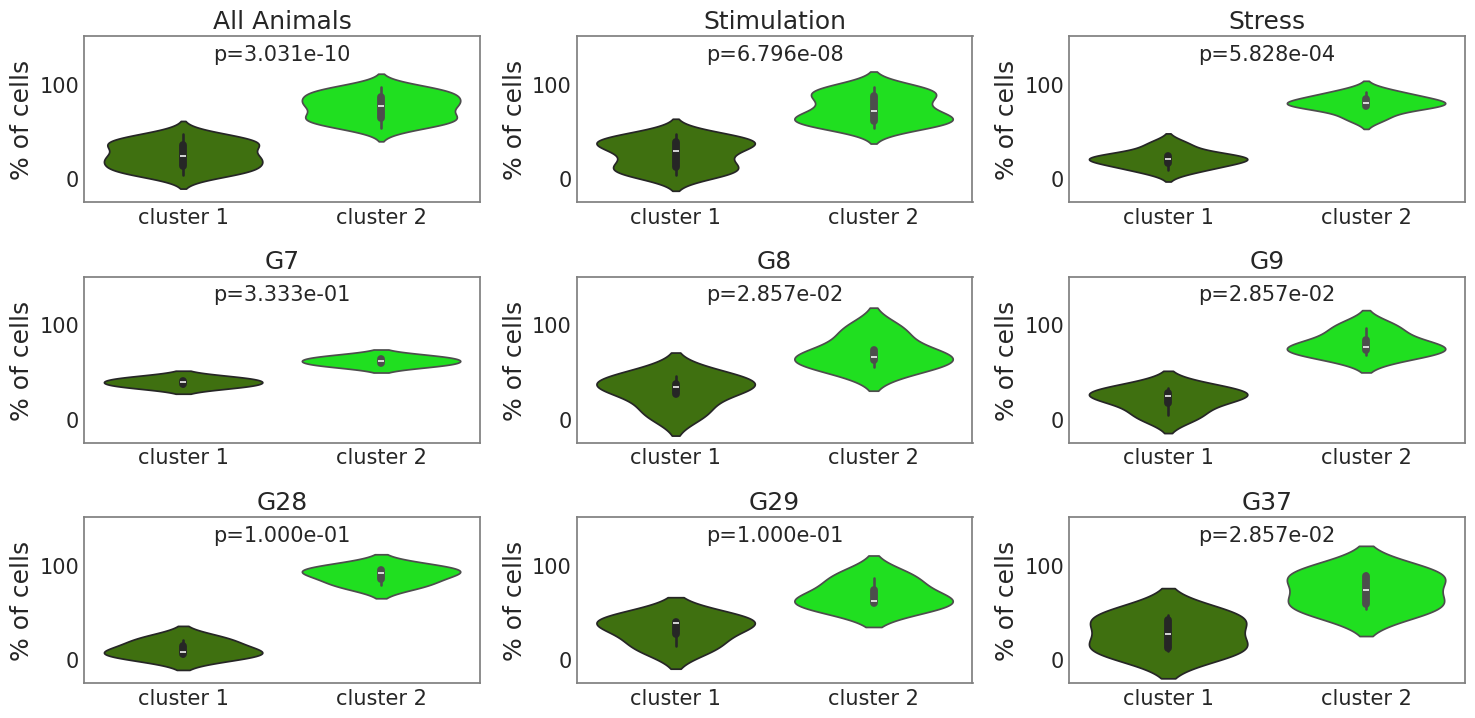

In [ ]:
# Set up the figure with a specified size (15x12 inches)
fig = plt.figure(figsize=(15, 12))

# Loop through the range of categories to generate 9 violin plots (5 rows and 3 columns)
for i in range(9):
    ax = plt.subplot(5, 3, i + 1)  # Create subplot in a 5x3 grid
    ax.tick_params(axis='both', length=0)  # Remove ticks on both axes for clean appearance

    # Extract the cell percentage data for cluster 1 and 2
    perc1 = cell_percentage_hier[categories_percent_hier[4 * i + 3]]
    # Create DataFrame for cluster 1
    df = pd.DataFrame(dict(x=np.repeat([0], len(perc1)), y=perc1))
    # Plot the violin plot for cluster 1 using a specific color
    sns.violinplot(x="x", y="y", data=df, order=np.arange(2), color=eff_green)

    perc2 = cell_percentage_hier[categories_percent_hier[4 * i + 4]]
    # Create DataFrame for cluster 2
    df = pd.DataFrame(dict(x=np.repeat([1], len(perc2)), y=perc2))
    # Plot the violin plot for cluster 2 using a different color
    sns.violinplot(x="x", y="y", data=df, order=np.arange(2), color=inter_green)

    # Set the title of the plot to the category name, removing the last 5 characters (assumed to be a suffix)
    ax.set_title(categories_percent_hier[4 * i + 3][:-5])
    ax.set_ylim(-25, 150)  # Set y-axis limits
    ax.set_xlabel('')  # Remove x-axis label
    ax.set_ylabel('% of cells')  # Set y-axis label
    ax.set_xticks(range(2), labels=['cluster 1', 'cluster 2'])  # Set x-axis labels

    # Perform statistical tests (Mann-Whitney U test and Kolmogorov-Smirnov test)
    _, pval1 = mannwhitneyu(perc1.dropna(), perc2.dropna())  # Mann-Whitney U test
    _, pval2 = kstest(perc1.dropna(), perc2.dropna())  # Kolmogorov-Smirnov test

    # Annotate the p-value for Mann-Whitney U test on the plot
    ax.annotate(f'p={pval1:0.3e}', (1/2, 125), ha='center')

# Adjust the layout of the figure to avoid overlapping labels
fig.tight_layout()

# Save the figure as an PNG file with high resolution
# plt.savefig("./gdrive/My Drive/supplementary_cluster_size.png", dpi=300)

# Display the plot
plt.show()

# Figure S3

In [ ]:
# Define the root folder path where the files are located
root_folder = './gdrive/My Drive/Kevin_Group/Ucn-opsin&GABA-Gcamp/'

# Initialise an empty list to store file paths that match the condition
all_file_paths = []

# Walk through the root folder and all its subdirectories
for dirpath, _, filenames in os.walk(root_folder):
    for filename in filenames:
        # Construct the full file path
        file_path = os.path.join(dirpath, filename)
        # Add the matching file path to the list
        all_file_paths.append(file_path)

# Print the list of file paths that match the condition
# print(all_file_paths)

In [ ]:
all_file_paths = [
 './gdrive/My Drive/Kevin_Group/Ucn-opsin&GABA-Gcamp/G7 222&223 sti NoRMCorre corrected/G7 222sti/G7 20231110 10hz 222sti.csv',
 './gdrive/My Drive/Kevin_Group/Ucn-opsin&GABA-Gcamp/G7 222&223 sti NoRMCorre corrected/G7 223sti/G7 20240201 10hz 223sti.csv',
 './gdrive/My Drive/Kevin_Group/Ucn-opsin&GABA-Gcamp/G8 222&223 sti NoRMCorre corrected/G8 222sti/G8 20231218 10hz 222sti.csv',
 './gdrive/My Drive/Kevin_Group/Ucn-opsin&GABA-Gcamp/G8 222&223 sti NoRMCorre corrected/G8 223sti/G8 20240202 10hz 223sti.csv',
 './gdrive/My Drive/Kevin_Group/Ucn-opsin&GABA-Gcamp/G8 222&223 sti NoRMCorre corrected/G8 223sti/G8 20240220 10hz 223sti.csv',
 './gdrive/My Drive/Kevin_Group/Ucn-opsin&GABA-Gcamp/G8 222&223 sti NoRMCorre corrected/G8 223sti/G8 20240301 10hz 223sti.csv',
 './gdrive/My Drive/Kevin_Group/Ucn-opsin&GABA-Gcamp/G9 222&223 sti NoRMCorre corrected/G9 223sti/G9 20240202 10hz 223sti.csv',
 './gdrive/My Drive/Kevin_Group/Ucn-opsin&GABA-Gcamp/G9 222&223 sti NoRMCorre corrected/G9 223sti/G9 20240228 10hz 223sti.csv',
 './gdrive/My Drive/Kevin_Group/Ucn-opsin&GABA-Gcamp/G9 222&223 sti NoRMCorre corrected/G9 223sti/G9 20240307 10hz 223sti.csv',
 './gdrive/My Drive/Kevin_Group/Ucn-opsin&GABA-Gcamp/G9 222&223 sti NoRMCorre corrected/G9 222sti/G9 20231218 10hz 222sti.csv',
 './gdrive/My Drive/Kevin_Group/Ucn-opsin&GABA-Gcamp/G28 223sti data/G28 20240701 10hz 223sti.csv',
 './gdrive/My Drive/Kevin_Group/Ucn-opsin&GABA-Gcamp/G28 223sti data/G28 20240704 10hz 223sti.csv',
 './gdrive/My Drive/Kevin_Group/Ucn-opsin&GABA-Gcamp/G28 223sti data/G28 20240709 10hz 223sti.csv',
 './gdrive/My Drive/Kevin_Group/Ucn-opsin&GABA-Gcamp/G29 223sti data/G29 20240703 10hz 223sti.csv',
 './gdrive/My Drive/Kevin_Group/Ucn-opsin&GABA-Gcamp/G29 223sti data/G29 20240705 10hz 223sti.csv',
 './gdrive/My Drive/Kevin_Group/Ucn-opsin&GABA-Gcamp/G29 223sti data/G29 20240711 10hz 223sti.csv',
 './gdrive/My Drive/Kevin_Group/Ucn-opsin&GABA-Gcamp/G37 223sti data/G37 10hz 223sti 20240720 A.csv',
 './gdrive/My Drive/Kevin_Group/Ucn-opsin&GABA-Gcamp/G37 223sti data/G37 10hz 223sti 20240720 B.csv',
 './gdrive/My Drive/Kevin_Group/Ucn-opsin&GABA-Gcamp/G37 223sti data/G37 10hz 223sti 20240721 A.csv',
 './gdrive/My Drive/Kevin_Group/Ucn-opsin&GABA-Gcamp/G37 223sti data/G37 10hz 223sti 20240721 B.csv',
 './gdrive/My Drive/Kevin_Group/Ucn-opsin&GABA-Gcamp/G7 8 9 333restraint NoRMCorre corrected/G7 20231218 334restraint.csv',
 './gdrive/My Drive/Kevin_Group/Ucn-opsin&GABA-Gcamp/G7 8 9 333restraint NoRMCorre corrected/G8 20231218 343restraint.csv',
 './gdrive/My Drive/Kevin_Group/Ucn-opsin&GABA-Gcamp/G7 8 9 333restraint NoRMCorre corrected/G9 20231218 334restraint.csv',
 './gdrive/My Drive/Kevin_Group/Ucn-opsin&GABA-Gcamp/G28 29 37 short restraint data/G28 333restraint 20240630.csv',
 './gdrive/My Drive/Kevin_Group/Ucn-opsin&GABA-Gcamp/G28 29 37 short restraint data/G29 333restraint 20240701.csv',
 './gdrive/My Drive/Kevin_Group/Ucn-opsin&GABA-Gcamp/G28 29 37 short restraint data/G37 333restraint 20240719.csv',
 './gdrive/My Drive/Kevin_Group/Ucn-opsin&GABA-Gcamp/G28 29 37 short restraint data/G37 333restraint 20240725.csv']

In [ ]:
boot_file_paths = [
    all_file_paths[0], all_file_paths[2], all_file_paths[6],
    all_file_paths[10], all_file_paths[13], all_file_paths[16]
]

<ipython-input-149-72de48fed798>:78: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([2, 3, 4, '', 2, 3, 4])
<ipython-input-149-72de48fed798>:78: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([2, 3, 4, '', 2, 3, 4])
<ipython-input-149-72de48fed798>:78: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([2, 3, 4, '', 2, 3, 4])
<ipython-input-149-72de48fed798>:78: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([2, 3, 4, '', 2, 3, 4])
<ipython-input-149-72de48fed798>:78: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLoca

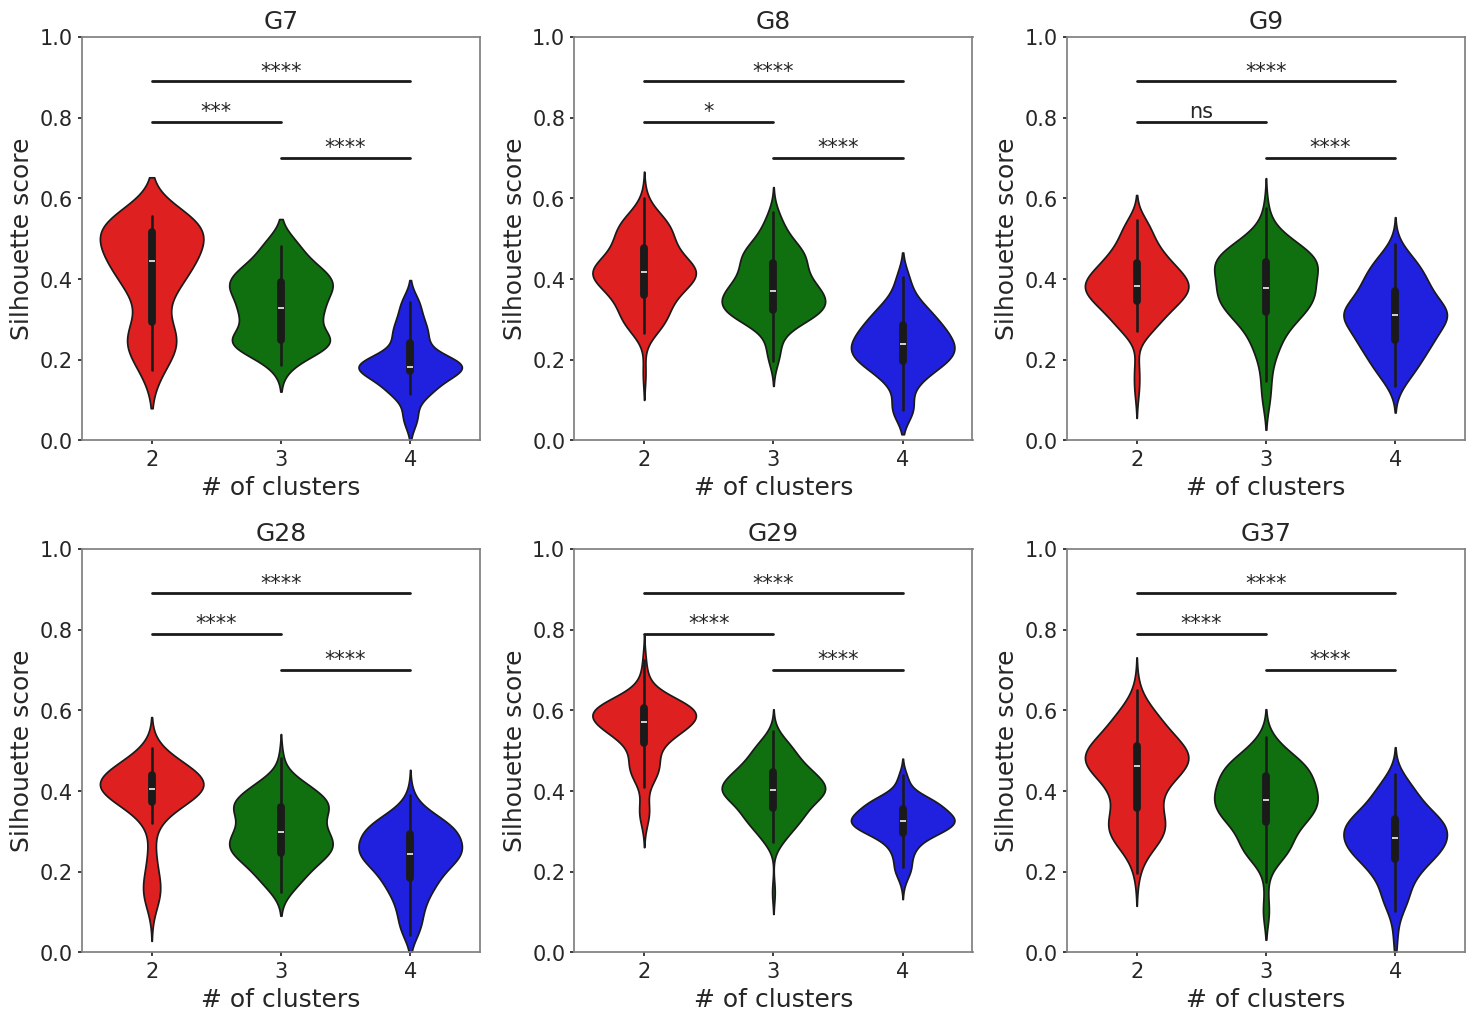

In [ ]:
# Create a 3x3 grid for plotting
plt.figure(figsize=(15, 15))

# Define subplot axes
ax1 = plt.subplot(3, 3, 1)
ax2 = plt.subplot(3, 3, 2)
ax3 = plt.subplot(3, 3, 3)
ax4 = plt.subplot(3, 3, 4)
ax5 = plt.subplot(3, 3, 5)
ax6 = plt.subplot(3, 3, 6)

# Iterate over bootstrapping files for analysis
for ind, stim_csv_fname in enumerate(boot_file_paths):
    # Load data and remove metadata from the data set
    data_stim, cells_traces_tot_old = load_data(stim_csv_fname)

    # Filter UCN3 co-expressing GABA neurons from the data set
    data_stim_tot, n_cells = process_data(data_stim, cells_traces_tot_old)

    # Rescale stimulation traces to min and max of the entire length of each trace (row-wise scaling)
    normalised_data_stim_tot = minmax_scale(data_stim_tot, axis=1)

    # Slice the data to extract the stimulation period
    normalised_data_stim_2 = normalised_data_stim_tot[:, stim_onset:stim_offset]

    # Compute pairwise covariance distance matrix
    dist_corr_2 = pdist(scale(normalised_data_stim_2, axis=1),
                        lambda x, y: 1 - signed_lagged_corr(x, y)[0])

    # Initialise arrays to store scores
    sil_score_2 = np.zeros((max_no_clusters - 1, n_resampling))

    # Evaluate clustering metrics for each number of clusters
    for i, Ks_2 in enumerate(range(2, max_no_clusters + 1)):
        for j in range(n_resampling):
            # Resample data for bootstrapping
            sampled_ids = np.random.choice(range(n_cells), int(0.75 * n_cells), replace=False)
            sampled_data = squareform(dist_corr_2)[sampled_ids, :][:, sampled_ids]

            # Perform hierarchical clustering
            ac = AgglomerativeClustering(n_clusters=Ks_2, metric='precomputed',
                                         linkage='average', compute_distances=True).fit(sampled_data)

            # Calculate and store silhouette and CH scores
            sil_score_2[i, j] = silhouette_score(sampled_data, ac.labels_, metric='precomputed')

    # Select appropriate subplot based on the file name
    file_name = os.path.split(stim_csv_fname)[-1]
    ax = {
        'G7': ax1, 'G8': ax2, 'G9': ax3,
        'G28': ax4, 'G29': ax5, 'G37': ax6
    }.get(file_name.split(' ')[0], None)

    if ax:
        # Plot violin plots for silhouette scores
        for k, colour in enumerate(['red', 'green', 'blue']):
            df = pd.DataFrame({'x': np.repeat([k], len(sil_score_2[k, :])), 'y': sil_score_2[k, :]})
            sns.violinplot(x="x", y="y", data=df, color=colour, linecolor='k', ax=ax)

        # Perform Dunn's test for posthoc analysis
        p_vals = posthoc_dunn(sil_score_2, p_adjust='fdr_bh')

        # Add p-value annotations
        ax.plot([0, 1], [0.79, 0.79], 'k-')
        ax.plot([1, 2], [0.7, 0.7], 'k-')
        ax.plot([0, 2], [0.89, 0.89], 'k-')
        ax.annotate(pval_to_star(p_vals[1][2]), (1 / 2, 0.8), ha='center')
        ax.annotate(pval_to_star(p_vals[2][3]), (3 / 2, 0.71), ha='center')
        ax.annotate(pval_to_star(p_vals[1][3]), (1, 0.9), ha='center')

# Configure titles and labels for individual subplots
for idx, title in enumerate(['G7', 'G8', 'G9', 'G28', 'G29', 'G37'], start=1):
    ax = plt.subplot(3, 3, idx)
    ax.set_title(title)
    ax.set_ylim(0, 1)
    ax.set_ylabel('Silhouette score')
    ax.set_xlabel('# of clusters')
    ax.set_xticklabels([2, 3, 4, '', 2, 3, 4])

# Adjust layout and save the figure
plt.tight_layout()
# plt.savefig('./gdrive/My Drive/FigS4.png', dpi=300)
plt.show()

In [ ]:
# Initialise lists to store Kruskal-Wallis test p-values for stimulation and stress conditions
kruskal_pvals_stim = []
kruskal_pvals_stress = []

# Iterate over all file paths
for ind, stim_csv_fname in enumerate(all_file_paths):
    # Initialise arrays to store silhouette and Calinski-Harabasz scores for bootstrapping
    sil_score_2 = np.zeros((max_no_clusters - 1, n_resampling))  # Silhouette scores

    # Loop over cluster numbers to evaluate
    for i, Ks_2 in enumerate(range(2, max_no_clusters + 1)):
        # Perform resampling and clustering
        for j in range(n_resampling):
            # Randomly sample 75% of cells without replacement
            sampled_ids = np.random.choice(range(n_cells), int(0.75 * n_cells), replace=False)

            # Subset the pairwise distance matrix for sampled cells
            sampled_data = squareform(dist_corr_2)[sampled_ids, :][:, sampled_ids]

            # Perform hierarchical clustering with the given number of clusters
            ac = AgglomerativeClustering(
                n_clusters=Ks_2,
                metric='precomputed',  # Use precomputed distance matrix
                linkage='average',     # Average linkage clustering
                compute_distances=True
            ).fit(sampled_data)

            # Calculate and store clustering evaluation metrics
            sil_score_2[i, j] = silhouette_score(sampled_data, ac.labels_, metric='precomputed')

    # Perform Kruskal-Wallis test on silhouette scores across different cluster numbers
    _, p_val = kruskal(*sil_score_2)

    # Categorise p-values based on file name (e.g., 'restraint' indicates stress condition)
    if 'restraint' in stim_csv_fname:
        kruskal_pvals_stress.append(p_val)
    else:
        kruskal_pvals_stim.append(p_val)

# Group p-values into specific pools for stimulation and stress conditions
# Each group corresponds to specific ranges of file indices
kruskal_pvals_pool_stim = [
    kruskal_pvals_stim[0:2],
    kruskal_pvals_stim[2:6],
    kruskal_pvals_stim[6:10],
    kruskal_pvals_stim[10:13],
    kruskal_pvals_stim[13:16],
    kruskal_pvals_stim[16:20]
]

kruskal_pvals_pool_stress = [
    kruskal_pvals_stress[0:1],
    kruskal_pvals_stress[1:2],
    kruskal_pvals_stress[2:3],
    kruskal_pvals_stress[3:4],
    kruskal_pvals_stress[4:5],
    kruskal_pvals_stress[5:7]
]

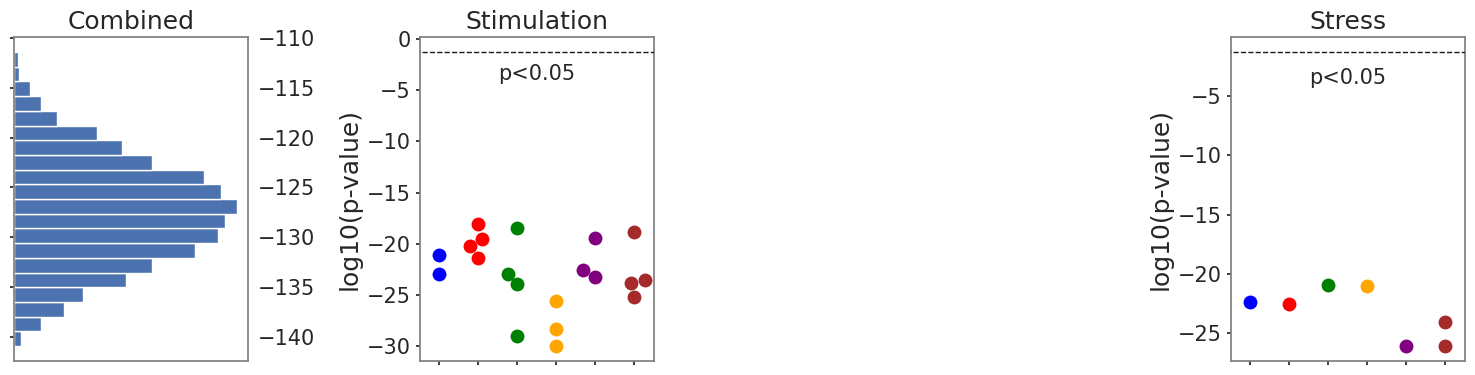

In [ ]:
# Create a figure with specific size
fig = plt.figure(figsize=(15, 4))
gs = gridspec.GridSpec(1, 4, figure=fig)  # Create a 1x4 grid layout for subplots

# First subplot: Combined p-values histogram
ax = fig.add_subplot(gs[0])
df = fisher_combine_pvalues(kruskal_pvals_pool_stim)  # Combine p-values for stimulation
df = np.log10(df)  # Log-transform the p-values for better visualisation
ax.hist(df, bins=20, orientation='horizontal')  # Horizontal histogram of log10-transformed p-values

ax.set_title('Combined')  # Title for the combined p-values subplot
ax.set_xticks([])  # Remove x-axis ticks
ax.tick_params(axis='y', labelright=True, labelleft=False)  # Y-axis labels on the right side only

# Define colour list for consistency across subplots
colour_list = ['blue', 'red', 'green', 'orange', 'purple', 'brown']


# Second subplot: Stimulation p-values
ax = fig.add_subplot(gs[1])
for i in range(6):  # Iterate over six stimulation pools
    pvals = [np.log10(_) for _ in kruskal_pvals_pool_stim[i]]  # Log-transform the p-values
    df = pd.DataFrame(dict(x=np.repeat([i], len(pvals)), y=pvals))  # Prepare data for swarm plot
    sns.swarmplot(x='x', y='y', data=df, color=colour_list[i], size=10, clip_on=False)  # Swarm plot
ax.plot([-1, 6], [np.log10(0.05), np.log10(0.05)], 'k--', lw=1, zorder=20)  # Significance threshold line

ax.set_title('Stimulation')  # Title for stimulation subplot
ax.set_xlim(-0.5, 5.5)  # X-axis limits
ax.set_xlabel('')  # Remove x-axis label
ax.set_ylabel('log10(p-value)')  # Y-axis label
ax.yaxis.set_label_position("left")  # Position the y-axis label on the left
ax.set_xticks([0, 1, 2, 3, 4, 5], labels=[], rotation=90)  # X-axis ticks without labels
ax.tick_params(axis='y', labelright=False, labelleft=True)  # Y-axis labels only on the left
ax.text(2.5, -4, 'p<0.05', ha='center')  # Add a label to indicate significance


# Third subplot: Stress p-values
ax = fig.add_subplot(gs[3])
for i in range(6):  # Iterate over six stress pools
    pvals = [np.log10(_) for _ in kruskal_pvals_pool_stress[i]]  # Log-transform the p-values
    df = pd.DataFrame(dict(x=np.repeat([i], len(pvals)), y=pvals))  # Prepare data for swarm plot
    sns.swarmplot(x='x', y='y', data=df, color=colour_list[i], size=10)  # Swarm plot
ax.plot([-1, 6], [np.log10(0.05), np.log10(0.05)], 'k--', lw=1, zorder=20)  # Significance threshold line

ax.set_title('Stress')  # Title for stress subplot
ax.set_xlim(-0.5, 5.5)  # X-axis limits
ax.set_xlabel('')  # Remove x-axis label
ax.set_ylabel('log10(p-value)')  # Y-axis label
ax.yaxis.set_label_position("left")  # Position the y-axis label on the left
ax.set_xticks([0, 1, 2, 3, 4, 5], labels=[], rotation=90)  # X-axis ticks without labels
ax.tick_params(axis='y', labelright=False, labelleft=True)  # Y-axis labels only on the left
ax.text(2.5, -4, 'p<0.05', ha='center')  # Add a label to indicate significance

# Adjust subplot spacing
plt.tight_layout()

# Uncomment the following line to save the figure
# plt.savefig('./gdrive/My Drive/FigS3_pvalues.png', dpi=300)

# Display the plot
plt.show()

# Figure S4

<ipython-input-152-c659cb66a4c3>:78: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([2, 3, 4, '', 2, 3, 4])
<ipython-input-152-c659cb66a4c3>:78: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([2, 3, 4, '', 2, 3, 4])
<ipython-input-152-c659cb66a4c3>:78: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([2, 3, 4, '', 2, 3, 4])
<ipython-input-152-c659cb66a4c3>:78: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([2, 3, 4, '', 2, 3, 4])
<ipython-input-152-c659cb66a4c3>:78: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLoca

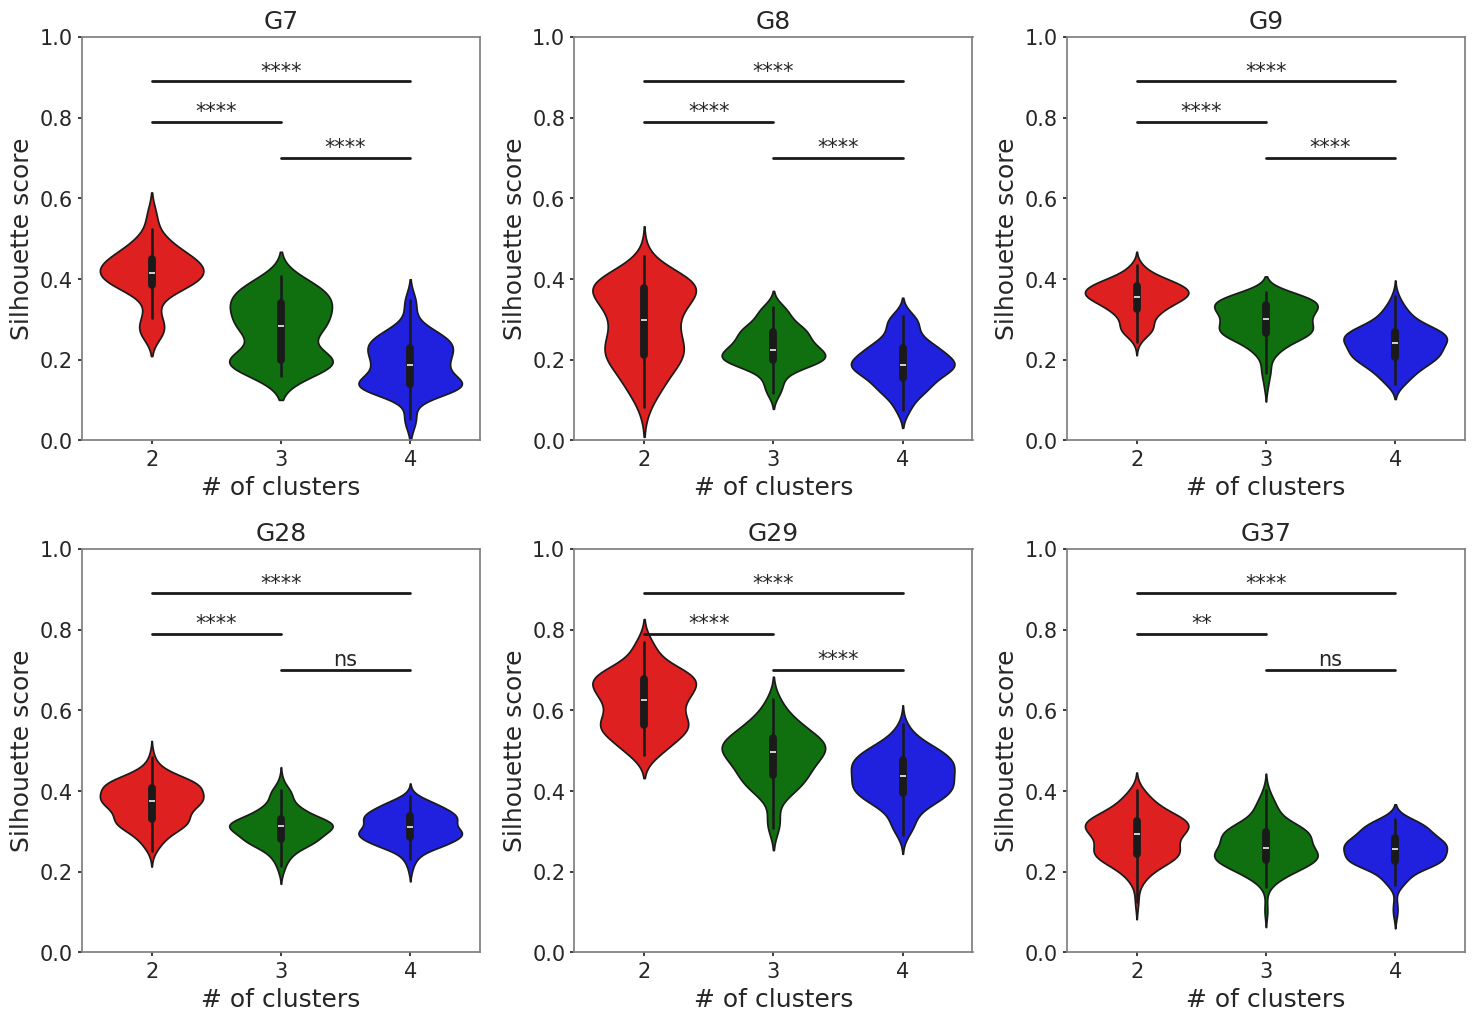

In [ ]:
# Create a 3x3 grid for plotting
plt.figure(figsize=(15, 15))

# Define subplot axes
ax1 = plt.subplot(3, 3, 1)
ax2 = plt.subplot(3, 3, 2)
ax3 = plt.subplot(3, 3, 3)
ax4 = plt.subplot(3, 3, 4)
ax5 = plt.subplot(3, 3, 5)
ax6 = plt.subplot(3, 3, 6)

# Iterate over bootstrapping files for analysis
for ind, stim_csv_fname in enumerate(boot_file_paths):
    # Load data and remove metadata from the data set
    data_stim, cells_traces_tot_old = load_data(stim_csv_fname)

    # Filter UCN3 co-expressing GABA neurons from the data set
    data_stim_tot, n_cells = process_data(data_stim, cells_traces_tot_old)

    # Rescale stimulation traces to min and max of the entire length of each trace (row-wise scaling)
    normalised_data_stim_tot = minmax_scale(data_stim_tot, axis=1)

    # Slice the data to extract the stimulation period
    normalised_data_stim_2 = normalised_data_stim_tot[:, stim_onset:stim_offset]

    # Compute pairwise covariance distance matrix
    dist_cov_2 = pdist(scale(normalised_data_stim_2, axis=1),
                       lambda x, y: 1 - np.cov(x, y, bias=True)[0, 1])

    # Initialise arrays to store scores
    sil_score_2 = np.zeros((max_no_clusters - 1, n_resampling))

    # Evaluate clustering metrics for each number of clusters
    for i, Ks_2 in enumerate(range(2, max_no_clusters + 1)):
        for j in range(n_resampling):
            # Resample data for bootstrapping
            sampled_ids = np.random.choice(range(n_cells), int(0.75 * n_cells), replace=False)
            sampled_data = squareform(dist_cov_2)[sampled_ids, :][:, sampled_ids]

            # Perform hierarchical clustering
            ac = AgglomerativeClustering(n_clusters=Ks_2, metric='precomputed',
                                         linkage='average', compute_distances=True).fit(sampled_data)

            # Calculate and store silhouette and CH scores
            sil_score_2[i, j] = silhouette_score(sampled_data, ac.labels_, metric='precomputed')

    # Select appropriate subplot based on the file name
    file_name = os.path.split(stim_csv_fname)[-1]
    ax = {
        'G7': ax1, 'G8': ax2, 'G9': ax3,
        'G28': ax4, 'G29': ax5, 'G37': ax6
    }.get(file_name.split(' ')[0], None)

    if ax:
        # Plot violin plots for silhouette scores
        for k, colour in enumerate(['red', 'green', 'blue']):
            df = pd.DataFrame({'x': np.repeat([k], len(sil_score_2[k, :])), 'y': sil_score_2[k, :]})
            sns.violinplot(x="x", y="y", data=df, color=colour, linecolor='k', ax=ax)

        # Perform Dunn's test for posthoc analysis
        p_vals = posthoc_dunn(sil_score_2, p_adjust='fdr_bh')

        # Add p-value annotations
        ax.plot([0, 1], [0.79, 0.79], 'k-')
        ax.plot([1, 2], [0.7, 0.7], 'k-')
        ax.plot([0, 2], [0.89, 0.89], 'k-')
        ax.annotate(pval_to_star(p_vals[1][2]), (1 / 2, 0.8), ha='center')
        ax.annotate(pval_to_star(p_vals[2][3]), (3 / 2, 0.71), ha='center')
        ax.annotate(pval_to_star(p_vals[1][3]), (1, 0.9), ha='center')

# Configure titles and labels for individual subplots
for idx, title in enumerate(['G7', 'G8', 'G9', 'G28', 'G29', 'G37'], start=1):
    ax = plt.subplot(3, 3, idx)
    ax.set_title(title)
    ax.set_ylim(0, 1)
    ax.set_ylabel('Silhouette score')
    ax.set_xlabel('# of clusters')
    ax.set_xticklabels([2, 3, 4, '', 2, 3, 4])

# Adjust layout and save the figure
plt.tight_layout()
# plt.savefig('./gdrive/My Drive/FigS4.png', dpi=300)
plt.show()

In [ ]:
# Initialise lists to store Kruskal-Wallis test p-values for stimulation and stress conditions
kruskal_pvals_stim = []
kruskal_pvals_stress = []

# Iterate over all file paths
for ind, stim_csv_fname in enumerate(all_file_paths):
    # Initialise arrays to store silhouette and Calinski-Harabasz scores for bootstrapping
    sil_score_2 = np.zeros((max_no_clusters - 1, n_resampling))  # Silhouette scores

    # Loop over cluster numbers to evaluate
    for i, Ks_2 in enumerate(range(2, max_no_clusters + 1)):
        # Perform resampling and clustering
        for j in range(n_resampling):
            # Randomly sample 75% of cells without replacement
            sampled_ids = np.random.choice(range(n_cells), int(0.75 * n_cells), replace=False)

            # Subset the pairwise distance matrix for sampled cells
            sampled_data = squareform(dist_cov_2)[sampled_ids, :][:, sampled_ids]

            # Perform hierarchical clustering with the given number of clusters
            ac = AgglomerativeClustering(
                n_clusters=Ks_2,
                metric='precomputed',  # Use precomputed distance matrix
                linkage='average',     # Average linkage clustering
                compute_distances=True
            ).fit(sampled_data)

            # Calculate and store clustering evaluation metrics
            sil_score_2[i, j] = silhouette_score(sampled_data, ac.labels_, metric='precomputed')

    # Perform Kruskal-Wallis test on silhouette scores across different cluster numbers
    _, p_val = kruskal(*sil_score_2)

    # Categorise p-values based on file name (e.g., 'restraint' indicates stress condition)
    if 'restraint' in stim_csv_fname:
        kruskal_pvals_stress.append(p_val)
    else:
        kruskal_pvals_stim.append(p_val)

# Group p-values into specific pools for stimulation and stress conditions
# Each group corresponds to specific ranges of file indices
kruskal_pvals_pool_stim = [
    kruskal_pvals_stim[0:2],
    kruskal_pvals_stim[2:6],
    kruskal_pvals_stim[6:10],
    kruskal_pvals_stim[10:13],
    kruskal_pvals_stim[13:16],
    kruskal_pvals_stim[16:20]
]

kruskal_pvals_pool_stress = [
    kruskal_pvals_stress[0:1],
    kruskal_pvals_stress[1:2],
    kruskal_pvals_stress[2:3],
    kruskal_pvals_stress[3:4],
    kruskal_pvals_stress[4:5],
    kruskal_pvals_stress[5:7]
]

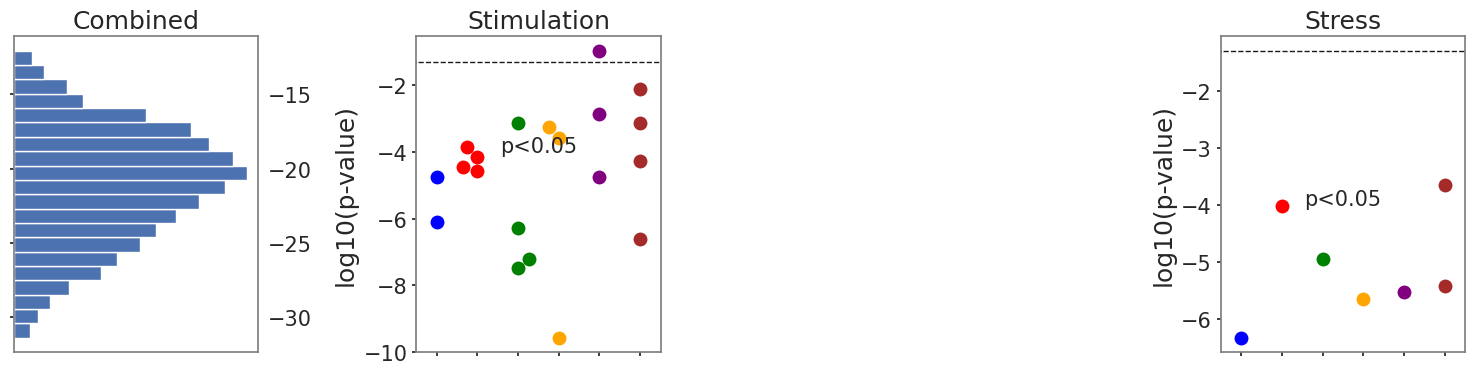

In [ ]:
# Create a figure with specific size
fig = plt.figure(figsize=(15, 4))
gs = gridspec.GridSpec(1, 4, figure=fig)  # Create a 1x4 grid layout for subplots

# First subplot: Combined p-values histogram
ax = fig.add_subplot(gs[0])
df = fisher_combine_pvalues(kruskal_pvals_pool_stim)  # Combine p-values for stimulation
df = np.log10(df)  # Log-transform the p-values for better visualisation
ax.hist(df, bins=20, orientation='horizontal')  # Horizontal histogram of log10-transformed p-values

ax.set_title('Combined')  # Title for the combined p-values subplot
ax.set_xticks([])  # Remove x-axis ticks
ax.tick_params(axis='y', labelright=True, labelleft=False)  # Y-axis labels on the right side only

# Define colour list for consistency across subplots
colour_list = ['blue', 'red', 'green', 'orange', 'purple', 'brown']


# Second subplot: Stimulation p-values
ax = fig.add_subplot(gs[1])
for i in range(6):  # Iterate over six stimulation pools
    pvals = [np.log10(_) for _ in kruskal_pvals_pool_stim[i]]  # Log-transform the p-values
    df = pd.DataFrame(dict(x=np.repeat([i], len(pvals)), y=pvals))  # Prepare data for swarm plot
    sns.swarmplot(x='x', y='y', data=df, color=colour_list[i], size=10, clip_on=False)  # Swarm plot
ax.plot([-1, 6], [np.log10(0.05), np.log10(0.05)], 'k--', lw=1, zorder=20)  # Significance threshold line

ax.set_title('Stimulation')  # Title for stimulation subplot
ax.set_xlim(-0.5, 5.5)  # X-axis limits
ax.set_xlabel('')  # Remove x-axis label
ax.set_ylabel('log10(p-value)')  # Y-axis label
ax.yaxis.set_label_position("left")  # Position the y-axis label on the left
ax.set_xticks([0, 1, 2, 3, 4, 5], labels=[], rotation=90)  # X-axis ticks without labels
ax.tick_params(axis='y', labelright=False, labelleft=True)  # Y-axis labels only on the left
ax.text(2.5, -4, 'p<0.05', ha='center')  # Add a label to indicate significance


# Third subplot: Stress p-values
ax = fig.add_subplot(gs[3])
for i in range(6):  # Iterate over six stress pools
    pvals = [np.log10(_) for _ in kruskal_pvals_pool_stress[i]]  # Log-transform the p-values
    df = pd.DataFrame(dict(x=np.repeat([i], len(pvals)), y=pvals))  # Prepare data for swarm plot
    sns.swarmplot(x='x', y='y', data=df, color=colour_list[i], size=10)  # Swarm plot
ax.plot([-1, 6], [np.log10(0.05), np.log10(0.05)], 'k--', lw=1, zorder=20)  # Significance threshold line

ax.set_title('Stress')  # Title for stress subplot
ax.set_xlim(-0.5, 5.5)  # X-axis limits
ax.set_xlabel('')  # Remove x-axis label
ax.set_ylabel('log10(p-value)')  # Y-axis label
ax.yaxis.set_label_position("left")  # Position the y-axis label on the left
ax.set_xticks([0, 1, 2, 3, 4, 5], labels=[], rotation=90)  # X-axis ticks without labels
ax.tick_params(axis='y', labelright=False, labelleft=True)  # Y-axis labels only on the left
ax.text(2.5, -4, 'p<0.05', ha='center')  # Add a label to indicate significance

# Adjust subplot spacing
plt.tight_layout()

# Uncomment the following line to save the figure
# plt.savefig('./gdrive/My Drive/FigS4_pvalues.png', dpi=300)

# Display the plot
plt.show()

# Figure S5

<ipython-input-155-227b012153ef>:78: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([2, 3, 4, '', 2, 3, 4])
<ipython-input-155-227b012153ef>:78: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([2, 3, 4, '', 2, 3, 4])
<ipython-input-155-227b012153ef>:78: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([2, 3, 4, '', 2, 3, 4])
<ipython-input-155-227b012153ef>:78: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([2, 3, 4, '', 2, 3, 4])
<ipython-input-155-227b012153ef>:78: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLoca

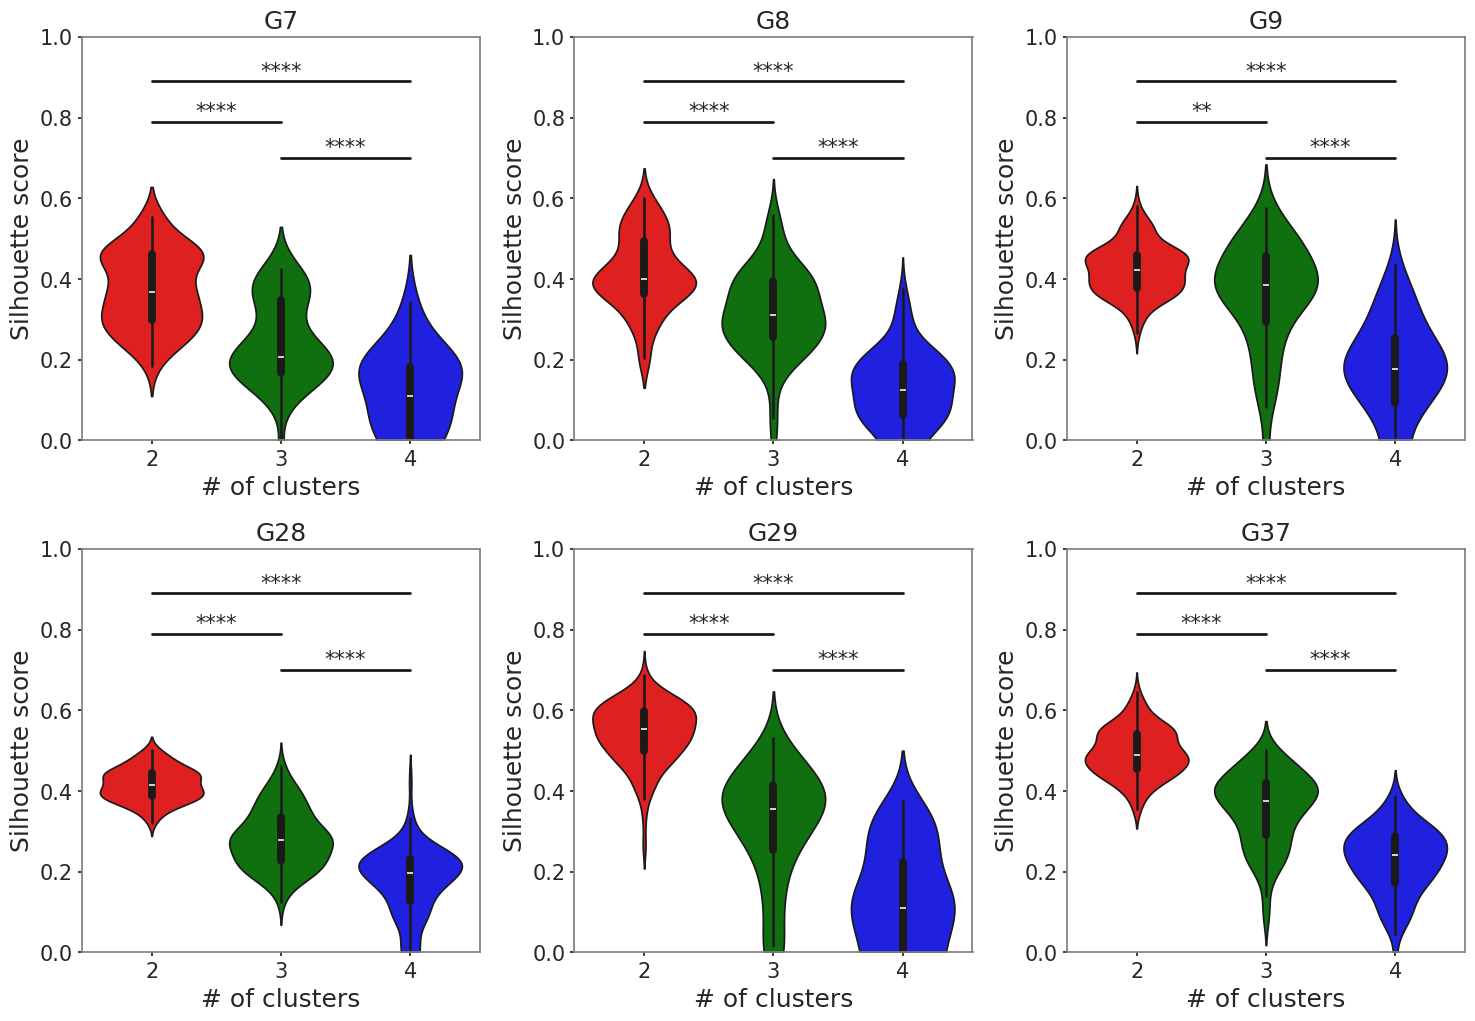

In [ ]:
# Create a 3x3 grid for plotting
plt.figure(figsize=(15, 15))

# Define subplot axes
ax1 = plt.subplot(3, 3, 1)
ax2 = plt.subplot(3, 3, 2)
ax3 = plt.subplot(3, 3, 3)
ax4 = plt.subplot(3, 3, 4)
ax5 = plt.subplot(3, 3, 5)
ax6 = plt.subplot(3, 3, 6)

# Iterate over bootstrapping files for analysis
for ind, stim_csv_fname in enumerate(boot_file_paths):
    # Load data and remove metadata from the data set
    data_stim, cells_traces_tot_old = load_data(stim_csv_fname)

    # Filter UCN3 co-expressing GABA neurons from the data set
    data_stim_tot, n_cells = process_data(data_stim, cells_traces_tot_old)

    # Rescale stimulation traces to min and max of the entire length of each trace (row-wise scaling)
    normalised_data_stim_tot = minmax_scale(data_stim_tot, axis=1)

    # Slice the data to extract the stimulation period
    normalised_data_stim_2 = normalised_data_stim_tot[:, stim_onset:stim_offset]

    # Compute pairwise SLxCorr distance matrix
    dist_corr_2 = pdist(scale(normalised_data_stim_2, axis=1),
                        lambda x, y: 1 - signed_lagged_corr(x, y)[0])

    # Initialise arrays to store scores
    sil_score_2 = np.zeros((max_no_clusters - 1, n_resampling))

    # Evaluate clustering metrics for each number of clusters
    for i, Ks_2 in enumerate(range(2, max_no_clusters + 1)):
        for j in range(n_resampling):
            # Resample data for bootstrapping
            sampled_ids = np.random.choice(range(n_cells), int(0.75 * n_cells), replace=False)
            sampled_data = squareform(dist_corr_2)[sampled_ids, :][:, sampled_ids]

            # apply K-means clustering to sort activity traces
            km = KMeans(n_clusters=Ks_2, n_init=10,
                        max_iter=100).fit(sampled_data)

            # Calculate and store silhouette and CH scores
            sil_score_2[i, j] = silhouette_score(sampled_data, km.labels_, metric='precomputed')

    # Select appropriate subplot based on the file name
    file_name = os.path.split(stim_csv_fname)[-1]
    ax = {
        'G7': ax1, 'G8': ax2, 'G9': ax3,
        'G28': ax4, 'G29': ax5, 'G37': ax6
    }.get(file_name.split(' ')[0], None)

    if ax:
        # Plot violin plots for silhouette scores
        for k, colour in enumerate(['red', 'green', 'blue']):
            df = pd.DataFrame({'x': np.repeat([k], len(sil_score_2[k, :])), 'y': sil_score_2[k, :]})
            sns.violinplot(x="x", y="y", data=df, color=colour, linecolor='k', ax=ax)

        # Perform Dunn's test for posthoc analysis
        p_vals = posthoc_dunn(sil_score_2, p_adjust='fdr_bh')

        # Add p-value annotations
        ax.plot([0, 1], [0.79, 0.79], 'k-')
        ax.plot([1, 2], [0.7, 0.7], 'k-')
        ax.plot([0, 2], [0.89, 0.89], 'k-')
        ax.annotate(pval_to_star(p_vals[1][2]), (1 / 2, 0.8), ha='center')
        ax.annotate(pval_to_star(p_vals[2][3]), (3 / 2, 0.71), ha='center')
        ax.annotate(pval_to_star(p_vals[1][3]), (1, 0.9), ha='center')

# Configure titles and labels for individual subplots
for idx, title in enumerate(['G7', 'G8', 'G9', 'G28', 'G29', 'G37'], start=1):
    ax = plt.subplot(3, 3, idx)
    ax.set_title(title)
    ax.set_ylim(0, 1)
    ax.set_ylabel('Silhouette score')
    ax.set_xlabel('# of clusters')
    ax.set_xticklabels([2, 3, 4, '', 2, 3, 4])

# Adjust layout and save the figure
plt.tight_layout()
# plt.savefig('./gdrive/My Drive/FigS5.png', dpi=300)
plt.show()

In [ ]:
# Initialise lists to store Kruskal-Wallis test p-values for stimulation and stress conditions
kruskal_pvals_stim = []
kruskal_pvals_stress = []

# Iterate over all file paths
for ind, stim_csv_fname in enumerate(all_file_paths):
    # Initialise arrays to store silhouette and Calinski-Harabasz scores for bootstrapping
    sil_score_2 = np.zeros((max_no_clusters - 1, n_resampling))  # Silhouette scores

    # Loop over cluster numbers to evaluate
    for i, Ks_2 in enumerate(range(2, max_no_clusters + 1)):
        # Perform resampling and clustering
        for j in range(n_resampling):
            # Randomly sample 75% of cells without replacement
            sampled_ids = np.random.choice(range(n_cells), int(0.75 * n_cells), replace=False)

            # Subset the pairwise distance matrix for sampled cells
            sampled_data = squareform(dist_corr_2)[sampled_ids, :][:, sampled_ids]

            # Perform hierarchical clustering with the given number of clusters
            ac = AgglomerativeClustering(
                n_clusters=Ks_2,
                metric='precomputed',  # Use precomputed distance matrix
                linkage='average',     # Average linkage clustering
                compute_distances=True
            ).fit(sampled_data)

            # Calculate and store clustering evaluation metrics
            sil_score_2[i, j] = silhouette_score(sampled_data, ac.labels_, metric='precomputed')

    # Perform Kruskal-Wallis test on silhouette scores across different cluster numbers
    _, p_val = kruskal(*sil_score_2)

    # Categorise p-values based on file name (e.g., 'restraint' indicates stress condition)
    if 'restraint' in stim_csv_fname:
        kruskal_pvals_stress.append(p_val)
    else:
        kruskal_pvals_stim.append(p_val)

# Group p-values into specific pools for stimulation and stress conditions
# Each group corresponds to specific ranges of file indices
kruskal_pvals_pool_stim = [
    kruskal_pvals_stim[0:2],
    kruskal_pvals_stim[2:6],
    kruskal_pvals_stim[6:10],
    kruskal_pvals_stim[10:13],
    kruskal_pvals_stim[13:16],
    kruskal_pvals_stim[16:20]
]

kruskal_pvals_pool_stress = [
    kruskal_pvals_stress[0:1],
    kruskal_pvals_stress[1:2],
    kruskal_pvals_stress[2:3],
    kruskal_pvals_stress[3:4],
    kruskal_pvals_stress[4:5],
    kruskal_pvals_stress[5:7]
]

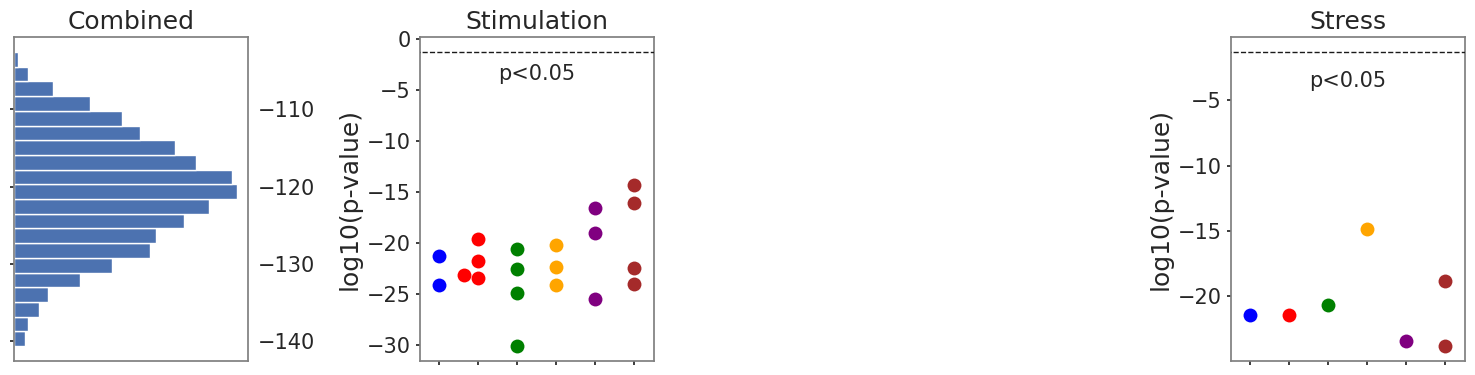

In [ ]:
# Create a figure with specific size
fig = plt.figure(figsize=(15, 4))
gs = gridspec.GridSpec(1, 4, figure=fig)  # Create a 1x4 grid layout for subplots

# First subplot: Combined p-values histogram
ax = fig.add_subplot(gs[0])
df = fisher_combine_pvalues(kruskal_pvals_pool_stim)  # Combine p-values for stimulation
df = np.log10(df)  # Log-transform the p-values for better visualisation
ax.hist(df, bins=20, orientation='horizontal')  # Horizontal histogram of log10-transformed p-values

ax.set_title('Combined')  # Title for the combined p-values subplot
ax.set_xticks([])  # Remove x-axis ticks
ax.tick_params(axis='y', labelright=True, labelleft=False)  # Y-axis labels on the right side only

# Define colour list for consistency across subplots
colour_list = ['blue', 'red', 'green', 'orange', 'purple', 'brown']


# Second subplot: Stimulation p-values
ax = fig.add_subplot(gs[1])
for i in range(6):  # Iterate over six stimulation pools
    pvals = [np.log10(_) for _ in kruskal_pvals_pool_stim[i]]  # Log-transform the p-values
    df = pd.DataFrame(dict(x=np.repeat([i], len(pvals)), y=pvals))  # Prepare data for swarm plot
    sns.swarmplot(x='x', y='y', data=df, color=colour_list[i], size=10, clip_on=False)  # Swarm plot
ax.plot([-1, 6], [np.log10(0.05), np.log10(0.05)], 'k--', lw=1, zorder=20)  # Significance threshold line

ax.set_title('Stimulation')  # Title for stimulation subplot
ax.set_xlim(-0.5, 5.5)  # X-axis limits
ax.set_xlabel('')  # Remove x-axis label
ax.set_ylabel('log10(p-value)')  # Y-axis label
ax.yaxis.set_label_position("left")  # Position the y-axis label on the left
ax.set_xticks([0, 1, 2, 3, 4, 5], labels=[], rotation=90)  # X-axis ticks without labels
ax.tick_params(axis='y', labelright=False, labelleft=True)  # Y-axis labels only on the left
ax.text(2.5, -4, 'p<0.05', ha='center')  # Add a label to indicate significance


# Third subplot: Stress p-values
ax = fig.add_subplot(gs[3])
for i in range(6):  # Iterate over six stress pools
    pvals = [np.log10(_) for _ in kruskal_pvals_pool_stress[i]]  # Log-transform the p-values
    df = pd.DataFrame(dict(x=np.repeat([i], len(pvals)), y=pvals))  # Prepare data for swarm plot
    sns.swarmplot(x='x', y='y', data=df, color=colour_list[i], size=10)  # Swarm plot
ax.plot([-1, 6], [np.log10(0.05), np.log10(0.05)], 'k--', lw=1, zorder=20)  # Significance threshold line

ax.set_title('Stress')  # Title for stress subplot
ax.set_xlim(-0.5, 5.5)  # X-axis limits
ax.set_xlabel('')  # Remove x-axis label
ax.set_ylabel('log10(p-value)')  # Y-axis label
ax.yaxis.set_label_position("left")  # Position the y-axis label on the left
ax.set_xticks([0, 1, 2, 3, 4, 5], labels=[], rotation=90)  # X-axis ticks without labels
ax.tick_params(axis='y', labelright=False, labelleft=True)  # Y-axis labels only on the left
ax.text(2.5, -4, 'p<0.05', ha='center')  # Add a label to indicate significance

# Adjust subplot spacing
plt.tight_layout()

# Uncomment the following line to save the figure
# plt.savefig('./gdrive/My Drive/FigS5_pvalues.png', dpi=300)

# Display the plot
plt.show()

# Used Libraries

In [ ]:
# display all libraries we are using:
import types


def imports():
	for name, val in globals().items():
		if isinstance(val, types.ModuleType):
			yield val.__name__


list(imports())

['builtins',
 'builtins',
 'google.colab.drive',
 'os',
 'numpy',
 'pandas',
 'matplotlib.pyplot',
 'seaborn',
 'matplotlib.gridspec',
 'types']